In [2]:
from __future__ import division
import os
import cv2
import numpy as np
import sys
import pickle
import pandas as pd

In [2]:
# pip install sklearn

In [3]:
import time
import tensorflow as tf
from tensorflow.compat.v1 import Session
from keras_frcnn import config
import keras_frcnn.resnet as nn
from keras import backend as K
from keras.layers import Input
from keras.models import Model
from keras_frcnn import roi_helpers
from keras_frcnn import data_generators
from sklearn.metrics import average_precision_score
#from keras_frcnn import vgg as nn
from keras_frcnn.simple_parser import get_data
from keras_frcnn import resnet as nn

Using TensorFlow backend.


In [4]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = Session(config=config)
bck_end = tf.compat.v1.keras.backend
bck_end.set_session(sess)

Device mapping:



In [5]:
def format_img_size(img, C):
	""" formats the image size based on config """
	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
		
	if width <= height:
		ratio = img_min_side/width
		new_height = int(ratio * height)
		new_width = int(img_min_side)
	else:
		ratio = img_min_side/height
		new_width = int(ratio * width)
		new_height = int(img_min_side)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	return img, ratio	

In [6]:
def format_img_channels(img, C):
	""" formats the image channels based on config """
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
	return img

In [7]:
def format_img(img, C):
	""" formats an image for model prediction based on config """
	img, ratio = format_img_size(img, C)
	img = format_img_channels(img, C)
	return img, ratio

In [8]:
# Method to transform the coordinates of the bounding box to its original size
def get_real_coordinates(ratio, x1, y1, x2, y2):

	real_x1 = int(round(x1 // ratio))
	real_y1 = int(round(y1 // ratio))
	real_x2 = int(round(x2 // ratio))
	real_y2 = int(round(y2 // ratio))

	return (real_x1, real_y1, real_x2 ,real_y2)

In [9]:
def get_map(pred, gt, f):
	T = {}
	P = {}
	iou_result = 0
	fx, fy = f

	for bbox in gt:
		bbox['bbox_matched'] = False

	pred_probs = np.array([s['prob'] for s in pred])
	print(pred)
	print(pred_probs)
	box_idx_sorted_by_prob = np.argsort(pred_probs)[::-1]

	for box_idx in box_idx_sorted_by_prob:
		pred_box = pred[box_idx]
		pred_class = pred_box['class']
		pred_x1 = pred_box['x1']
		pred_x2 = pred_box['x2']
		pred_y1 = pred_box['y1']
		pred_y2 = pred_box['y2']
		pred_prob = pred_box['prob']
		if pred_class not in P:
			P[pred_class] = []
			T[pred_class] = []
		P[pred_class].append(pred_prob)
		found_match = False

		for gt_box in gt:
			gt_class = gt_box['class']
			gt_x1 = gt_box['x1']/fx
			gt_x2 = gt_box['x2']/fx
			gt_y1 = gt_box['y1']/fy
			gt_y2 = gt_box['y2']/fy
			gt_seen = gt_box['bbox_matched']
			if gt_class != pred_class:
				continue
			if gt_seen:
				continue
			iou = 0
			iou = data_generators.iou((pred_x1, pred_y1, pred_x2, pred_y2), (gt_x1, gt_y1, gt_x2, gt_y2))
			iou_result += iou
			print('IoU = ' + str(iou))
			if iou >= 0.5:
				found_match = True
				gt_box['bbox_matched'] = True
				break
			else:
				continue

		T[pred_class].append(int(found_match))
	for gt_box in gt:
		if not gt_box['bbox_matched']: # and not gt_box['difficult']:
			if gt_box['class'] not in P:
				P[gt_box['class']] = []
				T[gt_box['class']] = []

			T[gt_box['class']].append(1)
			P[gt_box['class']].append(0)

	#import pdb
	#pdb.set_trace()
	return T, P, iou_result

In [38]:
def format_img_config_based(img, C):
	img_min_side = float(C.im_size)
	(height,width,_) = img.shape
	
	if width <= height:
		f = img_min_side/width
		new_height = int(f * height)
		new_width = int(img_min_side)
	else:
		f = img_min_side/height
		new_width = int(f * width)
		new_height = int(img_min_side)
	fx = width/float(new_width)
	fy = height/float(new_height)
	img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_CUBIC)
	img = img[:, :, (2, 1, 0)]
	img = img.astype(np.float32)
	img[:, :, 0] -= C.img_channel_mean[0]
	img[:, :, 1] -= C.img_channel_mean[1]
	img[:, :, 2] -= C.img_channel_mean[2]
	img /= C.img_scaling_factor
	img = np.transpose(img, (2, 0, 1))
	img = np.expand_dims(img, axis=0)
	return img, fx, fy

In [39]:
#from keras_frcnn import vgg as nn
from keras_frcnn.simple_parser import get_data
from keras_frcnn import resnet as nn

In [40]:
#test_path = 'train_data'
#test_path = 'COCO_extracted_dataset/train_for_test'
test_path = 'coco_testing_LargeImage_Airplane_annotate.txt'
img_path = test_path
config_output_filename = "./model_config_pickle/COCO/coco_config_airplane_large_images.pickle"

if not test_path:   # if filename is not given
	parser.error('Error: path to test data must be specified. Pass --path to command line')
    
# Create a config object and set the values
with open(config_output_filename, 'rb') as f_in:
	C = pickle.load(f_in)

# turn off any data augmentation at test time
C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

In [41]:
class_mapping = C.class_mapping

if 'bg' not in class_mapping:
	class_mapping['bg'] = len(class_mapping)

In [42]:
class_mapping = {v: k for k, v in class_mapping.items()}
print(class_mapping)

{0: 'airplane', 1: 'bg'}


In [43]:
class_to_color = {class_mapping[v]: np.random.randint(0, 255, 3) for v in class_mapping}
print(f' num_roi = {C.num_rois}')

 num_roi = 32


In [44]:
if C.network == 'resnet50':
	num_features = 1024
print(f' C.network = {C.network}')

 C.network = resnet50


In [45]:
if K.common.image_dim_ordering() == 'th':
	input_shape_img = (3, None, None)
	input_shape_features = (num_features, None, None)
else:
	input_shape_img = (None, None, 3)
	input_shape_features = (None, None, num_features)

In [46]:
img_input = Input(shape=input_shape_img)
img_input

<tf.Tensor 'input_4:0' shape=(None, None, None, 3) dtype=float32>

In [47]:
roi_input = Input(shape=(C.num_rois, 4))
roi_input

<tf.Tensor 'input_5:0' shape=(None, 32, 4) dtype=float32>

In [48]:
feature_map_input = Input(shape=input_shape_features)
feature_map_input

<tf.Tensor 'input_6:0' shape=(None, None, None, 1024) dtype=float32>

In [49]:
# define the base network (resnet here, can be VGG, Inception, etc)
shared_layers = nn.nn_base(img_input, trainable=True)

In [50]:
# define the RPN, built on the base layers
num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
num_anchors

9

In [51]:
rpn_layers = nn.rpn(shared_layers, num_anchors)
rpn_layers

[<tf.Tensor 'rpn_out_class_1/Sigmoid:0' shape=(None, None, None, 9) dtype=float32>,
 <tf.Tensor 'rpn_out_regress_1/BiasAdd:0' shape=(None, None, None, 36) dtype=float32>,
 <tf.Tensor 'activation_89/Relu:0' shape=(None, None, None, 1024) dtype=float32>]

In [52]:
classifier = nn.classifier(feature_map_input, roi_input, C.num_rois, nb_classes=len(class_mapping), trainable=True)

In [53]:
class_mapping

{0: 'airplane', 1: 'bg'}

In [54]:
model_rpn = Model(img_input, rpn_layers)
model_classifier_only = Model([feature_map_input, roi_input], classifier)
model_classifier = Model([feature_map_input, roi_input], classifier)

#### Evaluation results for COCO-COCO with 5 epoch trained weights  @Iou 50% and 75%

In [55]:
try:
	C.model_path = './model_weights/COCO/coco_model_frcnn_airplane_vehicle_v1_0004.hdf5'
	print(f'Loading weights from {C.model_path}')
	model_rpn.load_weights(C.model_path, by_name=True)
	model_classifier.load_weights(C.model_path, by_name=True)    
	#model_rpn.load_weights('./resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)
	#model_classifier.load_weights('./resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)
except Exception as e:
	print(f'Couldnt load pre-trained model due to {repr(e)}')

Loading weights from ./model_weights/COCO/coco_model_frcnn_airplane_vehicle_v1_0004.hdf5


In [56]:
model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier_only.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

In [57]:
model_rpn.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
bn_conv1 (FixedBatchNormalizati (None, None, None, 6 256         conv1[0][0]                      
____________________________________________________________________________________________

In [58]:
model_classifier.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 32, 4)        0                                            
__________________________________________________________________________________________________
roi_pooling_conv_2 (RoiPoolingC (None, 32, 14, 14, 1 0           input_6[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
res5a_branch2a (TimeDistributed (None, 32, 7, 7, 512 524800      roi_pooling_conv_2[0][0]   

In [59]:
model_classifier_only.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None, None, 1 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 32, 4)        0                                            
__________________________________________________________________________________________________
roi_pooling_conv_2 (RoiPoolingC (None, 32, 14, 14, 1 0           input_6[0][0]                    
                                                                 input_5[0][0]                    
__________________________________________________________________________________________________
res5a_branch2a (TimeDistributed (None, 32, 7, 7, 512 524800      roi_pooling_conv_2[0][0]   

In [60]:
test_imgs, _, _ = get_data(test_path)

Parsing annotation files


In [61]:
from matplotlib import pyplot as plt
from sklearn.metrics import precision_recall_curve

In [62]:
def append_predict_result(model_eval_result,image_id,predict_bbox,gt_bbox,iou_threshold,t,p,iou,ap,mAP):
    model_eval_result_1 = model_eval_result.append({"ImageID":image_id, "predict_bbox":predict_bbox, "gt_bbox": gt_bbox, "IoU_threshold":iou_threshold,"T":t, "P":p, "IoU":iou, "ap":ap,"mAP":mAP},ignore_index= True) 
    return model_eval_result_1

In [63]:
def evaluate_model(test_imgs,iou_threshold,C,model_rpn,model_classifier_only,model_evaluation_report_name):
    begin = time.time()
    T = {}
    P = {}
    iou_result = 0
    
    # store the test results
    model_eval_result = pd.DataFrame(columns=["ImageID","predict_bbox","gt_bbox","IoU_threshold","T","P","IoU","ap","mAP"])
    
    for idx, img_data in enumerate(test_imgs):
        print('{}/{}'.format(idx + 1,len(test_imgs)))
        st = time.time()
        filepath = img_data['filepath']

        img = cv2.imread(filepath)

        X, fx, fy = format_img_config_based(img, C)

        if K.common.image_dim_ordering() == 'tf':
            X = np.transpose(X, (0, 2, 3, 1))

        # get the feature maps and output from the RPN
        [Y1, Y2, F] = model_rpn.predict(X)


        R = roi_helpers.rpn_to_roi(Y1, Y2, C, K.common.image_dim_ordering(), overlap_thresh= iou_threshold)


        # convert from (x1,y1,x2,y2) to (x,y,w,h)
        R[:, 2] -= R[:, 0]
        R[:, 3] -= R[:, 1]

        # apply the spatial pyramid pooling to the proposed regions
        bboxes = {}
        probs = {}

        for jk in range(R.shape[0] // C.num_rois + 1):
            ROIs = np.expand_dims(R[C.num_rois * jk:C.num_rois * (jk + 1), :], axis=0)
            if ROIs.shape[1] == 0:
                break

            if jk == R.shape[0] // C.num_rois:
                # pad R
                curr_shape = ROIs.shape
                target_shape = (curr_shape[0], C.num_rois, curr_shape[2])
                ROIs_padded = np.zeros(target_shape).astype(ROIs.dtype)
                ROIs_padded[:, :curr_shape[1], :] = ROIs
                ROIs_padded[0, curr_shape[1]:, :] = ROIs[0, 0, :]
                ROIs = ROIs_padded

            [P_cls, P_regr] = model_classifier_only.predict([F, ROIs])

            for ii in range(P_cls.shape[1]):

                if np.argmax(P_cls[0, ii, :]) == (P_cls.shape[2] - 1):
                    continue

                cls_name = class_mapping[np.argmax(P_cls[0, ii, :])]

                if cls_name not in bboxes:
                    bboxes[cls_name] = []
                    probs[cls_name] = []

                (x, y, w, h) = ROIs[0, ii, :]

                cls_num = np.argmax(P_cls[0, ii, :])
                try:
                    (tx, ty, tw, th) = P_regr[0, ii, 4 * cls_num:4 * (cls_num + 1)]
                    tx /= C.classifier_regr_std[0]
                    ty /= C.classifier_regr_std[1]
                    tw /= C.classifier_regr_std[2]
                    th /= C.classifier_regr_std[3]
                    x, y, w, h = roi_helpers.apply_regr(x, y, w, h, tx, ty, tw, th)
                except:
                    pass
                bboxes[cls_name].append([16 * x, 16 * y, 16 * (x + w), 16 * (y + h)])
                probs[cls_name].append(np.max(P_cls[0, ii, :]))

        all_dets = []

        for key in bboxes:
            bbox = np.array(bboxes[key])

            new_boxes, new_probs = roi_helpers.non_max_suppression_fast(bbox, np.array(probs[key]), overlap_thresh= iou_threshold)
            for jk in range(new_boxes.shape[0]):
                (x1, y1, x2, y2) = new_boxes[jk, :]
                det = {'x1': x1, 'x2': x2, 'y1': y1, 'y2': y2, 'class': key, 'prob': new_probs[jk]}
                all_dets.append(det)


        print('Elapsed time = {}'.format(time.time() - st))
        t, p, iou = get_map(all_dets, img_data['bboxes'], (fx, fy))
        iou_result += iou
        for key in t.keys():
            print(f'key = {key}')
            if key not in T:
                T[key] = []
                P[key] = []
            T[key].extend(t[key])
            P[key].extend(p[key])
        all_aps = []
        for key in T.keys():
            ap = average_precision_score(T[key], P[key])
            print('{} AP: {}'.format(key, ap))
            all_aps.append(ap)
        print('mAP = {}'.format(np.mean(np.array(all_aps))))
        mAP = np.mean(np.array(all_aps))
        model_eval_result = append_predict_result(model_eval_result,filepath,all_dets,img_data['bboxes'],iou_threshold,T,P,iou,all_aps,mAP)
        
        print(T)
        print(P)
    print('Completely Elapsed time = {}'.format(time.time() - begin))
    iou_mean = iou_result/len(test_imgs)
    print(f'IoU@{iou_threshold} = ' + str(iou_mean))
    model_eval_result.to_csv(model_evaluation_report_name)
    print(f'###### saved model evaluation report {model_evaluation_report_name}')
    return model_eval_result,iou_mean

In [64]:
def show_model_evaluation_result(model_eval_result,iou_threshold,class_name,xlabel,ylabel,title,save_fig_name):
    print(f'###### displaying the model evaluation result for object class = {class_name} @iou_threshold = {iou_threshold}')
    T = model_eval_result['T']
    T_New = T[0][class_name]
    print(f'###### True probability = {T_New}')
    P = model_eval_result['P']
    P_New = P[0][class_name]
    print(f'###### Predict probability = {P_New}')
    y_true = np.array(T_New)
    y_scores = np.array(P_New)
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    show_evaluation_plot(recall,precision,xlabel,ylabel,title,save_fig_name)

In [65]:
def show_evaluation_plot(recall, precision, xlabel, ylabel, title, save_fig_name):
    plt.figure(1)
    plt.plot(recall, precision)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.savefig(save_fig_name)

In [66]:
iou_threshold = 0.50
model_evaluation_report_name = './model_evaluation_results/COCO-COCO/AIRPLANE_CLASS/coco_airplane_evaluation_result_iou_' + str(iou_threshold) + '_large_images.csv'
model_eval_result, IoU = evaluate_model(test_imgs, iou_threshold, C, model_rpn, model_classifier_only,model_evaluation_report_name)

1/236
Elapsed time = 7.729707717895508
[{'x1': 272, 'x2': 432, 'y1': 64, 'y2': 128, 'class': 'airplane', 'prob': 0.90699184}]
[0.90699184]
IoU = 0.7959912540412242
key = airplane
airplane AP: 1.0
mAP = 1.0
{'airplane': [1]}
{'airplane': [0.90699184]}
2/236
Elapsed time = 2.9040865898132324
[{'x1': -16, 'x2': 624, 'y1': 32, 'y2': 304, 'class': 'airplane', 'prob': 0.801527}]
[0.801527]
IoU = 0.04304199300009743
key = airplane
airplane AP: 0.8333333333333333
mAP = 0.8333333333333333
{'airplane': [1, 0, 1]}
{'airplane': [0.90699184, 0.801527, 0]}
3/236
Elapsed time = 2.7495195865631104
[]
[]
key = airplane
airplane AP: 0.8333333333333333
mAP = 0.8333333333333333
{'airplane': [1, 0, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0]}
4/236
Elapsed time = 2.9017443656921387
[]
[]
key = airplane
airplane AP: 0.8500000000000001
mAP = 0.8500000000000001
{'airplane': [1, 0, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0]}
5/236
Elapsed time = 2.738534688949585
[]
[]
key = airplane
airplane 

Elapsed time = 5.125454902648926
[{'x1': 176, 'x2': 416, 'y1': 128, 'y2': 208, 'class': 'airplane', 'prob': 0.82769805}]
[0.82769805]
IoU = 0.823624363021084
key = airplane
airplane AP: 0.9262471655328799
mAP = 0.9262471655328799
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9443635, 0.7759155, 0, 0, 0, 0.82769805]}
29/236
Elapsed time = 4.106268644332886
[]
[]
key = airplane
airplane AP: 0.9280488020198808
mAP = 0.9280488020198808
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9443635, 0.7759155, 0, 0, 0, 0.82769805, 0]}
30/236
Elapsed time = 4.800127267837524
[]
[]
key = airpla

Elapsed time = 4.36726188659668
[{'x1': 32, 'x2': 576, 'y1': 128, 'y2': 224, 'class': 'airplane', 'prob': 0.5546795}]
[0.5546795]
IoU = 0.4923723851104307
key = airplane
airplane AP: 0.8612609816653933
mAP = 0.8612609816653933
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9443635, 0.7759155, 0, 0, 0, 0.82769805, 0, 0, 0, 0, 0, 0.72230375, 0.67337596, 0, 0.79606605, 0, 0, 0.7834231, 0.6855163, 0, 0, 0, 0, 0, 0, 0.5546795, 0]}
45/236
Elapsed time = 4.157789707183838
[{'x1': 64, 'x2': 464, 'y1': 176, 'y2': 272, 'class': 'airplane', 'prob': 0.9030268}]
[0.9030268]
IoU = 0.8277508349962459
key = airplane
airplane AP: 0.8688384128580209
mAP = 0.8688384128580209
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Elapsed time = 4.623852729797363
[]
[]
key = airplane
airplane AP: 0.8878895429362883
mAP = 0.8878895429362883
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9443635, 0.7759155, 0, 0, 0, 0.82769805, 0, 0, 0, 0, 0, 0.72230375, 0.67337596, 0, 0.79606605, 0, 0, 0.7834231, 0.6855163, 0, 0, 0, 0, 0, 0, 0.5546795, 0, 0.9030268, 0.51964235, 0, 0, 0, 0.8652062, 0, 0, 0, 0, 0, 0, 0]}
58/236
Elapsed time = 4.464037179946899
[]
[]
key = airplane
airplane AP: 0.8892712550607289
mAP = 0.8892712550607289
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Elapsed time = 4.5129547119140625
[{'x1': 32, 'x2': 608, 'y1': 176, 'y2': 272, 'class': 'airplane', 'prob': 0.8324558}]
[0.8324558]
IoU = 0.6253247424828148
key = airplane
airplane AP: 0.9057052943759598
mAP = 0.9057052943759598
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9443635, 0.7759155, 0, 0, 0, 0.82769805, 0, 0, 0, 0, 0, 0.72230375, 0.67337596, 0, 0.79606605, 0, 0, 0.7834231, 0.6855163, 0, 0, 0, 0, 0, 0, 0.5546795, 0, 0.9030268, 0.51964235, 0, 0, 0, 0.8652062, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.93834066, 0.8067993, 0.8777208, 0.7392488, 0, 0.89847064, 0, 0.90192515, 0.7681619, 0.8324558]}
69/236
Elapsed time = 4.512719392776489
[]
[]
key = airpla

Elapsed time = 4.226783514022827
[{'x1': 64, 'x2': 528, 'y1': 192, 'y2': 320, 'class': 'airplane', 'prob': 0.9617826}]
[0.9617826]
IoU = 0.7582388303111157
key = airplane
airplane AP: 0.918894486141365
mAP = 0.918894486141365
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9443635, 0.7759155, 0, 0, 0, 0.82769805, 0, 0, 0, 0, 0, 0.72230375, 0.67337596, 0, 0.79606605, 0, 0, 0.7834231, 0.6855163, 0, 0, 0, 0, 0, 0, 0.5546795, 0, 0.9030268, 0.51964235, 0, 0, 0, 0.8652062, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.93834066, 0.8067993, 0.8777208, 0.7392488, 0, 0.89847064, 0, 0.90192515, 0.7681619, 0.8324558, 0, 0.72495806, 0.84247833, 0, 0, 0.

Elapsed time = 4.686704635620117
[]
[]
key = airplane
airplane AP: 0.9206170329280736
mAP = 0.9206170329280736
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9443635, 0.7759155, 0, 0, 0, 0.82769805, 0, 0, 0, 0, 0, 0.72230375, 0.67337596, 0, 0.79606605, 0, 0, 0.7834231, 0.6855163, 0, 0, 0, 0, 0, 0, 0.5546795, 0, 0.9030268, 0.51964235, 0, 0, 0, 0.8652062, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.93834066, 0.8067993, 0.8777208, 0.7392488, 0, 0.89847064, 0, 0.90192515, 0.7681619, 0.8324558, 0, 0.72495806, 0.84247833, 0, 0, 0.7950939, 0.87929296, 0, 0.9617826, 0.66985613, 0, 0, 0, 0.9534842, 0, 0.94119716, 0.8514

Elapsed time = 4.668181896209717
[{'x1': 16, 'x2': 624, 'y1': 160, 'y2': 288, 'class': 'airplane', 'prob': 0.7729635}]
[0.7729635]
IoU = 0.6716666170173795
key = airplane
airplane AP: 0.9032613897009548
mAP = 0.9032613897009548
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9443635, 0.7759155, 0, 0, 0, 0.82769805, 0, 0, 0, 0, 0, 0.72230375, 0.67337596, 0, 0.79606605, 0, 0, 0.7834231, 0.6855163, 0, 0, 0, 0, 0, 0, 0.5546795, 0, 0.9030268, 0.51964235, 0, 0, 0, 0.8652062, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.93834066, 0.8067993, 0.8777208, 0.7392488, 0, 0.89847064, 0, 0.90192515, 0

Elapsed time = 5.110913991928101
[{'x1': 64, 'x2': 496, 'y1': 176, 'y2': 304, 'class': 'airplane', 'prob': 0.9582067}]
[0.9582067]
IoU = 0.8859992804961668
key = airplane
airplane AP: 0.9134084188832406
mAP = 0.9134084188832406
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9443635, 0.7759155, 0, 0, 0, 0.82769805, 0, 0, 0, 0, 0, 0.72230375, 0.67337596, 0, 0.79606605, 0, 0, 0.7834231, 0.6855163, 0, 0, 0, 0, 0, 0, 0.5546795, 0, 0.9030268, 0.51964235, 0, 0, 0, 0.8652062, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.93834066, 0.8067993, 0.8777208, 0.7392488, 0, 0.89847

Elapsed time = 4.509467124938965
[{'x1': 48, 'x2': 560, 'y1': 144, 'y2': 256, 'class': 'airplane', 'prob': 0.974555}]
[0.974555]
IoU = 0.7782256197931331
key = airplane
airplane AP: 0.9227967045474901
mAP = 0.9227967045474901
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9443635, 0.7759155, 0, 0, 0, 0.82769805, 0, 0, 0, 0, 0, 0.72230375, 0.67337596, 0, 0.79606605, 0, 0, 0.7834231, 0.6855163, 0, 0, 0, 0, 0, 0, 0.5546795, 0, 0.9030268, 0.51964235, 0, 0, 0, 0.8652062, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.93834066, 0.8067993, 0.8777208, 0.

Elapsed time = 5.4267237186431885
[{'x1': -16, 'x2': 544, 'y1': 48, 'y2': 176, 'class': 'airplane', 'prob': 0.92533594}]
[0.92533594]
IoU = 0.8352786694618449
key = airplane
airplane AP: 0.9285183408866138
mAP = 0.9285183408866138
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9443635, 0.7759155, 0, 0, 0, 0.82769805, 0, 0, 0, 0, 0, 0.72230375, 0.67337596, 0, 0.79606605, 0, 0, 0.7834231, 0.6855163, 0, 0, 0, 0, 0, 0, 0.5546795, 0, 0.9030268, 0.51964235, 0, 0, 0, 0.8652062, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.93834066, 0

Elapsed time = 4.914761066436768
[{'x1': 80, 'x2': 608, 'y1': 80, 'y2': 224, 'class': 'airplane', 'prob': 0.9543168}]
[0.9543168]
IoU = 0.7551956992944092
key = airplane
airplane AP: 0.9270877084798657
mAP = 0.9270877084798657
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9443635, 0.7759155, 0, 0, 0, 0.82769805, 0, 0, 0, 0, 0, 0.72230375, 0.67337596, 0, 0.79606605, 0, 0, 0.7834231, 0.6855163, 0, 0, 0, 0, 0, 0, 0.5546795, 0, 0.9030268, 0.51964235, 0, 0, 0, 0.8652062, 0, 0, 0, 0, 0, 0, 0, 0,

Elapsed time = 4.493042945861816
[]
[]
key = airplane
airplane AP: 0.9079194935018591
mAP = 0.9079194935018591
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9443635, 0.7759155, 0, 0, 0, 0.82769805, 0, 0, 0, 0, 0, 0.72230375, 0.67337596, 0, 0.79606605, 0, 0, 0.7834231, 0.6855163, 0, 0, 0, 0, 0, 0, 0.5546795, 0, 0.9030268, 0.51964235, 0, 0, 0, 0.8652062, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.93834066, 0.8067993, 0.8777208, 0.7392488, 0, 0.89847064, 0, 0.90192515, 0.7681619, 0.832

Elapsed time = 4.414453744888306
[{'x1': 32, 'x2': 528, 'y1': 96, 'y2': 272, 'class': 'airplane', 'prob': 0.7795472}]
[0.7795472]
IoU = 0.7671785666905839
key = airplane
airplane AP: 0.9077932078996591
mAP = 0.9077932078996591
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9443635, 0.7759155, 0, 0, 0, 0.82769805, 0, 0, 0, 0, 0, 0.72230375, 0.67337596, 0, 0.79606605, 0, 0, 0.7834231, 0.6855163, 0, 0, 0, 0, 0, 0, 0.5546795, 0, 0.9030268, 0.51964235, 0, 0

Elapsed time = 4.765336513519287
[{'x1': 0, 'x2': 848, 'y1': 144, 'y2': 320, 'class': 'airplane', 'prob': 0.8780322}]
[0.8780322]
IoU = 0.846469486541891
key = airplane
airplane AP: 0.8883100238113112
mAP = 0.8883100238113112
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9443635, 0.7759155, 0, 0, 0, 0.82769805, 0, 0, 0, 0, 0, 0.72230375, 0.67337596, 0, 0.79606605, 0, 0, 0.7834231, 0.6855163, 0, 0, 0, 0, 0, 0, 0.5546795, 0, 0.9030268,

Elapsed time = 4.794574975967407
[{'x1': 32, 'x2': 592, 'y1': 64, 'y2': 240, 'class': 'airplane', 'prob': 0.91784185}]
[0.91784185]
IoU = 0.787779104231956
key = airplane
airplane AP: 0.8913356334278627
mAP = 0.8913356334278627
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9443635, 0.7759155, 0, 0, 0, 0.82769805, 0, 0, 0, 0, 0, 0.72230375, 0.67337596, 0, 0.79606605, 0, 0, 0.7834231, 0.6855163, 0, 0, 0, 0, 0, 0, 0.55

Elapsed time = 4.78302001953125
[{'x1': 96, 'x2': 416, 'y1': 48, 'y2': 368, 'class': 'airplane', 'prob': 0.9000321}]
[0.9000321]
IoU = 0.7727481774740866
key = airplane
airplane AP: 0.8960526578332232
mAP = 0.8960526578332232
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9443635, 0.7759155, 0, 0, 0, 0.82769805, 0, 0, 0, 0, 0, 0.72230375, 0.67337596, 0, 0.79606605, 0, 0, 0.7834231, 0.6855163, 0, 0, 0, 

Elapsed time = 4.751948833465576
[{'x1': -16, 'x2': 576, 'y1': 96, 'y2': 240, 'class': 'airplane', 'prob': 0.80365694}]
[0.80365694]
IoU = 0.811681231032914
key = airplane
airplane AP: 0.9003385102940713
mAP = 0.9003385102940713
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9443635, 0.7759155, 0, 0, 0, 0.82769805, 0, 0, 0, 0, 0, 0.72230375, 0.67337596, 0, 0.79606605, 0, 0, 0.7834231, 0.

Elapsed time = 4.678484201431274
[]
[]
key = airplane
airplane AP: 0.9059053078042855
mAP = 0.9059053078042855
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9443635, 0.7759155, 0, 0, 0, 0.82769805, 0, 0, 0, 0, 0, 0.72230375, 0.67337596, 0, 0.79606605, 0, 0, 0.7834231, 0.6855163, 0, 0, 0, 0, 0, 0, 0.5546795, 0, 0.9030268, 0.51964235, 0, 0, 0, 0.8652062, 0, 0, 0, 0, 0, 0, 0

Elapsed time = 5.103567838668823
[{'x1': 32, 'x2': 848, 'y1': 144, 'y2': 368, 'class': 'airplane', 'prob': 0.67432266}]
[0.67432266]
IoU = 0.7033402639535115
key = airplane
airplane AP: 0.9070376113489432
mAP = 0.9070376113489432
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9443635, 0.7759155, 0, 0, 0, 0.82769805, 0, 0, 0, 0, 0, 0.72230375, 0.67337596, 0, 0.7

Elapsed time = 4.694553375244141
[{'x1': 80, 'x2': 512, 'y1': 112, 'y2': 320, 'class': 'airplane', 'prob': 0.90581954}]
[0.90581954]
IoU = 0.8409164741629006
key = airplane
airplane AP: 0.9069194933994968
mAP = 0.9069194933994968
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9443635, 0.7759155, 0, 0, 0, 0.82769805, 0, 0, 0, 0, 0, 0.72230375, 0.6

Elapsed time = 4.747657775878906
[{'x1': 0, 'x2': 640, 'y1': 96, 'y2': 400, 'class': 'airplane', 'prob': 0.9335255}, {'x1': 80, 'x2': 560, 'y1': 16, 'y2': 256, 'class': 'airplane', 'prob': 0.5493789}]
[0.9335255 0.5493789]
IoU = 0.43620604499067467
IoU = 0.7216860084333441
key = airplane
airplane AP: 0.9008161984505149
mAP = 0.9008161984505149
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 

Elapsed time = 5.1119225025177
[{'x1': -16, 'x2': 832, 'y1': 112, 'y2': 336, 'class': 'airplane', 'prob': 0.7387731}, {'x1': 32, 'x2': 608, 'y1': 176, 'y2': 336, 'class': 'airplane', 'prob': 0.51002353}, {'x1': 496, 'x2': 1232, 'y1': 64, 'y2': 368, 'class': 'airplane', 'prob': 0.50999117}]
[0.7387731  0.51002353 0.50999117]
IoU = 0.4272357699554377
IoU = 0.21309759886682691
IoU = 0.47288453616424236
key = airplane
airplane AP: 0.8967367698773407
mAP = 0.8967367698773407
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

Elapsed time = 4.399230003356934
[{'x1': 0, 'x2': 640, 'y1': 32, 'y2': 192, 'class': 'airplane', 'prob': 0.9073278}]
[0.9073278]
IoU = 0.7680903782674717
key = airplane
airplane AP: 0.8975466521615754
mAP = 0.8975466521615754
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9443635, 0.7759155, 0, 0

Elapsed time = 4.745137453079224
[{'x1': 16, 'x2': 704, 'y1': 128, 'y2': 304, 'class': 'airplane', 'prob': 0.98523545}, {'x1': 256, 'x2': 656, 'y1': 176, 'y2': 304, 'class': 'airplane', 'prob': 0.5068793}]
[0.98523545 0.5068793 ]
IoU = 0.7101832399220429
key = airplane
airplane AP: 0.8987891644658997
mAP = 0.8987891644658997
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0

Elapsed time = 4.638080596923828
[{'x1': -16, 'x2': 560, 'y1': 128, 'y2': 304, 'class': 'airplane', 'prob': 0.9588641}]
[0.9588641]
IoU = 0.8044585602596589
key = airplane
airplane AP: 0.9039584420888724
mAP = 0.9039584420888724
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937,

Elapsed time = 5.080193758010864
[{'x1': 32, 'x2': 656, 'y1': 80, 'y2': 336, 'class': 'airplane', 'prob': 0.9754156}]
[0.9754156]
IoU = 0.8526297961708239
key = airplane
airplane AP: 0.9062774558689031
mAP = 0.9062774558689031
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.7846785, 0, 0, 0.53233737, 

Elapsed time = 4.6315085887908936
[{'x1': -64, 'x2': 656, 'y1': 48, 'y2': 240, 'class': 'airplane', 'prob': 0.6940539}]
[0.6940539]
IoU = 0.7404482011812217
key = airplane
airplane AP: 0.9078767340067275
mAP = 0.9078767340067275
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.7846785, 0, 0

Elapsed time = 4.588317155838013
[{'x1': -32, 'x2': 672, 'y1': 64, 'y2': 336, 'class': 'airplane', 'prob': 0.79905826}]
[0.79905826]
IoU = 0.6060652781480724
key = airplane
airplane AP: 0.9091370864564903
mAP = 0.9091370864564903
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.

Elapsed time = 4.301567077636719
[{'x1': 32, 'x2': 576, 'y1': 96, 'y2': 288, 'class': 'airplane', 'prob': 0.89396185}]
[0.89396185]
IoU = 0.709767108418375
key = airplane
airplane AP: 0.9114135642435462
mAP = 0.9114135642435462
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0

Elapsed time = 4.52642035484314
[{'x1': 32, 'x2': 672, 'y1': 0, 'y2': 256, 'class': 'airplane', 'prob': 0.6063024}]
[0.6063024]
IoU = 0.7792580169496025
key = airplane
airplane AP: 0.9123132700150625
mAP = 0.9123132700150625
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0

Elapsed time = 4.426103591918945
[{'x1': 32, 'x2': 448, 'y1': 128, 'y2': 272, 'class': 'airplane', 'prob': 0.9909498}]
[0.9909498]
IoU = 0.7418999452094909
key = airplane
airplane AP: 0.9149409470959216
mAP = 0.9149409470959216
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95

Elapsed time = 4.580530166625977
[{'x1': -32, 'x2': 624, 'y1': 64, 'y2': 320, 'class': 'airplane', 'prob': 0.9754901}]
[0.9754901]
IoU = 0.7945504222282839
key = airplane
airplane AP: 0.9174487939656062
mAP = 0.9174487939656062
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0

Elapsed time = 4.399596452713013
[{'x1': -32, 'x2': 608, 'y1': 128, 'y2': 368, 'class': 'airplane', 'prob': 0.8922255}, {'x1': 80, 'x2': 608, 'y1': -48, 'y2': 384, 'class': 'airplane', 'prob': 0.7595194}]
[0.8922255 0.7595194]
IoU = 0.8033821997771131
key = airplane
airplane AP: 0.9163618218670424
mAP = 0.9163618218670424
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Elapsed time = 4.145453691482544
[]
[]
key = airplane
airplane AP: 0.9182043589097515
mAP = 0.9182043589097515
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9443635, 0.7759155,

Elapsed time = 4.36211633682251
[{'x1': -48, 'x2': 528, 'y1': 32, 'y2': 304, 'class': 'airplane', 'prob': 0.96344703}]
[0.96344703]
IoU = 0.690516066284532
key = airplane
airplane AP: 0.9196297422052891
mAP = 0.9196297422052891
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0

Elapsed time = 4.519895315170288
[{'x1': 0, 'x2': 720, 'y1': 48, 'y2': 384, 'class': 'airplane', 'prob': 0.799793}]
[0.799793]
IoU = 0.7953641439240722
key = airplane
airplane AP: 0.9205125861429496
mAP = 0.9205125861429496
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527,

Elapsed time = 4.581095218658447
[{'x1': 0, 'x2': 656, 'y1': 96, 'y2': 304, 'class': 'airplane', 'prob': 0.6007189}]
[0.6007189]
IoU = 0.5681517430567046
key = airplane
airplane AP: 0.9215847197149851
mAP = 0.9215847197149851
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184

Elapsed time = 4.689175605773926
[{'x1': -32, 'x2': 608, 'y1': 160, 'y2': 448, 'class': 'airplane', 'prob': 0.83504146}]
[0.83504146]
IoU = 0.5565913787390321
key = airplane
airplane AP: 0.9227690061089437
mAP = 0.9227690061089437
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane

Elapsed time = 5.334965467453003
[]
[]
key = airplane
airplane AP: 0.9235501407967893
mAP = 0.9235501407967893
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0, 0, 0, 0.7846785, 0, 0, 0.

Elapsed time = 4.444499731063843
[{'x1': -16, 'x2': 592, 'y1': 32, 'y2': 352, 'class': 'airplane', 'prob': 0.6077935}]
[0.6077935]
IoU = 0.6918392280126656
key = airplane
airplane AP: 0.9245667767329202
mAP = 0.9245667767329202
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Elapsed time = 4.1372761726379395
[{'x1': 32, 'x2': 400, 'y1': 16, 'y2': 336, 'class': 'airplane', 'prob': 0.95394534}]
[0.95394534]
IoU = 0.6735749674489777
key = airplane
airplane AP: 0.9251849292275448
mAP = 0.9251849292275448
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Elapsed time = 4.357875823974609
[]
[]
key = airplane
airplane AP: 0.9259930025978118
mAP = 0.9259930025978118
{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605963, 0, 0, 0

In [67]:
model_eval_result

,ImageID,predict_bbox,gt_bbox,IoU_threshold,T,P,IoU,ap,mAP
0,COCO_extracted_dataset/large_airplane_for_test...,"[{'x1': 272, 'x2': 432, 'y1': 64, 'y2': 128, '...","[{'class': 'airplane', 'x1': 294.24, 'x2': 432...",0.5,"{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0...",0.795991,[1.0],1.000000
1,COCO_extracted_dataset/large_airplane_for_test...,"[{'x1': -16, 'x2': 624, 'y1': 32, 'y2': 304, '...","[{'class': 'airplane', 'x1': 132.21, 'x2': 288...",0.5,"{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0...",0.043042,[0.8333333333333333],0.833333
2,COCO_extracted_dataset/large_airplane_for_test...,[],"[{'class': 'airplane', 'x1': 16.05, 'x2': 166....",0.5,"{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0...",0.000000,[0.8333333333333333],0.833333
3,COCO_extracted_dataset/large_airplane_for_test...,[],"[{'class': 'airplane', 'x1': 227.65, 'x2': 399...",0.5,"{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0...",0.000000,[0.8500000000000001],0.850000
4,COCO_extracted_dataset/large_airplane_for_test...,[],"[{'class': 'airplane', 'x1': 522.07, 'x2': 638...",0.5,"{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0...",0.000000,[0.8666666666666667],0.866667
...,...,...,...,...,...,...,...,...,...
231,COCO_extracted_dataset/large_airplane_for_test...,"[{'x1': 0, 'x2': 336, 'y1': -32, 'y2': 384, 'c...","[{'class': 'airplane', 'x1': 2.88, 'x2': 512.0...",0.5,"{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0...",0.633716,[0.9245798268008316],0.924580
232,COCO_extracted_dataset/large_airplane_for_test...,"[{'x1': 32, 'x2': 400, 'y1': 16, 'y2': 336, 'c...","[{'class': 'airplane', 'x1': 5.57, 'x2': 557.3...",0.5,"{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0...",0.673575,[0.9251849292275448],0.925185
233,COCO_extracted_dataset/large_airplane_for_test...,[],"[{'class': 'airplane', 'x1': 0.0, 'x2': 640.0,...",0.5,"{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0...",0.000000,[0.9252339565217859],0.925234
234,COCO_extracted_dataset/large_airplane_for_test...,"[{'x1': -32, 'x2': 512, 'y1': 32, 'y2': 400, '...","[{'class': 'airplane', 'x1': 0.0, 'x2': 638.86...",0.5,"{'airplane': [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,...","{'airplane': [0.90699184, 0.801527, 0, 0, 0, 0...",0.866081,[0.925945000322596],0.925945


In [68]:
print(f' IoU @ {iou_threshold} threshold = {IoU}')

 IoU @ 0.5 threshold = 0.5147357289106902


###### displaying the model evaluation result for object class = airplane @iou_threshold = 0.5
###### True probability = [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
###### Predict probability = [0.90699184, 0.801527, 0, 0, 0, 0, 0, 0, 0.61046726, 0, 0, 0, 0.95605

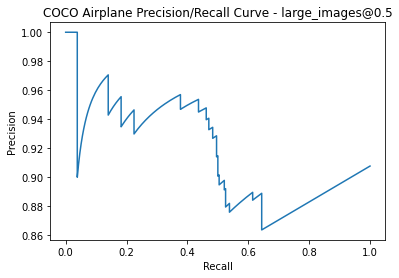

In [69]:
class_name='airplane'
xlabel = 'Recall'
ylabel = 'Precision'
title = 'COCO Airplane Precision/Recall Curve - large_images@' + str(iou_threshold)
save_fig_name = './model_evaluation_results/COCO-COCO/AIRPLANE_CLASS/coco_airplane_evaluation_result-PrecisionVsRecall_iou@' + str(iou_threshold) + '_large_images.png'
show_model_evaluation_result(model_eval_result,iou_threshold,class_name,xlabel,ylabel,title,save_fig_name)

In [70]:
iou_threshold = 0.75
model_evaluation_report_name = './model_evaluation_results/COCO-COCO/AIRPLANE_CLASS/coco_airplane_evaluation_result_iou_' + str(iou_threshold) + '_large_images.csv'
model_eval_result_1,IoU_1 = evaluate_model(test_imgs, iou_threshold, C, model_rpn, model_classifier_only,model_evaluation_report_name)

1/236
Elapsed time = 3.101085901260376
[{'x1': 272, 'x2': 432, 'y1': 64, 'y2': 128, 'class': 'airplane', 'prob': 0.90699184}]
[0.90699184]
IoU = 0.7959912540412242
key = airplane
airplane AP: 1.0
mAP = 1.0
{'airplane': [1]}
{'airplane': [0.90699184]}
2/236
Elapsed time = 2.9833829402923584
[{'x1': 0, 'x2': 640, 'y1': 32, 'y2': 368, 'class': 'airplane', 'prob': 0.9095809}, {'x1': -64, 'x2': 640, 'y1': 0, 'y2': 416, 'class': 'airplane', 'prob': 0.8017694}, {'x1': 0, 'x2': 464, 'y1': 16, 'y2': 400, 'class': 'airplane', 'prob': 0.6284068}, {'x1': 16, 'x2': 544, 'y1': 64, 'y2': 368, 'class': 'airplane', 'prob': 0.6276341}, {'x1': -32, 'x2': 608, 'y1': 16, 'y2': 256, 'class': 'airplane', 'prob': 0.5480489}, {'x1': 16, 'x2': 528, 'y1': 16, 'y2': 320, 'class': 'airplane', 'prob': 0.5203006}, {'x1': 16, 'x2': 496, 'y1': 16, 'y2': 256, 'class': 'airplane', 'prob': 0.5098516}]
[0.9095809 0.8017694 0.6284068 0.6276341 0.5480489 0.5203006 0.5098516]
IoU = 0.03484351814297414
IoU = 0.025584401433683

Elapsed time = 4.578830003738403
[]
[]
key = airplane
airplane AP: 0.6984132247063283
mAP = 0.6984132247063283
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.9095809, 0.8017694, 0.6284068, 0.6276341, 0.5480489, 0.5203006, 0.5098516, 0, 0, 0, 0, 0.7303253, 0.64912826, 0, 0.61046726, 0, 0, 0, 0.95605963, 0.70631254, 0, 0.84824675, 0, 0.65314573, 0, 0.7846785, 0, 0]}
21/236
Elapsed time = 4.701242208480835
[{'x1': 288, 'x2': 560, 'y1': 208, 'y2': 288, 'class': 'airplane', 'prob': 0.53233737}]
[0.53233737]
IoU = 0.9300252982046514
key = airplane
airplane AP: 0.6969562183847897
mAP = 0.6969562183847897
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.9095809, 0.8017694, 0.6284068, 0.6276341, 0.5480489, 0.5203006, 0.5098516, 0, 0, 0, 0, 0.7303253, 0.64912826, 0, 0.61046726, 0, 0, 0, 0.95605963, 0.70631254, 0, 0.84824675, 0, 0.6

Elapsed time = 4.51204776763916
[]
[]
key = airplane
airplane AP: 0.7167385558065815
mAP = 0.7167385558065815
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.9095809, 0.8017694, 0.6284068, 0.6276341, 0.5480489, 0.5203006, 0.5098516, 0, 0, 0, 0, 0.7303253, 0.64912826, 0, 0.61046726, 0, 0, 0, 0.95605963, 0.70631254, 0, 0.84824675, 0, 0.65314573, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9569529, 0.74604523, 0.50767064, 0.7759155, 0, 0, 0, 0.82769805, 0.81660694, 0, 0.54830956, 0, 0, 0]}
34/236
Elapsed time = 4.24610161781311
[{'x1': 96, 'x2': 304, 'y1': 208, 'y2': 272, 'class': 'airplane', 'prob': 0.72230375}, {'x1': 16, 'x2': 304, 'y1': 224, 'y2': 304, 'class': 'airplane', 'prob': 0.67337596}, {'x1': 96, 'x2': 224, 'y1': 208, 'y2': 288, 'class': 'airplane', 'prob': 0.5507512}, {'x1': 32, 'x2': 352, 'y1': 208, 'y2': 288, 'class': 'airplane', 'prob': 0

Elapsed time = 5.054090261459351
[]
[]
key = airplane
airplane AP: 0.5649747349230094
mAP = 0.5649747349230094
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.9095809, 0.8017694, 0.6284068, 0.6276341, 0.5480489, 0.5203006, 0.5098516, 0, 0, 0, 0, 0.7303253, 0.64912826, 0, 0.61046726, 0, 0, 0, 0.95605963, 0.70631254, 0, 0.84824675, 0, 0.65314573, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9569529, 0.74604523, 0.50767064, 0.7759155, 0, 0, 0, 0.82769805, 0.81660694, 0, 0.54830956, 0, 0, 0, 0.72230375, 0.67337596, 0.5507512, 0.53723836, 0.79606605, 0.511457, 0.54743415, 0, 0.967973, 0.8836424, 0.78306246, 0.77098286, 0.6855163, 0.67582357, 0.61168957, 0.6043478, 0.5958066, 0.52060527, 0, 0, 0.64053565, 0]}
42/236
Elapsed time = 5.079165935516357
[{'x1': 176, 'x2': 400, 'y1': 144, 'y2': 288,

Elapsed time = 4.339182615280151
[]
[]
key = airplane
airplane AP: 0.609724047291745
mAP = 0.609724047291745
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1]}
{'airplane': [0.90699184, 0.9095809, 0.8017694, 0.6284068, 0.6276341, 0.5480489, 0.5203006, 0.5098516, 0, 0, 0, 0, 0.7303253, 0.64912826, 0, 0.61046726, 0, 0, 0, 0.95605963, 0.70631254, 0, 0.84824675, 0, 0.65314573, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9569529, 0.74604523, 0.50767064, 0.7759155, 0, 0, 0, 0.82769805, 0.81660694, 0, 0.54830956, 0, 0, 0, 0.72230375, 0.67337596, 0.5507512, 0.53723836, 0.79606605, 0.511457, 0.54743415, 0, 0.967973, 0.8836424, 0.78306246, 0.77098286, 0.6855163, 0.67582357, 0.61168957, 0.6043478, 0.5958066, 0.52060527, 0, 0, 0.64053565, 0, 0.8175136, 0, 0.58078706, 0.5546795, 0.7977735, 0.95820934

Elapsed time = 4.452333450317383
[]
[]
key = airplane
airplane AP: 0.6377381899490544
mAP = 0.6377381899490544
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.90699184, 0.9095809, 0.8017694, 0.6284068, 0.6276341, 0.5480489, 0.5203006, 0.5098516, 0, 0, 0, 0, 0.7303253, 0.64912826, 0, 0.61046726, 0, 0, 0, 0.95605963, 0.70631254, 0, 0.84824675, 0, 0.65314573, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9569529, 0.74604523, 0.50767064, 0.7759155, 0, 0, 0, 0.82769805, 0.81660694, 0, 0.54830956, 0, 0, 0, 0.72230375, 0.67337596, 0.5507512, 0.53723836, 0.79606605, 0.511457, 0.54743415, 0, 0.967973, 0.8836424, 0.78306246, 0.77098286, 0.6855163, 0.67582357, 0.61168957, 0.6043478, 0.5958066, 0.52060527, 0, 0, 0.64053565, 0, 0.8175136, 0, 0.58078706, 0.5546

Elapsed time = 5.093738555908203
[{'x1': 80, 'x2': 528, 'y1': 64, 'y2': 224, 'class': 'airplane', 'prob': 0.8290057}]
[0.8290057]
IoU = 0.4582894023279075
key = airplane
airplane AP: 0.6497437975620324
mAP = 0.6497437975620324
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1]}
{'airplane': [0.90699184, 0.9095809, 0.8017694, 0.6284068, 0.6276341, 0.5480489, 0.5203006, 0.5098516, 0, 0, 0, 0, 0.7303253, 0.64912826, 0, 0.61046726, 0, 0, 0, 0.95605963, 0.70631254, 0, 0.84824675, 0, 0.65314573, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9569529, 0.74604523, 0.50767064, 0.7759155, 0, 0, 0, 0.82769805, 0.81660694, 0, 0.54830956, 0, 0, 0, 0.72230375, 0.67337596, 0.5507512, 0.53723836, 0.79606605, 0.511457, 0.54743415, 0, 0.967973, 0.8836424, 

Elapsed time = 4.432625770568848
[{'x1': 240, 'x2': 480, 'y1': 144, 'y2': 336, 'class': 'airplane', 'prob': 0.576173}]
[0.576173]
IoU = 0.7009242902895719
key = airplane
airplane AP: 0.6716729089436391
mAP = 0.6716729089436391
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1]}
{'airplane': [0.90699184, 0.9095809, 0.8017694, 0.6284068, 0.6276341, 0.5480489, 0.5203006, 0.5098516, 0, 0, 0, 0, 0.7303253, 0.64912826, 0, 0.61046726, 0, 0, 0, 0.95605963, 0.70631254, 0, 0.84824675, 0, 0.65314573, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9569529, 0.74604523, 0.50767064, 0.7759155, 0, 0, 0, 0.82769805, 0.81660694, 0, 0.54830956, 0, 0, 0, 0.72230375, 0.67337596, 0.5507512, 0.53723836, 0.79606605, 0.511457, 0.5474

Elapsed time = 4.68992805480957
[{'x1': 80, 'x2': 528, 'y1': 144, 'y2': 288, 'class': 'airplane', 'prob': 0.96224856}]
[0.96224856]
IoU = 0.7180005177162235
key = airplane
airplane AP: 0.6896204624894136
mAP = 0.6896204624894136
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]}
{'airplane': [0.90699184, 0.9095809, 0.8017694, 0.6284068, 0.6276341, 0.5480489, 0.5203006, 0.5098516, 0, 0, 0, 0, 0.7303253, 0.64912826, 0, 0.61046726, 0, 0, 0, 0.95605963, 0.70631254, 0, 0.84824675, 0, 0.65314573, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9569529, 0.74604523, 0.50767064, 0.7759155, 0, 0, 0, 0.82769805, 0.81660694, 0, 0.54830956, 0, 0, 0, 0.72230375, 0.67337596, 0.5507512, 0.53723836,

Elapsed time = 4.369816064834595
[]
[]
key = airplane
airplane AP: 0.6936491137861742
mAP = 0.6936491137861742
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1]}
{'airplane': [0.90699184, 0.9095809, 0.8017694, 0.6284068, 0.6276341, 0.5480489, 0.5203006, 0.5098516, 0, 0, 0, 0, 0.7303253, 0.64912826, 0, 0.61046726, 0, 0, 0, 0.95605963, 0.70631254, 0, 0.84824675, 0, 0.65314573, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9569529, 0.74604523, 0.50767064, 0.7759155, 0, 0, 0, 0.82769805, 0.81660694, 0, 0.54830956, 0, 0, 0, 0.72230375, 0.67337596, 0.5507512, 0.53723836, 0.79606605, 0.511457, 0.54743415, 0, 0.967973, 0.8836424, 0.78306246, 0.77098286, 0.6855163, 

Elapsed time = 4.374490022659302
[{'x1': 32, 'x2': 496, 'y1': 176, 'y2': 304, 'class': 'airplane', 'prob': 0.9050388}]
[0.9050388]
IoU = 0.8737464207336012
key = airplane
airplane AP: 0.7117038188852091
mAP = 0.7117038188852091
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1]}
{'airplane': [0.90699184, 0.9095809, 0.8017694, 0.6284068, 0.6276341, 0.5480489, 0.5203006, 0.5098516, 0, 0, 0, 0, 0.7303253, 0.64912826, 0, 0.61046726, 0, 0, 0, 0.95605963, 0.70631254, 0, 0.84824675, 0, 0.65314573, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9569529, 0.74604523, 0.50767064, 0.7759155, 0, 0, 0, 0.82769805, 0.81660694, 0, 0.54830956, 0, 0, 0, 0.

Elapsed time = 4.336503744125366
[]
[]
key = airplane
airplane AP: 0.7025825760031741
mAP = 0.7025825760031741
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1]}
{'airplane': [0.90699184, 0.9095809, 0.8017694, 0.6284068, 0.6276341, 0.5480489, 0.5203006, 0.5098516, 0, 0, 0, 0, 0.7303253, 0.64912826, 0, 0.61046726, 0, 0, 0, 0.95605963, 0.70631254, 0, 0.84824675, 0, 0.65314573, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9569529, 0.74604523, 0.50767064, 0.7759155, 0, 0, 0, 0.82769805, 0.81660694, 0, 0.54830956, 0, 0, 0, 0.72230375, 0.67337596, 0.5507512, 0.53723836, 0.79606605, 0.511457, 0.54743415, 0, 0.967973, 0

Elapsed time = 4.182069301605225
[{'x1': 128, 'x2': 656, 'y1': 144, 'y2': 256, 'class': 'airplane', 'prob': 0.97235715}, {'x1': 112, 'x2': 640, 'y1': 112, 'y2': 256, 'class': 'airplane', 'prob': 0.7586452}]
[0.97235715 0.7586452 ]
IoU = 0.8305687081278734
key = airplane
airplane AP: 0.7196215238043372
mAP = 0.7196215238043372
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0]}
{'airplane': [0.90699184, 0.9095809, 0.8017694, 0.6284068, 0.6276341, 0.5480489, 0.5203006, 0.5098516, 0, 0, 0, 0, 0.7303253, 0.64912826, 0, 0.61046726, 0, 0, 0, 0.95605963, 0.70631254, 0, 0.84824675, 0, 0.65314573, 

Elapsed time = 4.183831214904785
[{'x1': 48, 'x2': 480, 'y1': 144, 'y2': 272, 'class': 'airplane', 'prob': 0.97478217}, {'x1': 80, 'x2': 512, 'y1': 160, 'y2': 288, 'class': 'airplane', 'prob': 0.892465}]
[0.97478217 0.892465  ]
IoU = 0.7913199798558271
key = airplane
airplane AP: 0.7177781301867588
mAP = 0.7177781301867588
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0]}
{'airplane': [0.90699184, 0.9095809, 0.8017694, 0.6284068, 0.6276341, 0.5480489, 0.5203006, 0.5098516, 0, 0, 0, 0, 0.7303253, 0.64912826, 0, 0.61046726, 0, 0, 0, 0.95605963, 0.70631254, 0, 0.8

Elapsed time = 4.160324811935425
[{'x1': 16, 'x2': 464, 'y1': 144, 'y2': 256, 'class': 'airplane', 'prob': 0.9620583}]
[0.9620583]
IoU = 0.6944119447715839
key = airplane
airplane AP: 0.72697658615588
mAP = 0.72697658615588
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1]}
{'airplane': [0.90699184, 0.9095809, 0.8017694, 0.6284068, 0.6276341, 0.5480489, 0.5203006, 0.5098516, 0, 0, 0, 0, 0.7303253, 0.64912826, 0, 0.61046726, 0, 0, 0, 0.95605963, 0.70631254, 0, 0.84824675, 0, 0.65314573, 0, 0.7846785, 0, 0, 0.53233737, 0.7890937, 0, 0.9569529,

Elapsed time = 4.486751317977905
[{'x1': 48, 'x2': 560, 'y1': 144, 'y2': 256, 'class': 'airplane', 'prob': 0.974555}, {'x1': 32, 'x2': 544, 'y1': 128, 'y2': 272, 'class': 'airplane', 'prob': 0.79303753}]
[0.974555   0.79303753]
IoU = 0.7782256197931331
key = airplane
airplane AP: 0.7381784401878705
mAP = 0.7381784401878705
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0]}
{'airplane': [0.90699184, 0.9095809, 0.8017694, 0.6284068, 0.6276341, 0.5480489, 0.5203006, 0.5098516, 0, 0, 0, 0, 0.7303253, 0.64912826, 0, 0.6104672

Elapsed time = 4.698137521743774
[{'x1': 112, 'x2': 448, 'y1': 112, 'y2': 304, 'class': 'airplane', 'prob': 0.95918226}]
[0.95918226]
IoU = 0.9618895692958006
key = airplane
airplane AP: 0.749992361520353
mAP = 0.749992361520353
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1]}
{'airplane': [0.90699184, 0.9095809, 0.8017694, 0.6284068, 0.6276341, 0.5480489, 0.5203006, 0.5098516, 0, 0, 0, 0, 0.7303253, 0.64912826, 0, 0.61046726, 0, 0, 0, 0.95605963, 0.70631254, 0, 0.84824675, 0, 0.65314573, 0, 0.7846785

Elapsed time = 4.417290687561035
[{'x1': -96, 'x2': 608, 'y1': 32, 'y2': 352, 'class': 'airplane', 'prob': 0.66618985}, {'x1': -48, 'x2': 544, 'y1': 16, 'y2': 384, 'class': 'airplane', 'prob': 0.55294836}, {'x1': -80, 'x2': 544, 'y1': 16, 'y2': 288, 'class': 'airplane', 'prob': 0.51462114}]
[0.66618985 0.55294836 0.51462114]
IoU = 0.38590673870183606
IoU = 0.43203164361650487
IoU = 0.5545383540228764
key = airplane
airplane AP: 0.7451096425311382
mAP = 0.7451096425311382
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 

Elapsed time = 4.353333950042725
[{'x1': 48, 'x2': 432, 'y1': 112, 'y2': 304, 'class': 'airplane', 'prob': 0.93691933}]
[0.93691933]
IoU = 0.6720498768847118
key = airplane
airplane AP: 0.7321564774253976
mAP = 0.7321564774253976
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1]}
{'airplane': [0.90699184, 0.9095809, 0.8017694, 0.6284068, 0.6276341, 0.5480489, 0.5203006, 0.5098516, 0, 0, 0, 0, 0.7303253, 0.64912826, 0, 0.61046726, 0, 0, 0, 0.95605963,

Elapsed time = 4.32665491104126
[{'x1': 112, 'x2': 656, 'y1': 96, 'y2': 384, 'class': 'airplane', 'prob': 0.9563799}, {'x1': 144, 'x2': 576, 'y1': 112, 'y2': 400, 'class': 'airplane', 'prob': 0.8526321}, {'x1': 128, 'x2': 640, 'y1': -48, 'y2': 352, 'class': 'airplane', 'prob': 0.8296219}, {'x1': 48, 'x2': 640, 'y1': 192, 'y2': 368, 'class': 'airplane', 'prob': 0.76208454}, {'x1': 80, 'x2': 528, 'y1': 112, 'y2': 416, 'class': 'airplane', 'prob': 0.7451204}, {'x1': 112, 'x2': 592, 'y1': 160, 'y2': 384, 'class': 'airplane', 'prob': 0.7412834}, {'x1': 96, 'x2': 560, 'y1': 192, 'y2': 400, 'class': 'airplane', 'prob': 0.7153081}, {'x1': 192, 'x2': 624, 'y1': 112, 'y2': 336, 'class': 'airplane', 'prob': 0.68381876}, {'x1': 80, 'x2': 512, 'y1': 240, 'y2': 384, 'class': 'airplane', 'prob': 0.6563491}, {'x1': 160, 'x2': 624, 'y1': 32, 'y2': 352, 'class': 'airplane', 'prob': 0.62292904}, {'x1': 336, 'x2': 624, 'y1': 0, 'y2': 288, 'class': 'airplane', 'prob': 0.5759223}, {'x1': 112, 'x2': 560, 'y1

Elapsed time = 4.140229940414429
[{'x1': 32, 'x2': 672, 'y1': 144, 'y2': 272, 'class': 'airplane', 'prob': 0.80484563}]
[0.80484563]
IoU = 0.7964286388781084
key = airplane
airplane AP: 0.7139760486080559
mAP = 0.7139760486080559
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1]}
{'airplane': [0.90699184, 0.9095809, 0.8017694, 0.6284068, 0.6276341, 0.5480489, 0.5203006, 0.5098516, 0, 0, 0

Elapsed time = 4.119736909866333
[{'x1': 80, 'x2': 432, 'y1': 144, 'y2': 416, 'class': 'airplane', 'prob': 0.5296404}]
[0.5296404]
IoU = 0.40998550682741247
key = airplane
airplane AP: 0.6946903319295387
mAP = 0.6946903319295387
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1]}
{'airplane': [0.90699184, 0.9095809, 0.8017694, 0.6284068, 0.6276341, 0.548

Elapsed time = 4.40442156791687
[]
[]
key = airplane
airplane AP: 0.6962836890510922
mAP = 0.6962836890510922
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1]}
{'airplane': [0.90699184, 0.9095809, 0.8017694, 0.6284068, 0.6276341, 0.5480489, 0.5203006, 0.5098516, 0, 0, 0, 0, 0.7303253, 0.64912826, 0, 0.61046726, 0, 0, 0, 0.95605963, 0.706312

Elapsed time = 4.554946184158325
[{'x1': 48, 'x2': 640, 'y1': 96, 'y2': 320, 'class': 'airplane', 'prob': 0.98591125}, {'x1': 64, 'x2': 560, 'y1': 64, 'y2': 336, 'class': 'airplane', 'prob': 0.7062266}]
[0.98591125 0.7062266 ]
IoU = 0.4743077237690984
IoU = 0.5070629843122524
key = airplane
airplane AP: 0.6782693177106768
mAP = 0.6782693177106768
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0

Elapsed time = 4.660874128341675
[]
[]
key = airplane
airplane AP: 0.6774418033964217
mAP = 0.6774418033964217
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1]}
{'airplane': [0.90699184, 0.9095809, 0.8017694, 0.6284068, 0.6276341, 0.5480489, 0.5203006, 0.5098516, 0, 0, 0, 0, 0.7303253, 0.64912826, 0, 0.61

Elapsed time = 4.214290142059326
[{'x1': 16, 'x2': 592, 'y1': 64, 'y2': 240, 'class': 'airplane', 'prob': 0.99162126}, {'x1': 0, 'x2': 544, 'y1': 80, 'y2': 256, 'class': 'airplane', 'prob': 0.7281794}]
[0.99162126 0.7281794 ]
IoU = 0.7685978731016015
key = airplane
airplane AP: 0.683822096438317
mAP = 0.683822096438317
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,

Elapsed time = 4.220418930053711
[{'x1': -16, 'x2': 608, 'y1': 48, 'y2': 224, 'class': 'airplane', 'prob': 0.98596257}, {'x1': 16, 'x2': 656, 'y1': 64, 'y2': 240, 'class': 'airplane', 'prob': 0.95652133}, {'x1': 144, 'x2': 624, 'y1': 64, 'y2': 224, 'class': 'airplane', 'prob': 0.7261985}, {'x1': 16, 'x2': 512, 'y1': 64, 'y2': 224, 'class': 'airplane', 'prob': 0.51003414}]
[0.98596257 0.95652133 0.7261985  0.51003414]
IoU = 0.8738534992383122
key = airplane
airplane AP: 0.6836450457537404
mAP = 0.6836450457537404
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 

Elapsed time = 4.319798946380615
[{'x1': -16, 'x2': 592, 'y1': 128, 'y2': 240, 'class': 'airplane', 'prob': 0.740629}, {'x1': -16, 'x2': 592, 'y1': 144, 'y2': 256, 'class': 'airplane', 'prob': 0.7021847}]
[0.740629  0.7021847]
IoU = 0.6665845068313163
key = airplane
airplane AP: 0.6819028571181175
mAP = 0.6819028571181175
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,

Elapsed time = 4.5429229736328125
[{'x1': 112, 'x2': 512, 'y1': 80, 'y2': 336, 'class': 'airplane', 'prob': 0.9877281}, {'x1': 96, 'x2': 512, 'y1': 128, 'y2': 320, 'class': 'airplane', 'prob': 0.72722906}]
[0.9877281  0.72722906]
IoU = 0.817324617317652
key = airplane
airplane AP: 0.6918611943286643
mAP = 0.6918611943286643
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 

Elapsed time = 4.562075138092041
[{'x1': 16, 'x2': 672, 'y1': 160, 'y2': 336, 'class': 'airplane', 'prob': 0.9414806}]
[0.9414806]
IoU = 0.7902097890606098
key = airplane
airplane AP: 0.697415080922586
mAP = 0.697415080922586
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0

Elapsed time = 4.5071728229522705
[{'x1': 112, 'x2': 384, 'y1': 112, 'y2': 384, 'class': 'airplane', 'prob': 0.5947243}, {'x1': 64, 'x2': 400, 'y1': 96, 'y2': 368, 'class': 'airplane', 'prob': 0.5743018}]
[0.5947243 0.5743018]
IoU = 0.7172274900773488
key = airplane
airplane AP: 0.6786700880879152
mAP = 0.6786700880879152
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0,

Elapsed time = 4.109821557998657
[{'x1': 48, 'x2': 576, 'y1': 128, 'y2': 288, 'class': 'airplane', 'prob': 0.9818972}]
[0.9818972]
IoU = 0.929857873745281
key = airplane
airplane AP: 0.6825017300788696
mAP = 0.6825017300788696
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 

Elapsed time = 4.3480143547058105
[{'x1': 128, 'x2': 512, 'y1': 48, 'y2': 336, 'class': 'airplane', 'prob': 0.96036863}, {'x1': 144, 'x2': 544, 'y1': 80, 'y2': 320, 'class': 'airplane', 'prob': 0.9363609}, {'x1': 144, 'x2': 544, 'y1': 128, 'y2': 336, 'class': 'airplane', 'prob': 0.7927767}]
[0.96036863 0.9363609  0.7927767 ]
IoU = 0.8877835486577687
key = airplane
airplane AP: 0.6743725613759357
mAP = 0.6743725613759357
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1

Elapsed time = 4.747378587722778
[{'x1': 16, 'x2': 560, 'y1': 176, 'y2': 352, 'class': 'airplane', 'prob': 0.7970528}, {'x1': 0, 'x2': 608, 'y1': 128, 'y2': 352, 'class': 'airplane', 'prob': 0.78983957}]
[0.7970528  0.78983957]
IoU = 0.5989456603873349
key = airplane
airplane AP: 0.6767150614132992
mAP = 0.6767150614132992
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0

Elapsed time = 4.40058970451355
[{'x1': 48, 'x2': 608, 'y1': 160, 'y2': 320, 'class': 'airplane', 'prob': 0.98606884}, {'x1': 0, 'x2': 576, 'y1': 144, 'y2': 304, 'class': 'airplane', 'prob': 0.9778903}, {'x1': 48, 'x2': 496, 'y1': 144, 'y2': 320, 'class': 'airplane', 'prob': 0.80874264}, {'x1': 144, 'x2': 576, 'y1': 176, 'y2': 320, 'class': 'airplane', 'prob': 0.61224353}, {'x1': 64, 'x2': 544, 'y1': 128, 'y2': 336, 'class': 'airplane', 'prob': 0.5097794}]
[0.98606884 0.9778903  0.80874264 0.61224353 0.5097794 ]
IoU = 0.8257221819877786
key = airplane
airplane AP: 0.6751708686804228
mAP = 0.6751708686804228
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,

Elapsed time = 4.561453819274902
[{'x1': -16, 'x2': 480, 'y1': 16, 'y2': 256, 'class': 'airplane', 'prob': 0.93739}, {'x1': -32, 'x2': 400, 'y1': 32, 'y2': 272, 'class': 'airplane', 'prob': 0.9148401}, {'x1': -16, 'x2': 464, 'y1': 48, 'y2': 304, 'class': 'airplane', 'prob': 0.89098454}]
[0.93739    0.9148401  0.89098454]
IoU = 0.5355506166734291
key = airplane
airplane AP: 0.6731440279461317
mAP = 0.6731440279461317
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,

Elapsed time = 4.134286403656006
[{'x1': 0, 'x2': 624, 'y1': 112, 'y2': 272, 'class': 'airplane', 'prob': 0.9910841}, {'x1': 32, 'x2': 592, 'y1': 128, 'y2': 288, 'class': 'airplane', 'prob': 0.900802}]
[0.9910841 0.900802 ]
IoU = 0.7575570962527517
key = airplane
airplane AP: 0.6716714510609956
mAP = 0.6716714510609956
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,

Elapsed time = 4.425065994262695
[{'x1': -16, 'x2': 304, 'y1': 32, 'y2': 384, 'class': 'airplane', 'prob': 0.8895854}, {'x1': -16, 'x2': 400, 'y1': 16, 'y2': 336, 'class': 'airplane', 'prob': 0.81100243}, {'x1': -32, 'x2': 464, 'y1': 48, 'y2': 400, 'class': 'airplane', 'prob': 0.64681464}, {'x1': 0, 'x2': 384, 'y1': 48, 'y2': 304, 'class': 'airplane', 'prob': 0.50976974}]
[0.8895854  0.81100243 0.64681464 0.50976974]
IoU = 0.7908948760164216
key = airplane
airplane AP: 0.6722999488080195
mAP = 0.6722999488080195
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 

Elapsed time = 4.17490816116333
[{'x1': -16, 'x2': 624, 'y1': 112, 'y2': 304, 'class': 'airplane', 'prob': 0.9873188}, {'x1': 16, 'x2': 496, 'y1': 112, 'y2': 304, 'class': 'airplane', 'prob': 0.8208483}]
[0.9873188 0.8208483]
IoU = 0.8784116960682988
key = airplane
airplane AP: 0.6674465486540672
mAP = 0.6674465486540672
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 

Elapsed time = 4.350781440734863
[{'x1': 16, 'x2': 544, 'y1': 112, 'y2': 272, 'class': 'airplane', 'prob': 0.9615319}, {'x1': 16, 'x2': 592, 'y1': 128, 'y2': 304, 'class': 'airplane', 'prob': 0.9399806}]
[0.9615319 0.9399806]
IoU = 0.7664702038903877
key = airplane
airplane AP: 0.6633142497517973
mAP = 0.6633142497517973
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 

Elapsed time = 4.353573560714722
[]
[]
key = airplane
airplane AP: 0.6637315733985503
mAP = 0.6637315733985503
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,

Elapsed time = 4.28144097328186
[{'x1': 16, 'x2': 496, 'y1': 160, 'y2': 320, 'class': 'airplane', 'prob': 0.93376887}, {'x1': -48, 'x2': 528, 'y1': 192, 'y2': 336, 'class': 'airplane', 'prob': 0.7802684}, {'x1': -16, 'x2': 512, 'y1': 208, 'y2': 320, 'class': 'airplane', 'prob': 0.5089897}]
[0.93376887 0.7802684  0.5089897 ]
IoU = 0.6577159387263375
key = airplane
airplane AP: 0.6653885852273189
mAP = 0.6653885852273189
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,

Elapsed time = 4.527233839035034
[{'x1': 32, 'x2': 512, 'y1': 96, 'y2': 304, 'class': 'airplane', 'prob': 0.99192035}, {'x1': 80, 'x2': 496, 'y1': 112, 'y2': 320, 'class': 'airplane', 'prob': 0.5798331}]
[0.99192035 0.5798331 ]
IoU = 0.8364063794579047
key = airplane
airplane AP: 0.6664022113593397
mAP = 0.6664022113593397
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0

Elapsed time = 4.2659523487091064
[{'x1': 32, 'x2': 672, 'y1': 112, 'y2': 352, 'class': 'airplane', 'prob': 0.9693787}, {'x1': 32, 'x2': 528, 'y1': 96, 'y2': 336, 'class': 'airplane', 'prob': 0.9321652}, {'x1': 48, 'x2': 640, 'y1': 144, 'y2': 336, 'class': 'airplane', 'prob': 0.86332333}, {'x1': 128, 'x2': 640, 'y1': 160, 'y2': 352, 'class': 'airplane', 'prob': 0.5771322}]
[0.9693787  0.9321652  0.86332333 0.5771322 ]
IoU = 0.7278155896486665
key = airplane
airplane AP: 0.6639879708136105
mAP = 0.6639879708136105
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,

Elapsed time = 4.601942777633667
[{'x1': -80, 'x2': 512, 'y1': 192, 'y2': 416, 'class': 'airplane', 'prob': 0.72968906}, {'x1': -32, 'x2': 432, 'y1': 160, 'y2': 448, 'class': 'airplane', 'prob': 0.6500923}, {'x1': -48, 'x2': 624, 'y1': 208, 'y2': 432, 'class': 'airplane', 'prob': 0.50122184}]
[0.72968906 0.6500923  0.50122184]
IoU = 0.7387005746560134
key = airplane
airplane AP: 0.6655329420302146
mAP = 0.6655329420302146
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,

Elapsed time = 4.137298822402954
[{'x1': 112, 'x2': 448, 'y1': 32, 'y2': 320, 'class': 'airplane', 'prob': 0.8932221}, {'x1': 96, 'x2': 480, 'y1': 48, 'y2': 352, 'class': 'airplane', 'prob': 0.63777095}]
[0.8932221  0.63777095]
IoU = 0.8160385219784884
key = airplane
airplane AP: 0.6676252690293217
mAP = 0.6676252690293217
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0

Elapsed time = 4.490783929824829
[{'x1': -16, 'x2': 592, 'y1': 80, 'y2': 320, 'class': 'airplane', 'prob': 0.95457244}, {'x1': 0, 'x2': 480, 'y1': 64, 'y2': 320, 'class': 'airplane', 'prob': 0.80122393}, {'x1': -16, 'x2': 624, 'y1': 96, 'y2': 272, 'class': 'airplane', 'prob': 0.72055453}]
[0.95457244 0.80122393 0.72055453]
IoU = 0.9130367779286822
key = airplane
airplane AP: 0.670404506574585
mAP = 0.670404506574585
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1,

Elapsed time = 4.199563026428223
[{'x1': 64, 'x2': 352, 'y1': 64, 'y2': 368, 'class': 'airplane', 'prob': 0.91881025}, {'x1': 48, 'x2': 384, 'y1': 80, 'y2': 304, 'class': 'airplane', 'prob': 0.877768}]
[0.91881025 0.877768  ]
IoU = 0.7659258178123399
key = airplane
airplane AP: 0.6730360733298532
mAP = 0.6730360733298532
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 

Elapsed time = 4.592127561569214
[{'x1': -32, 'x2': 640, 'y1': 128, 'y2': 416, 'class': 'airplane', 'prob': 0.86220366}, {'x1': -16, 'x2': 464, 'y1': 128, 'y2': 384, 'class': 'airplane', 'prob': 0.7922413}, {'x1': -16, 'x2': 528, 'y1': 128, 'y2': 336, 'class': 'airplane', 'prob': 0.61193496}]
[0.86220366 0.7922413  0.61193496]
IoU = 0.5505141149526365
key = airplane
airplane AP: 0.6738749520390572
mAP = 0.6738749520390572
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1,

Elapsed time = 4.32169508934021
[{'x1': -32, 'x2': 512, 'y1': 112, 'y2': 368, 'class': 'airplane', 'prob': 0.83791304}, {'x1': -16, 'x2': 496, 'y1': 64, 'y2': 352, 'class': 'airplane', 'prob': 0.78096026}]
[0.83791304 0.78096026]
IoU = 0.4992121766780766
IoU = 0.6641098550473228
key = airplane
airplane AP: 0.6700558126359075
mAP = 0.6700558126359075
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0

Elapsed time = 4.727200508117676
[{'x1': 0, 'x2': 880, 'y1': 96, 'y2': 352, 'class': 'airplane', 'prob': 0.9724458}, {'x1': 16, 'x2': 784, 'y1': 112, 'y2': 384, 'class': 'airplane', 'prob': 0.8723201}, {'x1': 112, 'x2': 784, 'y1': 64, 'y2': 368, 'class': 'airplane', 'prob': 0.86599797}, {'x1': 192, 'x2': 784, 'y1': 80, 'y2': 320, 'class': 'airplane', 'prob': 0.73251784}, {'x1': 144, 'x2': 688, 'y1': 48, 'y2': 400, 'class': 'airplane', 'prob': 0.70654655}]
[0.9724458  0.8723201  0.86599797 0.73251784 0.70654655]
IoU = 0.7397204014817446
key = airplane
airplane AP: 0.6705522188222212
mAP = 0.6705522188222212
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 

Elapsed time = 4.56871485710144
[{'x1': 64, 'x2': 624, 'y1': 96, 'y2': 288, 'class': 'airplane', 'prob': 0.9894778}, {'x1': 0, 'x2': 576, 'y1': 112, 'y2': 272, 'class': 'airplane', 'prob': 0.85233486}, {'x1': 64, 'x2': 528, 'y1': 80, 'y2': 272, 'class': 'airplane', 'prob': 0.51729834}]
[0.9894778  0.85233486 0.51729834]
IoU = 0.6986193287831919
key = airplane
airplane AP: 0.6738316844883687
mAP = 0.6738316844883687
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 

Elapsed time = 4.351885080337524
[{'x1': 48, 'x2': 592, 'y1': 64, 'y2': 336, 'class': 'airplane', 'prob': 0.95830345}, {'x1': 176, 'x2': 560, 'y1': 64, 'y2': 352, 'class': 'airplane', 'prob': 0.87110555}, {'x1': 112, 'x2': 528, 'y1': 64, 'y2': 368, 'class': 'airplane', 'prob': 0.82310975}, {'x1': 64, 'x2': 608, 'y1': 112, 'y2': 320, 'class': 'airplane', 'prob': 0.81580836}, {'x1': 48, 'x2': 576, 'y1': 64, 'y2': 272, 'class': 'airplane', 'prob': 0.78677756}, {'x1': 112, 'x2': 560, 'y1': 80, 'y2': 320, 'class': 'airplane', 'prob': 0.6402727}]
[0.95830345 0.87110555 0.82310975 0.81580836 0.78677756 0.6402727 ]
IoU = 0.8680457153010499
key = airplane
airplane AP: 0.6743084445333768
mAP = 0.6743084445333768
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1

Elapsed time = 4.3339221477508545
[{'x1': 0, 'x2': 448, 'y1': 112, 'y2': 304, 'class': 'airplane', 'prob': 0.75842756}]
[0.75842756]
IoU = 0.7702892330407102
key = airplane
airplane AP: 0.6764606201413534
mAP = 0.6764606201413534
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 

Elapsed time = 4.005106687545776
[{'x1': 16, 'x2': 432, 'y1': 128, 'y2': 272, 'class': 'airplane', 'prob': 0.9847253}, {'x1': 48, 'x2': 416, 'y1': 144, 'y2': 288, 'class': 'airplane', 'prob': 0.7653279}]
[0.9847253 0.7653279]
IoU = 0.797787673987041
key = airplane
airplane AP: 0.6782655514550131
mAP = 0.6782655514550131
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0

Elapsed time = 4.27599024772644
[{'x1': 0, 'x2': 464, 'y1': 144, 'y2': 352, 'class': 'airplane', 'prob': 0.9917361}]
[0.9917361]
IoU = 0.7727526101569485
key = airplane
airplane AP: 0.6808629117395848
mAP = 0.6808629117395848
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0

Elapsed time = 4.21100640296936
[{'x1': -32, 'x2': 512, 'y1': 80, 'y2': 336, 'class': 'airplane', 'prob': 0.94744897}]
[0.94744897]
IoU = 0.8229095716336178
key = airplane
airplane AP: 0.6841260878735251
mAP = 0.6841260878735251
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0

Elapsed time = 4.374601125717163
[{'x1': 16, 'x2': 704, 'y1': -32, 'y2': 368, 'class': 'airplane', 'prob': 0.95305985}, {'x1': -48, 'x2': 672, 'y1': 80, 'y2': 368, 'class': 'airplane', 'prob': 0.9106919}, {'x1': 48, 'x2': 544, 'y1': -16, 'y2': 368, 'class': 'airplane', 'prob': 0.894112}, {'x1': -32, 'x2': 608, 'y1': 128, 'y2': 368, 'class': 'airplane', 'prob': 0.8922255}, {'x1': 0, 'x2': 640, 'y1': 0, 'y2': 320, 'class': 'airplane', 'prob': 0.87773955}, {'x1': 96, 'x2': 640, 'y1': -32, 'y2': 144, 'class': 'airplane', 'prob': 0.61672205}, {'x1': 48, 'x2': 576, 'y1': 160, 'y2': 384, 'class': 'airplane', 'prob': 0.58913434}, {'x1': 0, 'x2': 624, 'y1': 80, 'y2': 304, 'class': 'airplane', 'prob': 0.5632069}, {'x1': 48, 'x2': 640, 'y1': 48, 'y2': 384, 'class': 'airplane', 'prob': 0.51566845}]
[0.95305985 0.9106919  0.894112   0.8922255  0.87773955 0.61672205
 0.58913434 0.5632069  0.51566845]
IoU = 0.49042597990315645
IoU = 0.6606043522937289
key = airplane
airplane AP: 0.6771115417483604
mA

Elapsed time = 4.224131345748901
[{'x1': 0, 'x2': 544, 'y1': 32, 'y2': 256, 'class': 'airplane', 'prob': 0.98341376}, {'x1': 16, 'x2': 608, 'y1': 32, 'y2': 304, 'class': 'airplane', 'prob': 0.9376332}, {'x1': 48, 'x2': 576, 'y1': 64, 'y2': 272, 'class': 'airplane', 'prob': 0.8350041}, {'x1': 32, 'x2': 464, 'y1': 16, 'y2': 288, 'class': 'airplane', 'prob': 0.65264165}, {'x1': 64, 'x2': 576, 'y1': 96, 'y2': 256, 'class': 'airplane', 'prob': 0.5067544}]
[0.98341376 0.9376332  0.8350041  0.65264165 0.5067544 ]
IoU = 0.8643660191481256
key = airplane
airplane AP: 0.6682012761750433
mAP = 0.6682012761750433
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1,

Elapsed time = 4.456125497817993
[{'x1': 48, 'x2': 592, 'y1': 80, 'y2': 320, 'class': 'airplane', 'prob': 0.7875892}, {'x1': 16, 'x2': 672, 'y1': 96, 'y2': 336, 'class': 'airplane', 'prob': 0.6133891}, {'x1': 32, 'x2': 576, 'y1': 32, 'y2': 336, 'class': 'airplane', 'prob': 0.58944726}, {'x1': 48, 'x2': 368, 'y1': 64, 'y2': 336, 'class': 'airplane', 'prob': 0.55026543}, {'x1': 64, 'x2': 480, 'y1': 64, 'y2': 320, 'class': 'airplane', 'prob': 0.5240312}]
[0.7875892  0.6133891  0.58944726 0.55026543 0.5240312 ]
IoU = 0.7288205169257673
key = airplane
airplane AP: 0.6659492001603893
mAP = 0.6659492001603893
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1

Elapsed time = 4.453885078430176
[{'x1': -32, 'x2': 512, 'y1': 32, 'y2': 304, 'class': 'airplane', 'prob': 0.982746}, {'x1': -16, 'x2': 416, 'y1': 32, 'y2': 288, 'class': 'airplane', 'prob': 0.95422}, {'x1': 32, 'x2': 624, 'y1': 32, 'y2': 320, 'class': 'airplane', 'prob': 0.8650905}, {'x1': -16, 'x2': 368, 'y1': 64, 'y2': 272, 'class': 'airplane', 'prob': 0.6217562}, {'x1': -64, 'x2': 560, 'y1': 48, 'y2': 272, 'class': 'airplane', 'prob': 0.59567714}, {'x1': -16, 'x2': 528, 'y1': 48, 'y2': 224, 'class': 'airplane', 'prob': 0.58344865}]
[0.982746   0.95422    0.8650905  0.6217562  0.59567714 0.58344865]
IoU = 0.6838898673663076
key = airplane
airplane AP: 0.6632691743419719
mAP = 0.6632691743419719
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 

Elapsed time = 4.165687322616577
[{'x1': -64, 'x2': 624, 'y1': 48, 'y2': 320, 'class': 'airplane', 'prob': 0.88596547}, {'x1': -64, 'x2': 560, 'y1': 96, 'y2': 320, 'class': 'airplane', 'prob': 0.5482526}]
[0.88596547 0.5482526 ]
IoU = 0.627547916608049
key = airplane
airplane AP: 0.6651570697403487
mAP = 0.6651570697403487
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0

Elapsed time = 4.594409704208374
[{'x1': -32, 'x2': 656, 'y1': 80, 'y2': 416, 'class': 'airplane', 'prob': 0.91435486}, {'x1': -48, 'x2': 672, 'y1': 96, 'y2': 352, 'class': 'airplane', 'prob': 0.6740747}, {'x1': 32, 'x2': 592, 'y1': 128, 'y2': 384, 'class': 'airplane', 'prob': 0.65966433}]
[0.91435486 0.6740747  0.65966433]
IoU = 0.8952976190437459
key = airplane
airplane AP: 0.665917568975724
mAP = 0.665917568975724
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1

Elapsed time = 4.058157205581665
[{'x1': -16, 'x2': 672, 'y1': 96, 'y2': 320, 'class': 'airplane', 'prob': 0.56678206}, {'x1': 0, 'x2': 672, 'y1': 80, 'y2': 448, 'class': 'airplane', 'prob': 0.5623855}]
[0.56678206 0.5623855 ]
IoU = 0.586505864584759
key = airplane
airplane AP: 0.6642342894631897
mAP = 0.6642342894631897
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 

Elapsed time = 4.476205348968506
[{'x1': 0, 'x2': 592, 'y1': 112, 'y2': 400, 'class': 'airplane', 'prob': 0.9197173}, {'x1': 16, 'x2': 512, 'y1': 128, 'y2': 448, 'class': 'airplane', 'prob': 0.6176523}]
[0.9197173 0.6176523]
IoU = 0.7974867810248334
key = airplane
airplane AP: 0.6659430130734075
mAP = 0.6659430130734075
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0

Elapsed time = 3.9268925189971924
[{'x1': 32, 'x2': 384, 'y1': 32, 'y2': 400, 'class': 'airplane', 'prob': 0.9436237}, {'x1': 64, 'x2': 400, 'y1': 48, 'y2': 304, 'class': 'airplane', 'prob': 0.55170023}]
[0.9436237  0.55170023]
IoU = 0.8069481461820314
key = airplane
airplane AP: 0.6667951497017863
mAP = 0.6667951497017863
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0

Elapsed time = 4.616018533706665
[{'x1': -16, 'x2': 672, 'y1': 48, 'y2': 432, 'class': 'airplane', 'prob': 0.84650296}, {'x1': 0, 'x2': 480, 'y1': -16, 'y2': 432, 'class': 'airplane', 'prob': 0.7630487}]
[0.84650296 0.7630487 ]
IoU = 0.769813454226008
key = airplane
airplane AP: 0.667421438418574
mAP = 0.667421438418574
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0

Elapsed time = 4.221516132354736
[{'x1': -32, 'x2': 608, 'y1': 64, 'y2': 384, 'class': 'airplane', 'prob': 0.9078568}, {'x1': -48, 'x2': 656, 'y1': 32, 'y2': 320, 'class': 'airplane', 'prob': 0.87584364}, {'x1': -16, 'x2': 512, 'y1': 32, 'y2': 416, 'class': 'airplane', 'prob': 0.8652638}, {'x1': -16, 'x2': 512, 'y1': 112, 'y2': 400, 'class': 'airplane', 'prob': 0.6413406}, {'x1': 128, 'x2': 624, 'y1': 32, 'y2': 336, 'class': 'airplane', 'prob': 0.62803507}, {'x1': 96, 'x2': 640, 'y1': 48, 'y2': 384, 'class': 'airplane', 'prob': 0.60360825}, {'x1': 64, 'x2': 656, 'y1': 48, 'y2': 304, 'class': 'airplane', 'prob': 0.55140406}]
[0.9078568  0.87584364 0.8652638  0.6413406  0.62803507 0.60360825
 0.55140406]
IoU = 0.7287794129126716
key = airplane
airplane AP: 0.6661654330470005
mAP = 0.6661654330470005
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 

Elapsed time = 4.402129888534546
[{'x1': -64, 'x2': 608, 'y1': 32, 'y2': 400, 'class': 'airplane', 'prob': 0.892176}, {'x1': -80, 'x2': 608, 'y1': 48, 'y2': 304, 'class': 'airplane', 'prob': 0.87465554}, {'x1': -32, 'x2': 512, 'y1': 48, 'y2': 368, 'class': 'airplane', 'prob': 0.83021116}, {'x1': -48, 'x2': 576, 'y1': 80, 'y2': 272, 'class': 'airplane', 'prob': 0.6609077}, {'x1': 32, 'x2': 576, 'y1': 32, 'y2': 336, 'class': 'airplane', 'prob': 0.6022249}, {'x1': -32, 'x2': 560, 'y1': 96, 'y2': 352, 'class': 'airplane', 'prob': 0.60105497}]
[0.892176   0.87465554 0.83021116 0.6609077  0.6022249  0.60105497]
IoU = 0.7136534887364148
key = airplane
airplane AP: 0.6652385207041827
mAP = 0.6652385207041827
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 

Elapsed time = 4.448175668716431
[{'x1': -32, 'x2': 624, 'y1': -16, 'y2': 384, 'class': 'airplane', 'prob': 0.9186175}]
[0.9186175]
IoU = 0.7111284040437911
key = airplane
airplane AP: 0.6662869435853325
mAP = 0.6662869435853325
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0

Elapsed time = 4.028325319290161
[{'x1': 32, 'x2': 416, 'y1': 0, 'y2': 384, 'class': 'airplane', 'prob': 0.9717898}, {'x1': 32, 'x2': 416, 'y1': 48, 'y2': 320, 'class': 'airplane', 'prob': 0.903063}, {'x1': 112, 'x2': 384, 'y1': 16, 'y2': 416, 'class': 'airplane', 'prob': 0.81043166}]
[0.9717898  0.903063   0.81043166]
IoU = 0.8422440593130334
key = airplane
airplane AP: 0.6684381384727676
mAP = 0.6684381384727676
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0

Elapsed time = 4.636554002761841
[]
[]
key = airplane
airplane AP: 0.6675440330249968
mAP = 0.6675440330249968
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,

Elapsed time = 4.047197580337524
[{'x1': -64, 'x2': 384, 'y1': -48, 'y2': 448, 'class': 'airplane', 'prob': 0.92379254}, {'x1': -16, 'x2': 320, 'y1': -16, 'y2': 448, 'class': 'airplane', 'prob': 0.5726348}]
[0.92379254 0.5726348 ]
IoU = 0.6639574756920718
key = airplane
airplane AP: 0.6681288347182248
mAP = 0.6681288347182248
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0

###### saved model evaluation report ./model_evaluation_results/COCO-COCO/AIRPLANE_CLASS/coco_airplane_evaluation_result_iou_0.75_large_images.csv


In [71]:
model_eval_result_1

,ImageID,predict_bbox,gt_bbox,IoU_threshold,T,P,IoU,ap,mAP
0,COCO_extracted_dataset/large_airplane_for_test...,"[{'x1': 272, 'x2': 432, 'y1': 64, 'y2': 128, '...","[{'class': 'airplane', 'x1': 294.24, 'x2': 432...",0.75,"{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...","{'airplane': [0.90699184, 0.9095809, 0.8017694...",0.795991,[1.0],1.000000
1,COCO_extracted_dataset/large_airplane_for_test...,"[{'x1': 0, 'x2': 640, 'y1': 32, 'y2': 368, 'cl...","[{'class': 'airplane', 'x1': 132.21, 'x2': 288...",0.75,"{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...","{'airplane': [0.90699184, 0.9095809, 0.8017694...",0.292319,[0.3611111111111111],0.361111
2,COCO_extracted_dataset/large_airplane_for_test...,[],"[{'class': 'airplane', 'x1': 16.05, 'x2': 166....",0.75,"{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...","{'airplane': [0.90699184, 0.9095809, 0.8017694...",0.000000,[0.3666666666666667],0.366667
3,COCO_extracted_dataset/large_airplane_for_test...,[],"[{'class': 'airplane', 'x1': 227.65, 'x2': 399...",0.75,"{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...","{'airplane': [0.90699184, 0.9095809, 0.8017694...",0.000000,[0.3977272727272727],0.397727
4,COCO_extracted_dataset/large_airplane_for_test...,[],"[{'class': 'airplane', 'x1': 522.07, 'x2': 638...",0.75,"{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...","{'airplane': [0.90699184, 0.9095809, 0.8017694...",0.000000,[0.43333333333333335],0.433333
...,...,...,...,...,...,...,...,...,...
231,COCO_extracted_dataset/large_airplane_for_test...,"[{'x1': -16, 'x2': 416, 'y1': -32, 'y2': 400, ...","[{'class': 'airplane', 'x1': 2.88, 'x2': 512.0...",0.75,"{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...","{'airplane': [0.90699184, 0.9095809, 0.8017694...",0.780913,[0.667466227010815],0.667466
232,COCO_extracted_dataset/large_airplane_for_test...,"[{'x1': 32, 'x2': 416, 'y1': 0, 'y2': 384, 'cl...","[{'class': 'airplane', 'x1': 5.57, 'x2': 557.3...",0.75,"{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...","{'airplane': [0.90699184, 0.9095809, 0.8017694...",0.842244,[0.6684381384727676],0.668438
233,COCO_extracted_dataset/large_airplane_for_test...,[],"[{'class': 'airplane', 'x1': 0.0, 'x2': 640.0,...",0.75,"{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...","{'airplane': [0.90699184, 0.9095809, 0.8017694...",0.000000,[0.6675440330249968],0.667544
234,COCO_extracted_dataset/large_airplane_for_test...,"[{'x1': -32, 'x2': 512, 'y1': 0, 'y2': 416, 'c...","[{'class': 'airplane', 'x1': 0.0, 'x2': 638.86...",0.75,"{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...","{'airplane': [0.90699184, 0.9095809, 0.8017694...",0.818650,[0.6672389102116536],0.667239


In [72]:
print(f' IoU @ {iou_threshold} threshold = {IoU_1}')

 IoU @ 0.75 threshold = 0.6495713618858728


###### displaying the model evaluation result for object class = airplane @iou_threshold = 0.75
###### True probability = [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1

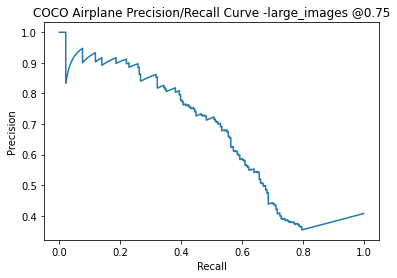

In [73]:
class_name='airplane'
xlabel = 'Recall'
ylabel = 'Precision'
title = 'COCO Airplane Precision/Recall Curve -large_images @' + str(iou_threshold)
save_fig_name = './model_evaluation_results/COCO-COCO/AIRPLANE_CLASS/coco_airplane_evaluation_result-PrecisionVsRecall_iou@' + str(iou_threshold) + '_large_images.png'
show_model_evaluation_result(model_eval_result_1,iou_threshold,class_name,xlabel,ylabel,title,save_fig_name)

#### Evaluation results for COCO-COCO with 10 epoch trained weights  @Iou 50% and 75%

In [74]:
try:
	C.model_path = './model_weights/COCO/coco_model_frcnn_airplane_vehicle_v1_0009.hdf5'
	print(f'Loading weights from {C.model_path}')
	model_rpn.load_weights(C.model_path, by_name=True)
	model_classifier.load_weights(C.model_path, by_name=True)    
	#model_rpn.load_weights('./resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)
	#model_classifier.load_weights('./resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5', by_name=True)
except Exception as e:
	print(f'Couldnt load pre-trained model due to {repr(e)}')

Loading weights from ./model_weights/COCO/coco_model_frcnn_airplane_vehicle_v1_0009.hdf5


In [75]:
model_rpn.compile(optimizer='sgd', loss='mse')
model_classifier_only.compile(optimizer='sgd', loss='mse')
model_classifier.compile(optimizer='sgd', loss='mse')

In [76]:
iou_threshold = 0.50
model_evaluation_report_name = './model_evaluation_results/COCO-COCO/AIRPLANE_CLASS/coco_airplane_evaluation_result_iou_' + str(iou_threshold) + '_large_images_10Epoch.csv'
model_eval_result, IoU = evaluate_model(test_imgs, iou_threshold, C, model_rpn, model_classifier_only,model_evaluation_report_name)

1/236
Elapsed time = 7.683562278747559
[{'x1': 288, 'x2': 432, 'y1': 64, 'y2': 144, 'class': 'airplane', 'prob': 0.9986469}]
[0.9986469]
IoU = 0.8016472212915599
key = airplane
airplane AP: 1.0
mAP = 1.0
{'airplane': [1]}
{'airplane': [0.9986469]}
2/236
Elapsed time = 2.846689224243164
[{'x1': 16, 'x2': 576, 'y1': 32, 'y2': 304, 'class': 'airplane', 'prob': 0.98959434}, {'x1': 16, 'x2': 368, 'y1': 16, 'y2': 240, 'class': 'airplane', 'prob': 0.66792214}]
[0.98959434 0.66792214]
IoU = 0.04919084914292812
IoU = 0.09502777675280256
key = airplane
airplane AP: 0.75
mAP = 0.75
{'airplane': [1, 0, 0, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0]}
3/236
Elapsed time = 2.8973419666290283
[]
[]
key = airplane
airplane AP: 0.7333333333333334
mAP = 0.7333333333333334
{'airplane': [1, 0, 0, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0]}
4/236
Elapsed time = 2.9679994583129883
[{'x1': 208, 'x2': 352, 'y1': 192, 'y2': 240, 'class': 'airplane', 'prob': 0.99658394}]
[0.9965839

Elapsed time = 5.362074136734009
[{'x1': 272, 'x2': 592, 'y1': 208, 'y2': 288, 'class': 'airplane', 'prob': 0.997265}]
[0.997265]
IoU = 0.8020581183519034
key = airplane
airplane AP: 0.873259808974095
mAP = 0.873259808974095
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087, 0.75299674, 0.9838192, 0.6608299, 0.9803529, 0.99480456, 0.74178517, 0, 0.72345597, 0, 0.8404805, 0.997265]}
22/236
Elapsed time = 4.631470203399658
[{'x1': 256, 'x2': 384, 'y1': 64, 'y2': 144, 'class': 'airplane', 'prob': 0.9970324}]
[0.9970324]
IoU = 0.8142716930209363
key = airplane
airplane AP: 0.8845212128519337
mAP = 0.8845212128519337
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.

Elapsed time = 4.944778680801392
[{'x1': 96, 'x2': 288, 'y1': 192, 'y2': 288, 'class': 'airplane', 'prob': 0.99559325}, {'x1': 112, 'x2': 224, 'y1': 208, 'y2': 288, 'class': 'airplane', 'prob': 0.6405057}]
[0.99559325 0.6405057 ]
IoU = 0.522882735477398
key = airplane
airplane AP: 0.9010095415787266
mAP = 0.9010095415787266
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087, 0.75299674, 0.9838192, 0.6608299, 0.9803529, 0.99480456, 0.74178517, 0, 0.72345597, 0, 0.8404805, 0.997265, 0.9970324, 0.70722294, 0.9941095, 0.9521807, 0.9460781, 0.7484795, 0.98702544, 0, 0.993251, 0.8885825, 0, 0.91899526, 0, 0.99559325, 0.6405057]}
35/236
Elapsed time = 4.78150200843811
[{'x1': 96, 'x2': 512, 'y1': 240, 'y2': 368, 'class': 'airplane', 'prob': 0.9891

Elapsed time = 5.344345569610596
[{'x1': 144, 'x2': 512, 'y1': 96, 'y2': 208, 'class': 'airplane', 'prob': 0.9670542}]
[0.9670542]
IoU = 0.6107911224337059
key = airplane
airplane AP: 0.8977846797555524
mAP = 0.8977846797555524
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087, 0.75299674, 0.9838192, 0.6608299, 0.9803529, 0.99480456, 0.74178517, 0, 0.72345597, 0, 0.8404805, 0.997265, 0.9970324, 0.70722294, 0.9941095, 0.9521807, 0.9460781, 0.7484795, 0.98702544, 0, 0.993251, 0.8885825, 0, 0.91899526, 0, 0.99559325, 0.6405057, 0.9891326, 0.66361874, 0.9605777, 0.9470563, 0.93583155, 0, 0.9896708, 0.82469994, 0.8975454, 0.96200705, 0, 0.9670542]}
45/236
Elapsed time = 4.8927085399627686
[{'x1': 64, 'x2': 43

Elapsed time = 5.1040871143341064
[{'x1': 112, 'x2': 496, 'y1': 144, 'y2': 240, 'class': 'airplane', 'prob': 0.9978671}]
[0.9978671]
IoU = 0.7776423242113356
key = airplane
airplane AP: 0.909559428190575
mAP = 0.909559428190575
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087, 0.75299674, 0.9838192, 0.6608299, 0.9803529, 0.99480456, 0.74178517, 0, 0.72345597, 0, 0.8404805, 0.997265, 0.9970324, 0.70722294, 0.9941095, 0.9521807, 0.9460781, 0.7484795, 0.98702544, 0, 0.993251, 0.8885825, 0, 0.91899526, 0, 0.99559325, 0.6405057, 0.9891326, 0.66361874, 0.9605777, 0.9470563, 0.93583155, 0, 0.9896708, 0.82469994, 0.8975454, 0.96200705, 0, 0.9670542, 0.9732063, 0.99758387, 0.9850

Elapsed time = 4.896076440811157
[{'x1': 96, 'x2': 560, 'y1': 128, 'y2': 240, 'class': 'airplane', 'prob': 0.99752396}]
[0.99752396]
IoU = 0.5820642436447323
key = airplane
airplane AP: 0.9174041547326062
mAP = 0.9174041547326062
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087, 0.75299674, 0.9838192, 0.6608299, 0.9803529, 0.99480456, 0.74178517, 0, 0.72345597, 0, 0.8404805, 0.997265, 0.9970324, 0.70722294, 0.9941095, 0.9521807, 0.9460781, 0.7484795, 0.98702544, 0, 0.993251, 0.8885825, 0, 0.91899526, 0, 0.99559325, 0.6405057, 0.9891326, 0.66361874, 0.9605777, 0.9470563, 0.93583155, 0, 0.9896708, 0.82469994, 0.8975454, 0.96200705, 0, 0.9670542, 0.9

Elapsed time = 5.057330846786499
[{'x1': 64, 'x2': 432, 'y1': 176, 'y2': 288, 'class': 'airplane', 'prob': 0.94834095}, {'x1': 176, 'x2': 576, 'y1': 176, 'y2': 288, 'class': 'airplane', 'prob': 0.58074826}]
[0.94834095 0.58074826]
IoU = 0.7087339221891187
key = airplane
airplane AP: 0.9268257683067789
mAP = 0.9268257683067789
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087, 0.75299674, 0.9838192, 0.6608299, 0.9803529, 0.99480456, 0.74178517, 0, 0.72345597, 0, 0.8404805, 0.997265, 0.9970324, 0.70722294, 0.9941095, 0.9521807, 0.9460781, 0.7484795, 0.98702544, 0, 0.993251, 0.8885825, 0, 0.91899526, 0, 0.99559325, 0.6405057, 0

Elapsed time = 4.815609931945801
[{'x1': -16, 'x2': 400, 'y1': 112, 'y2': 240, 'class': 'airplane', 'prob': 0.9990808}]
[0.9990808]
IoU = 0.7398017828051441
key = airplane
airplane AP: 0.9326420007350725
mAP = 0.9326420007350725
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087, 0.75299674, 0.9838192, 0.6608299, 0.9803529, 0.99480456, 0.74178517, 0, 0.72345597, 0, 0.8404805, 0.997265, 0.9970324, 0.70722294, 0.9941095, 0.9521807, 0.9460781, 0.7484795, 0.98702544, 0, 0.993251, 0.8885825, 0, 0.91899526, 0, 0.99559325, 0.6405057, 0.9891326, 0.66361874, 0.9605777, 0.9470563, 0.93583155, 0, 0.9896708, 0.824699

Elapsed time = 4.8707334995269775
[{'x1': 80, 'x2': 288, 'y1': 80, 'y2': 272, 'class': 'airplane', 'prob': 0.96840525}]
[0.96840525]
IoU = 0.9137764517192128
key = airplane
airplane AP: 0.9391777507193414
mAP = 0.9391777507193414
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087, 0.75299674, 0.9838192, 0.6608299, 0.9803529, 0.99480456, 0.74178517, 0, 0.72345597, 0, 0.8404805, 0.997265, 0.9970324, 0.70722294, 0.9941095, 0.9521807, 0.9460781, 0.7484795, 0.98702544, 0, 0.993251, 0.8885825, 0, 0.91899526, 0, 0.99559325, 0.6405057, 0.9891326, 0.66361874, 0.9605777, 0.9470563, 0.93583155, 0, 

Elapsed time = 5.0504419803619385
[{'x1': 16, 'x2': 608, 'y1': 48, 'y2': 288, 'class': 'airplane', 'prob': 0.9696111}]
[0.9696111]
IoU = 0.37039972152381667
key = airplane
airplane AP: 0.9342478538229056
mAP = 0.9342478538229056
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087, 0.75299674, 0.9838192, 0.6608299, 0.9803529, 0.99480456, 0.74178517, 0, 0.72345597, 0, 0.8404805, 0.997265, 0.9970324, 0.70722294, 0.9941095, 0.9521807, 0.9460781, 0.7484795, 0.98702544, 0, 0.993251, 0.8885825, 0, 0.91899526, 0, 0.99559325, 0.6405057, 0.9891326, 0.66361874, 0.9605777, 0.9

Elapsed time = 5.22601580619812
[{'x1': 160, 'x2': 608, 'y1': 224, 'y2': 368, 'class': 'airplane', 'prob': 0.99212474}]
[0.99212474]
IoU = 0.8723203362716068
key = airplane
airplane AP: 0.9383332237904618
mAP = 0.9383332237904618
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087, 0.75299674, 0.9838192, 0.6608299, 0.9803529, 0.99480456, 0.74178517, 0, 0.72345597, 0, 0.8404805, 0.997265, 0.9970324, 0.70722294, 0.9941095, 0.9521807, 0.9460781, 0.7484795, 0.98702544, 0, 0.993251, 0.8885825, 0, 0.91899526, 0, 0.99559325, 0.6405057, 0.9891326, 0.66

Elapsed time = 4.49753475189209
[{'x1': 48, 'x2': 528, 'y1': 128, 'y2': 272, 'class': 'airplane', 'prob': 0.99304056}]
[0.99304056]
IoU = 0.8779479540594046
key = airplane
airplane AP: 0.942850534577863
mAP = 0.942850534577863
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087, 0.75299674, 0.9838192, 0.6608299, 0.9803529, 0.99480456, 0.74178517, 0, 0.72345597, 0, 0.8404805, 0.997265, 0.9970324, 0.70722294, 0.9941095, 0.9521807, 0.9460781, 0.7484795, 0.98702544, 0, 0.993251, 0.8885825, 0, 0.91899526, 0, 0.99559325, 0.6405057, 0.9

Elapsed time = 5.813449859619141
[{'x1': 80, 'x2': 528, 'y1': 96, 'y2': 240, 'class': 'airplane', 'prob': 0.95806456}]
[0.95806456]
IoU = 0.9397191281088404
key = airplane
airplane AP: 0.9465449051137282
mAP = 0.9465449051137282
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087, 0.75299674, 0.9838192, 0.6608299, 0.9803529, 0.99480456, 0.74178517, 0, 0.72345597, 0, 0.8404805, 0.997265, 0.9970324, 0.70722294, 0.9941095, 0.9521807, 0.9460781, 0.7484795, 0.98702544, 0, 0.993251, 0.8885825, 0, 0.91899526, 0, 0.9955932

Elapsed time = 4.623685598373413
[{'x1': -16, 'x2': 560, 'y1': 128, 'y2': 272, 'class': 'airplane', 'prob': 0.9886029}]
[0.9886029]
IoU = 0.8119064658291032
key = airplane
airplane AP: 0.9512647993575672
mAP = 0.9512647993575672
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087, 0.75299674, 0.9838192, 0.6608299, 0.9803529, 0.99480456, 0.74178517, 0, 0.72345597, 0, 0.8404805, 0.997265, 0.9970324, 0.70722294, 0.9941095, 0.9521807, 0.9460781, 0.7484795, 0.98702544, 0, 0.993251, 0.8885825, 0, 0.9189952

Elapsed time = 4.679316997528076
[{'x1': 0, 'x2': 416, 'y1': 192, 'y2': 352, 'class': 'airplane', 'prob': 0.95446146}]
[0.95446146]
IoU = 0.8308483352739755
key = airplane
airplane AP: 0.9539080558370893
mAP = 0.9539080558370893
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087, 0.75299674, 0.9838192, 0.6608299, 0.9803529, 0.99480456, 0.74178517, 0, 0.72345597, 0, 0.8404805, 0.997265, 0.9970324, 0.70722294, 0.9941095, 0.9521807, 0.9460781, 0.7484795, 0.98702544, 0, 0.993251, 0.888582

Elapsed time = 5.43427038192749
[{'x1': 16, 'x2': 784, 'y1': 48, 'y2': 336, 'class': 'airplane', 'prob': 0.9957137}]
[0.9957137]
IoU = 0.6345868761018437
key = airplane
airplane AP: 0.9524948277146571
mAP = 0.9524948277146571
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087, 0.75299674, 0.9838192, 0.6608299, 0.9803529, 0.99480456, 0.74178517, 0, 0.72345597, 0, 0.8404805, 0.997265, 0.9970324, 0.70722294, 0.9941095, 0.9521807, 0.9460781, 0.7484795, 0.98702544, 0, 

Elapsed time = 4.9359400272369385
[{'x1': 336, 'x2': 624, 'y1': 80, 'y2': 288, 'class': 'airplane', 'prob': 0.78032124}, {'x1': 32, 'x2': 592, 'y1': 208, 'y2': 384, 'class': 'airplane', 'prob': 0.5265515}]
[0.78032124 0.5265515 ]
IoU = 0.6124964679757812
key = airplane
airplane AP: 0.9538109809098726
mAP = 0.9538109809098726
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087, 0.75299674, 0.9838192, 0.6608299, 0.9803529, 0.99480456, 0.74178517, 0, 0.

Elapsed time = 5.049649000167847
[{'x1': 144, 'x2': 464, 'y1': 80, 'y2': 320, 'class': 'airplane', 'prob': 0.99797803}]
[0.99797803]
IoU = 0.8878317734408971
key = airplane
airplane AP: 0.9559536866739963
mAP = 0.9559536866739963
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087, 0.75299674, 0.9838192, 0.6608299, 0.9803529, 0.99480456, 0.74178517, 0, 0.72345597, 0, 0.8404805, 0.997265, 0.9970324, 0.70722294, 0.9941095, 0.9521807, 0.9460

Elapsed time = 4.817329168319702
[{'x1': 16, 'x2': 496, 'y1': 96, 'y2': 272, 'class': 'airplane', 'prob': 0.97137386}]
[0.97137386]
IoU = 0.7902547077612698
key = airplane
airplane AP: 0.9557154403717406
mAP = 0.9557154403717406
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087, 0.75299674, 0.9838192, 0.6608299, 0.9803529, 0.99480456, 0.74178517, 0, 0.72345597, 0, 0.8404805, 0.997265, 0.9970324, 0.70722294, 0.9941095, 

Elapsed time = 5.311818599700928
[{'x1': 80, 'x2': 640, 'y1': 96, 'y2': 320, 'class': 'airplane', 'prob': 0.99163145}]
[0.99163145]
IoU = 0.5006266119128697
key = airplane
airplane AP: 0.9551132372816535
mAP = 0.9551132372816535
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087, 0.75299674, 0.9838192, 0.6608299, 0.9803529, 0.99480456, 0.74178517, 0, 0.72345597, 0, 0.8404805, 0.997265, 0.9970324, 0.707222

Elapsed time = 5.636695623397827
[{'x1': 0, 'x2': 624, 'y1': 128, 'y2': 272, 'class': 'airplane', 'prob': 0.9886163}]
[0.9886163]
IoU = 0.9562199697889789
key = airplane
airplane AP: 0.9570205461519654
mAP = 0.9570205461519654
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087, 0.75299674, 0.9838192, 0.6608299, 0.9803529, 0.99480456, 0.74178517, 0, 0.72345597, 0, 0.8404805, 0.997265, 0.9970324

Elapsed time = 5.569723606109619
[{'x1': -16, 'x2': 576, 'y1': 32, 'y2': 208, 'class': 'airplane', 'prob': 0.9997198}]
[0.9997198]
IoU = 0.8437820610624911
key = airplane
airplane AP: 0.9595270962838054
mAP = 0.9595270962838054
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087, 0.75299674, 0.9838192, 0.6608299, 0.9803529, 0.99480456, 0.74178517, 0, 0.72345597, 0, 0.8404805, 0.9972

Elapsed time = 5.076027154922485
[{'x1': -16, 'x2': 592, 'y1': 144, 'y2': 256, 'class': 'airplane', 'prob': 0.9731312}]
[0.9731312]
IoU = 0.6665845068313163
key = airplane
airplane AP: 0.9609776412330406
mAP = 0.9609776412330406
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087, 0.75299674, 0.9838192, 0.6608299, 0.9803529, 0.99480456, 0.74178517, 0, 0.72345597, 0, 0.84

Elapsed time = 5.028357028961182
[{'x1': 16, 'x2': 560, 'y1': 96, 'y2': 256, 'class': 'airplane', 'prob': 0.9985159}]
[0.9985159]
IoU = 0.8925262477364138
key = airplane
airplane AP: 0.9631261237719114
mAP = 0.9631261237719114
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087, 0.75299674, 0.9838192, 0.6608299, 0.9803529, 0.99480456, 0.74178517, 0, 0.7234559

Elapsed time = 4.952196836471558
[{'x1': 0, 'x2': 560, 'y1': 80, 'y2': 288, 'class': 'airplane', 'prob': 0.99849045}]
[0.99849045]
IoU = 0.8471688260067479
key = airplane
airplane AP: 0.9640803279834538
mAP = 0.9640803279834538
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087, 0.75299674, 0.9838192, 0.6608299, 0.9803529, 0.99480456, 0.74178517,

Elapsed time = 4.99115252494812
[{'x1': 64, 'x2': 288, 'y1': 96, 'y2': 240, 'class': 'airplane', 'prob': 0.6709745}]
[0.6709745]
IoU = 0.5918712426401559
key = airplane
airplane AP: 0.9650837737507437
mAP = 0.9650837737507437
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087, 0.75299674, 0.9838192, 0.6608299, 0.9803529, 0.99480456, 0

Elapsed time = 4.9959657192230225
[{'x1': 0, 'x2': 496, 'y1': 192, 'y2': 352, 'class': 'airplane', 'prob': 0.96576124}]
[0.96576124]
IoU = 0.5527222918015613
key = airplane
airplane AP: 0.9665236204520884
mAP = 0.9665236204520884
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087, 0.75299674, 0.9838192, 0.6608299, 0.980352

Elapsed time = 5.04690408706665
[{'x1': 160, 'x2': 576, 'y1': 64, 'y2': 240, 'class': 'airplane', 'prob': 0.98499227}, {'x1': 384, 'x2': 576, 'y1': 96, 'y2': 240, 'class': 'airplane', 'prob': 0.5457451}]
[0.98499227 0.5457451 ]
IoU = 0.6853193505251103
key = airplane
airplane AP: 0.9670223898928277
mAP = 0.9670223898928277
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0

Elapsed time = 5.114676237106323
[{'x1': 0, 'x2': 576, 'y1': 112, 'y2': 272, 'class': 'airplane', 'prob': 0.9990761}]
[0.9990761]
IoU = 0.6967773814570176
key = airplane
airplane AP: 0.9682377834554525
mAP = 0.9682377834554525
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087, 0.75299674, 0.9838192, 0

Elapsed time = 5.893012046813965
[{'x1': 0, 'x2': 560, 'y1': 16, 'y2': 368, 'class': 'airplane', 'prob': 0.9906324}, {'x1': 368, 'x2': 1312, 'y1': 64, 'y2': 352, 'class': 'airplane', 'prob': 0.9559662}, {'x1': -16, 'x2': 1040, 'y1': 48, 'y2': 352, 'class': 'airplane', 'prob': 0.91866827}]
[0.9906324  0.9559662  0.91866827]
IoU = 0.45554469011567467
IoU = 0.505381514949737
key = airplane
airplane AP: 0.9632013697236876
mAP = 0.9632013697236876
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

Elapsed time = 5.016452074050903
[{'x1': 32, 'x2': 576, 'y1': 112, 'y2': 304, 'class': 'airplane', 'prob': 0.9939169}]
[0.9939169]
IoU = 0.8267336859562983
key = airplane
airplane AP: 0.9641798306459155
mAP = 0.9641798306459155
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0, 0.9968087,

Elapsed time = 4.9962379932403564
[{'x1': 32, 'x2': 592, 'y1': 128, 'y2': 336, 'class': 'airplane', 'prob': 0.9987929}]
[0.9987929]
IoU = 0.8800969280101825
key = airplane
airplane AP: 0.962162411656873
mAP = 0.962162411656873
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79089975, 0,

Elapsed time = 4.891942262649536
[{'x1': 16, 'x2': 512, 'y1': 80, 'y2': 320, 'class': 'airplane', 'prob': 0.999721}]
[0.999721]
IoU = 0.8196323679695651
key = airplane
airplane AP: 0.9620914367039177
mAP = 0.9620914367039177
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5032645, 0, 0.79

Elapsed time = 6.158858060836792
[{'x1': -16, 'x2': 576, 'y1': 128, 'y2': 304, 'class': 'airplane', 'prob': 0.99816704}]
[0.99816704]
IoU = 0.8267950363701014
key = airplane
airplane AP: 0.9633282842997797
mAP = 0.9633282842997797
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0, 0.5

Elapsed time = 5.0267860889434814
[{'x1': 128, 'x2': 368, 'y1': 0, 'y2': 400, 'class': 'airplane', 'prob': 0.9867235}]
[0.9867235]
IoU = 0.658504806166153
key = airplane
airplane AP: 0.9642176389998187
mAP = 0.9642176389998187
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.9992281, 0.5850495, 0.95657194, 0

Elapsed time = 4.931215763092041
[{'x1': 128, 'x2': 656, 'y1': 96, 'y2': 416, 'class': 'airplane', 'prob': 0.9981244}, {'x1': 256, 'x2': 672, 'y1': 80, 'y2': 272, 'class': 'airplane', 'prob': 0.53035086}]
[0.9981244  0.53035086]
IoU = 0.7693674102003669
key = airplane
airplane AP: 0.964884278816009
mAP = 0.964884278816009
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]}
{'airpl

Elapsed time = 5.014391183853149
[{'x1': -16, 'x2': 608, 'y1': 96, 'y2': 400, 'class': 'airplane', 'prob': 0.98760146}]
[0.98760146]
IoU = 0.5905323371365298
key = airplane
airplane AP: 0.9648642425682025
mAP = 0.9648642425682025
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0.999228

Elapsed time = 5.221013069152832
[{'x1': -64, 'x2': 864, 'y1': 80, 'y2': 368, 'class': 'airplane', 'prob': 0.9446713}]
[0.9446713]
IoU = 0.7766978311866042
key = airplane
airplane AP: 0.9657002144511762
mAP = 0.9657002144511762
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.9986284, 0

Elapsed time = 4.78467583656311
[{'x1': 32, 'x2': 624, 'y1': 80, 'y2': 272, 'class': 'airplane', 'prob': 0.9915861}]
[0.9915861]
IoU = 0.7395977872779822
key = airplane
airplane AP: 0.966788461081566
mAP = 0.966788461081566
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658394, 0, 0.99862

Elapsed time = 5.112952709197998
[{'x1': 80, 'x2': 608, 'y1': -64, 'y2': 320, 'class': 'airplane', 'prob': 0.60749155}]
[0.60749155]
IoU = 0.5705087560738206
key = airplane
airplane AP: 0.9670075899576295
mAP = 0.9670075899576295
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0, 0.99658

Elapsed time = 4.82483983039856
[{'x1': 16, 'x2': 448, 'y1': 128, 'y2': 304, 'class': 'airplane', 'prob': 0.99976665}]
[0.99976665]
IoU = 0.7497973291319324
key = airplane
airplane AP: 0.9676956943909695
mAP = 0.9676956943909695
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.66792214, 0, 0,

Elapsed time = 4.861052513122559
[{'x1': -32, 'x2': 608, 'y1': 48, 'y2': 320, 'class': 'airplane', 'prob': 0.99801993}]
[0.99801993]
IoU = 0.8381677238477656
key = airplane
airplane AP: 0.963915491428216
mAP = 0.963915491428216
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1]}
{'airplane': [0.9986469, 0.98959434, 0.6679

Elapsed time = 5.033641815185547
[{'x1': -16, 'x2': 624, 'y1': 80, 'y2': 368, 'class': 'airplane', 'prob': 0.98813176}]
[0.98813176]
IoU = 0.7342810919688321
key = airplane
airplane AP: 0.9642683509194169
mAP = 0.9642683509194169
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1]}
{'airplane': [0.9986469, 0.98

Elapsed time = 5.251051902770996
[{'x1': 176, 'x2': 560, 'y1': 16, 'y2': 352, 'class': 'airplane', 'prob': 0.96850365}, {'x1': 224, 'x2': 512, 'y1': 0, 'y2': 128, 'class': 'airplane', 'prob': 0.95794415}]
[0.96850365 0.95794415]
IoU = 0.7613155060181642
key = airplane
airplane AP: 0.9630742545837359
mAP = 0.9630742545837359
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 

Elapsed time = 5.34730076789856
[{'x1': -64, 'x2': 656, 'y1': 48, 'y2': 320, 'class': 'airplane', 'prob': 0.99700004}, {'x1': 0, 'x2': 400, 'y1': 64, 'y2': 288, 'class': 'airplane', 'prob': 0.8712783}, {'x1': 240, 'x2': 608, 'y1': 48, 'y2': 336, 'class': 'airplane', 'prob': 0.66925704}]
[0.99700004 0.8712783  0.66925704]
IoU = 0.7745529013087664
key = airplane
airplane AP: 0.961714296469449
mAP = 0.961714296469449
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1

Elapsed time = 5.255666017532349
[{'x1': 0, 'x2': 624, 'y1': 32, 'y2': 368, 'class': 'airplane', 'prob': 0.9727173}]
[0.9727173]
IoU = 0.9801140666906024
key = airplane
airplane AP: 0.961521722750047
mAP = 0.961521722750047
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 

Elapsed time = 5.721221446990967
[{'x1': 64, 'x2': 688, 'y1': 80, 'y2': 384, 'class': 'airplane', 'prob': 0.775438}]
[0.775438]
IoU = 0.6639274522599077
key = airplane
airplane AP: 0.9609616879161444
mAP = 0.9609616879161444
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,

Elapsed time = 5.393210411071777
[{'x1': 48, 'x2': 592, 'y1': 144, 'y2': 448, 'class': 'airplane', 'prob': 0.9902892}, {'x1': 32, 'x2': 336, 'y1': 32, 'y2': 448, 'class': 'airplane', 'prob': 0.57390404}]
[0.9902892  0.57390404]
IoU = 0.5549846715469753
key = airplane
airplane AP: 0.9615958567132912
mAP = 0.9615958567132912
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0

Elapsed time = 5.218322038650513
[{'x1': -32, 'x2': 656, 'y1': 32, 'y2': 432, 'class': 'airplane', 'prob': 0.93089306}, {'x1': 256, 'x2': 624, 'y1': 80, 'y2': 432, 'class': 'airplane', 'prob': 0.7904784}]
[0.93089306 0.7904784 ]
IoU = 0.8010200858140845
key = airplane
airplane AP: 0.9613475358298474
mAP = 0.9613475358298474
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 

Elapsed time = 5.049236297607422
[{'x1': -32, 'x2': 624, 'y1': 64, 'y2': 320, 'class': 'airplane', 'prob': 0.98198557}]
[0.98198557]
IoU = 0.5383990833552568
key = airplane
airplane AP: 0.9604365054281087
mAP = 0.9604365054281087
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 

Elapsed time = 5.301952600479126
[{'x1': 32, 'x2': 416, 'y1': 0, 'y2': 416, 'class': 'airplane', 'prob': 0.9996207}]
[0.9996207]
IoU = 0.8907907729913757
key = airplane
airplane AP: 0.9612729409255407
mAP = 0.9612729409255407
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1

Elapsed time = 4.920812606811523
[{'x1': -16, 'x2': 368, 'y1': -16, 'y2': 464, 'class': 'airplane', 'prob': 0.92718047}]
[0.92718047]
IoU = 0.7359002663480089
key = airplane
airplane AP: 0.9612532811470635
mAP = 0.9612532811470635
{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,

In [79]:
model_eval_result

,ImageID,predict_bbox,gt_bbox,IoU_threshold,T,P,IoU,ap,mAP
0,COCO_extracted_dataset/large_airplane_for_test...,"[{'x1': 288, 'x2': 432, 'y1': 64, 'y2': 144, '...","[{'class': 'airplane', 'x1': 294.24, 'x2': 432...",0.5,"{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,...","{'airplane': [0.9986469, 0.98959434, 0.6679221...",0.801647,[1.0],1.000000
1,COCO_extracted_dataset/large_airplane_for_test...,"[{'x1': 16, 'x2': 576, 'y1': 32, 'y2': 304, 'c...","[{'class': 'airplane', 'x1': 132.21, 'x2': 288...",0.5,"{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,...","{'airplane': [0.9986469, 0.98959434, 0.6679221...",0.144219,[0.75],0.750000
2,COCO_extracted_dataset/large_airplane_for_test...,[],"[{'class': 'airplane', 'x1': 16.05, 'x2': 166....",0.5,"{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,...","{'airplane': [0.9986469, 0.98959434, 0.6679221...",0.000000,[0.7333333333333334],0.733333
3,COCO_extracted_dataset/large_airplane_for_test...,"[{'x1': 208, 'x2': 352, 'y1': 192, 'y2': 240, ...","[{'class': 'airplane', 'x1': 227.65, 'x2': 399...",0.5,"{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,...","{'airplane': [0.9986469, 0.98959434, 0.6679221...",0.756619,[0.8333333333333333],0.833333
4,COCO_extracted_dataset/large_airplane_for_test...,[],"[{'class': 'airplane', 'x1': 522.07, 'x2': 638...",0.5,"{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,...","{'airplane': [0.9986469, 0.98959434, 0.6679221...",0.000000,[0.8285714285714285],0.828571
...,...,...,...,...,...,...,...,...,...
231,COCO_extracted_dataset/large_airplane_for_test...,"[{'x1': 0, 'x2': 416, 'y1': -48, 'y2': 464, 'c...","[{'class': 'airplane', 'x1': 2.88, 'x2': 512.0...",0.5,"{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,...","{'airplane': [0.9986469, 0.98959434, 0.6679221...",0.885093,[0.9609202048417838],0.960920
232,COCO_extracted_dataset/large_airplane_for_test...,"[{'x1': 32, 'x2': 416, 'y1': 0, 'y2': 416, 'cl...","[{'class': 'airplane', 'x1': 5.57, 'x2': 557.3...",0.5,"{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,...","{'airplane': [0.9986469, 0.98959434, 0.6679221...",0.890791,[0.9612729409255407],0.961273
233,COCO_extracted_dataset/large_airplane_for_test...,[],"[{'class': 'airplane', 'x1': 0.0, 'x2': 640.0,...",0.5,"{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,...","{'airplane': [0.9986469, 0.98959434, 0.6679221...",0.000000,[0.9608255463230938],0.960826
234,COCO_extracted_dataset/large_airplane_for_test...,"[{'x1': -64, 'x2': 544, 'y1': -16, 'y2': 448, ...","[{'class': 'airplane', 'x1': 0.0, 'x2': 638.86...",0.5,"{'airplane': [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,...","{'airplane': [0.9986469, 0.98959434, 0.6679221...",0.656703,[0.9611757356514111],0.961176


In [80]:
print(f' IoU @ {iou_threshold} threshold = {IoU}')

 IoU @ 0.5 threshold = 0.6931858503418897


###### displaying the model evaluation result for object class = airplane @iou_threshold = 0.5
###### True probability = [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1]
###### Predict probability = [0.998646

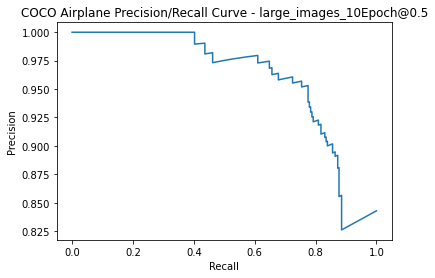

In [81]:
class_name='airplane'
xlabel = 'Recall'
ylabel = 'Precision'
title = 'COCO Airplane Precision/Recall Curve - large_images_10Epoch@' + str(iou_threshold)
save_fig_name = './model_evaluation_results/COCO-COCO/AIRPLANE_CLASS/coco_airplane_evaluation_result-PrecisionVsRecall_iou@' + str(iou_threshold) + '_large_images_10Epoch.png'
show_model_evaluation_result(model_eval_result,iou_threshold,class_name,xlabel,ylabel,title,save_fig_name)

In [82]:
iou_threshold = 0.75
model_evaluation_report_name = './model_evaluation_results/COCO-COCO/AIRPLANE_CLASS/coco_airplane_evaluation_result_iou_' + str(iou_threshold) + '_large_images_10Epoch.csv'
model_eval_result_1,IoU_1 = evaluate_model(test_imgs, iou_threshold, C, model_rpn, model_classifier_only,model_evaluation_report_name)

1/236
Elapsed time = 4.917920827865601
[{'x1': 288, 'x2': 432, 'y1': 64, 'y2': 144, 'class': 'airplane', 'prob': 0.9993318}, {'x1': 288, 'x2': 416, 'y1': 64, 'y2': 128, 'class': 'airplane', 'prob': 0.7661063}]
[0.9993318 0.7661063]
IoU = 0.8016472212915599
key = airplane
airplane AP: 1.0
mAP = 1.0
{'airplane': [1, 0]}
{'airplane': [0.9993318, 0.7661063]}
2/236
Elapsed time = 5.031322002410889
[{'x1': 16, 'x2': 592, 'y1': 0, 'y2': 384, 'class': 'airplane', 'prob': 0.99406034}, {'x1': 16, 'x2': 576, 'y1': 32, 'y2': 304, 'class': 'airplane', 'prob': 0.98959434}, {'x1': 16, 'x2': 448, 'y1': 0, 'y2': 240, 'class': 'airplane', 'prob': 0.9887982}, {'x1': 32, 'x2': 448, 'y1': 0, 'y2': 384, 'class': 'airplane', 'prob': 0.9849589}, {'x1': 32, 'x2': 496, 'y1': 16, 'y2': 288, 'class': 'airplane', 'prob': 0.9784963}, {'x1': 16, 'x2': 528, 'y1': 32, 'y2': 240, 'class': 'airplane', 'prob': 0.89898}, {'x1': -16, 'x2': 480, 'y1': 16, 'y2': 352, 'class': 'airplane', 'prob': 0.85889083}, {'x1': 144, 'x2'

Elapsed time = 5.382132291793823
[{'x1': 80, 'x2': 304, 'y1': 224, 'y2': 288, 'class': 'airplane', 'prob': 0.9575711}, {'x1': 96, 'x2': 320, 'y1': 224, 'y2': 304, 'class': 'airplane', 'prob': 0.8223632}]
[0.9575711 0.8223632]
IoU = 0.6954782193259601
key = airplane
airplane AP: 0.5893965683439368
mAP = 0.5893965683439368
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0]}
{'airplane': [0.9993318, 0.7661063, 0.99406034, 0.98959434, 0.9887982, 0.9849589, 0.9784963, 0.89898, 0.85889083, 0.76409274, 0.6174902, 0, 0, 0.99658394, 0, 0.99881375, 0.9986284, 0.9992281, 0.979259, 0.9196042, 0.9013441, 0.8571283, 0.67239565, 0.5850495, 0.9711231, 0, 0.5032645, 0, 0.79089975, 0.72188336, 0.51080865, 0, 0.9996201, 0.99688536, 0.88201505, 0.7275123, 0.9575711, 0.8223632]}
14/236
Elapsed time = 5.049849987030029
[{'x1': 224, 'x2': 448, 'y1': 32, 'y2': 112, 'class': 'airplane', 'prob': 0.9987147}, {'x1': 240, 'x2': 464, 'y1':

Elapsed time = 4.7196290493011475
[{'x1': 256, 'x2': 384, 'y1': 64, 'y2': 144, 'class': 'airplane', 'prob': 0.9970324}, {'x1': 240, 'x2': 368, 'y1': 64, 'y2': 128, 'class': 'airplane', 'prob': 0.86709374}]
[0.9970324  0.86709374]
IoU = 0.8142716930209363
key = airplane
airplane AP: 0.6386676032481907
mAP = 0.6386676032481907
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0]}
{'airplane': [0.9993318, 0.7661063, 0.99406034, 0.98959434, 0.9887982, 0.9849589, 0.9784963, 0.89898, 0.85889083, 0.76409274, 0.6174902, 0, 0, 0.99658394, 0, 0.99881375, 0.9986284, 0.9992281, 0.979259, 0.9196042, 0.9013441, 0.8571283, 0.67239565, 0.5850495, 0.9711231, 0, 0.5032645, 0, 0.79089975, 0.72188336, 0.51080865, 0, 0.9996201, 0.99688536, 0.88201505, 0.7275123, 0.9575711, 0.8223632, 0.9987147, 0.97772425, 0.79328656, 0.9803529, 0.750268, 0.9936336, 0.9857941, 0.8024027, 0.

Elapsed time = 4.484087705612183
[]
[]
key = airplane
airplane AP: 0.6717082859529147
mAP = 0.6717082859529147
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1]}
{'airplane': [0.9993318, 0.7661063, 0.99406034, 0.98959434, 0.9887982, 0.9849589, 0.9784963, 0.89898, 0.85889083, 0.76409274, 0.6174902, 0, 0, 0.99658394, 0, 0.99881375, 0.9986284, 0.9992281, 0.979259, 0.9196042, 0.9013441, 0.8571283, 0.67239565, 0.5850495, 0.9711231, 0, 0.5032645, 0, 0.79089975, 0.72188336, 0.51080865, 0, 0.9996201, 0.99688536, 0.88201505, 0.7275123, 0.9575711, 0.8223632, 0.9987147, 0.97772425, 0.79328656, 0.9803529, 0.750268, 0.9936336, 0.9857941, 0.8024027, 0.74178517, 0.98124963, 0.72345597, 0, 0.8404805, 0.71507025, 0.997265, 0.85783345, 0.7442744, 0.5664721, 0.9970324, 0.86709374, 0.94623685, 0.8926998, 0.519315, 0.999

Elapsed time = 5.050709962844849
[{'x1': 80, 'x2': 512, 'y1': 240, 'y2': 352, 'class': 'airplane', 'prob': 0.9984382}, {'x1': 96, 'x2': 512, 'y1': 256, 'y2': 368, 'class': 'airplane', 'prob': 0.9981552}]
[0.9984382 0.9981552]
IoU = 0.5794990855461272
key = airplane
airplane AP: 0.652333915425169
mAP = 0.652333915425169
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0]}
{'airplane': [0.9993318, 0.7661063, 0.99406034, 0.98959434, 0.9887982, 0.9849589, 0.9784963, 0.89898, 0.85889083, 0.76409274, 0.6174902, 0, 0, 0.99658394, 0, 0.99881375, 0.9986284, 0.9992281, 0.979259, 0.9196042, 0.9013441, 0.8571283, 0.67239565, 0.5850495, 0.9711231, 0, 0.5032645, 0, 0.79089975, 0.72188336, 0.51080865, 0, 0.9996201, 0.99688536, 0.88201505, 0.7275123, 0.9575711, 0.8223632

Elapsed time = 4.816144227981567
[{'x1': 144, 'x2': 512, 'y1': 144, 'y2': 256, 'class': 'airplane', 'prob': 0.9075349}, {'x1': 144, 'x2': 496, 'y1': 128, 'y2': 224, 'class': 'airplane', 'prob': 0.82469994}]
[0.9075349  0.82469994]
IoU = 0.7160222465187642
key = airplane
airplane AP: 0.6357823137358911
mAP = 0.6357823137358911
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0]}
{'airplane': [0.9993318, 0.7661063, 0.99406034, 0.98959434, 0.9887982, 0.9849589, 0.9784963, 0.89898, 0.85889083, 0.76409274, 0.6174902, 0, 0, 0.99658394, 0, 0.99881375, 0.9986284, 0.9992281, 0.979259, 0.9196042, 0.9013441, 0.8571283, 0.67239565, 0.5850495, 0.9711231, 0, 0.5032645, 0, 0.79089975, 0.72188336, 0.510808

Elapsed time = 4.887571811676025
[{'x1': 64, 'x2': 432, 'y1': 176, 'y2': 288, 'class': 'airplane', 'prob': 0.9949994}]
[0.9949994]
IoU = 0.6945836964112901
key = airplane
airplane AP: 0.6430588067850643
mAP = 0.6430588067850643
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1]}
{'airplane': [0.9993318, 0.7661063, 0.99406034, 0.98959434, 0.9887982, 0.9849589, 0.9784963, 0.89898, 0.85889083, 0.76409274, 0.6174902, 0, 0, 0.99658394, 0, 0.99881375, 0.9986284, 0.9992281, 0.979259, 0.9196042, 0.9013441, 0.8571283, 0.67239565, 0.5850495, 0.9711231, 0, 0.5032645, 0, 0.79089975, 0.72188336, 0.51080865, 0, 0.9996201, 0.99688536, 0.88201505, 0.7275123, 0.957571

Elapsed time = 4.940038681030273
[{'x1': 16, 'x2': 512, 'y1': 176, 'y2': 272, 'class': 'airplane', 'prob': 0.9928576}, {'x1': 80, 'x2': 512, 'y1': 192, 'y2': 288, 'class': 'airplane', 'prob': 0.5024771}]
[0.9928576 0.5024771]
IoU = 0.7834550952177974
key = airplane
airplane AP: 0.6552363249026671
mAP = 0.6552363249026671
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0]}
{'airplane': [0.9993318, 0.7661063, 0.99406034, 0.98959434, 0.9887982, 0.9849589, 0.9784963, 0.89898, 0.85889083, 0.76409274, 0.6174902, 0, 0, 0.99658394, 0, 0.99881375, 0.9986284, 0.9992281, 0.979259, 0.9196042, 0.9013441, 0.8571283, 0.67239565, 0.58

Elapsed time = 4.639573574066162
[{'x1': 112, 'x2': 496, 'y1': 144, 'y2': 240, 'class': 'airplane', 'prob': 0.9978671}]
[0.9978671]
IoU = 0.7776423242113356
key = airplane
airplane AP: 0.6881837901079484
mAP = 0.6881837901079484
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1]}
{'airplane': [0.9993318, 0.7661063, 0.99406034, 0.98959434, 0.9887982, 0.9849589, 0.9784963, 0.89898, 0.85889083, 0.76409274, 0.6174902, 0, 0, 0.99658394, 0, 0.99881375, 0.9986284, 0.9992281, 0.979259, 0.9196042, 0.9013441, 0.8571283, 0.67239565, 0.5850495, 0.9711231, 0, 0.5032645, 0, 0.79089975, 0.72188336, 0.51080865, 0,

Elapsed time = 5.030563831329346
[]
[]
key = airplane
airplane AP: 0.6772506298749132
mAP = 0.6772506298749132
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1]}
{'airplane': [0.9993318, 0.7661063, 0.99406034, 0.98959434, 0.9887982, 0.9849589, 0.9784963, 0.89898, 0.85889083, 0.76409274, 0.6174902, 0, 0, 0.99658394, 0, 0.99881375, 0.9986284, 0.9992281, 0.979259, 0.9196042, 0.9013441, 0.8571283, 0.67239565, 0.5850495, 0.9711231, 0, 0.5032645, 0, 0.79089975, 0.72188336, 0.51080865, 0, 0.9996201, 0.99688536, 0.88201505, 0.7275123, 0.9575711, 0.8223632, 0.9987147, 0.97772425, 0.79328656, 0.

Elapsed time = 4.818877696990967
[{'x1': 96, 'x2': 560, 'y1': 128, 'y2': 240, 'class': 'airplane', 'prob': 0.99752396}, {'x1': 80, 'x2': 528, 'y1': 112, 'y2': 224, 'class': 'airplane', 'prob': 0.9963977}, {'x1': 112, 'x2': 448, 'y1': 112, 'y2': 224, 'class': 'airplane', 'prob': 0.94928217}, {'x1': 160, 'x2': 496, 'y1': 112, 'y2': 240, 'class': 'airplane', 'prob': 0.90368825}]
[0.99752396 0.9963977  0.94928217 0.90368825]
IoU = 0.5820642436447323
key = airplane
airplane AP: 0.687477901583697
mAP = 0.687477901583697
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1

Elapsed time = 4.917982339859009
[{'x1': 112, 'x2': 560, 'y1': 128, 'y2': 240, 'class': 'airplane', 'prob': 0.998343}]
[0.998343]
IoU = 0.7629574672972383
key = airplane
airplane AP: 0.7092734489834855
mAP = 0.7092734489834855
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1]}
{'airplane': [0.9993318, 0.7661063, 0.99406034, 0.98959434, 0.9887982, 0.9849589, 0.9784963, 0.89898, 0.85889083, 0.76409274, 0.6174902, 0, 0, 0.99658394, 0, 0.99881375, 0.9986284, 0.9992281, 0.979259, 0.9196042, 0.9013441, 0.8571283, 0.67239565, 0.5850495,

Elapsed time = 5.042448997497559
[{'x1': 256, 'x2': 528, 'y1': 128, 'y2': 320, 'class': 'airplane', 'prob': 0.9938929}]
[0.9938929]
IoU = 0.9155523885583492
key = airplane
airplane AP: 0.724221593076027
mAP = 0.724221593076027
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1]}
{'airplane': [0.9993318, 0.7661063, 0.99406034, 0.98959434, 0.9887982, 0.9849589, 0.9784963, 0.89898, 0.85889083, 0.76409274, 0.6174902, 0, 0, 0.99658394, 0, 0.99881375, 0.9986284, 0.9992281, 0.979259, 0.9196042, 0.9013441, 0.8

Elapsed time = 5.093987464904785
[{'x1': -32, 'x2': 304, 'y1': 0, 'y2': 128, 'class': 'airplane', 'prob': 0.9983103}, {'x1': -32, 'x2': 336, 'y1': 0, 'y2': 96, 'class': 'airplane', 'prob': 0.97766143}, {'x1': -16, 'x2': 320, 'y1': -16, 'y2': 112, 'class': 'airplane', 'prob': 0.9556593}]
[0.9983103  0.97766143 0.9556593 ]
IoU = 0.757271354506183
key = airplane
airplane AP: 0.7303122873677625
mAP = 0.7303122873677625
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0]}

Elapsed time = 5.030847787857056
[{'x1': 64, 'x2': 528, 'y1': 144, 'y2': 288, 'class': 'airplane', 'prob': 0.9977858}, {'x1': 144, 'x2': 512, 'y1': 144, 'y2': 320, 'class': 'airplane', 'prob': 0.62883824}, {'x1': 80, 'x2': 416, 'y1': 176, 'y2': 304, 'class': 'airplane', 'prob': 0.50299406}]
[0.9977858  0.62883824 0.50299406]
IoU = 0.6939325768008993
key = airplane
airplane AP: 0.7430398028904314
mAP = 0.7430398028904314
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0

Elapsed time = 5.222936630249023
[{'x1': 64, 'x2': 368, 'y1': 96, 'y2': 320, 'class': 'airplane', 'prob': 0.96652067}, {'x1': 80, 'x2': 416, 'y1': 112, 'y2': 352, 'class': 'airplane', 'prob': 0.94519305}, {'x1': 48, 'x2': 384, 'y1': 96, 'y2': 368, 'class': 'airplane', 'prob': 0.8967571}]
[0.96652067 0.94519305 0.8967571 ]
IoU = 0.6353743979873103
key = airplane
airplane AP: 0.7418800021204457
mAP = 0.7418800021204457
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0

Elapsed time = 5.4459850788116455
[{'x1': 192, 'x2': 608, 'y1': 80, 'y2': 288, 'class': 'airplane', 'prob': 0.99817145}]
[0.99817145]
IoU = 0.8046418715649472
key = airplane
airplane AP: 0.7473094706946772
mAP = 0.7473094706946772
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1]}
{'airplane': [0.9993318, 0.7661063, 0.99406034, 0.98959434, 0.9887982, 0.9849589, 0.9784963, 0.89898, 0.85889083, 0.76409274, 0.61

Elapsed time = 5.068640947341919
[{'x1': 16, 'x2': 432, 'y1': 160, 'y2': 288, 'class': 'airplane', 'prob': 0.9990527}, {'x1': 32, 'x2': 192, 'y1': 176, 'y2': 272, 'class': 'airplane', 'prob': 0.84266806}]
[0.9990527  0.84266806]
IoU = 0.8742685482603861
key = airplane
airplane AP: 0.7543568681093236
mAP = 0.7543568681093236
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0]}
{'airplane': [0.9

Elapsed time = 4.966970920562744
[{'x1': 144, 'x2': 496, 'y1': 96, 'y2': 288, 'class': 'airplane', 'prob': 0.9914274}]
[0.9914274]
IoU = 0.595057962339805
key = airplane
airplane AP: 0.7561570524782122
mAP = 0.7561570524782122
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1]}
{'airplane': [0.9993318, 0.7661063, 0.99406034, 0.98959434, 0.9887982, 0.9849589, 0.9784963, 0.898

Elapsed time = 5.395812749862671
[{'x1': 320, 'x2': 544, 'y1': 48, 'y2': 96, 'class': 'airplane', 'prob': 0.551359}]
[0.551359]
IoU = 0.15004922057289563
key = airplane
airplane AP: 0.7588355421808347
mAP = 0.7588355421808347
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1]}
{'airplane': [0.9993318, 0.7661063, 0.99406034, 0.98959434, 0.9887982, 0.9849589, 0.978

Elapsed time = 4.980453968048096
[{'x1': 80, 'x2': 592, 'y1': 160, 'y2': 304, 'class': 'airplane', 'prob': 0.9935649}]
[0.9935649]
IoU = 0.7816834432015771
key = airplane
airplane AP: 0.7685345081770693
mAP = 0.7685345081770693
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1]}
{'airplane': [0.9993318, 0.7661063, 0.99406034, 0.98959434, 0.9887982, 0.

Elapsed time = 5.253015041351318
[{'x1': 112, 'x2': 752, 'y1': 32, 'y2': 208, 'class': 'airplane', 'prob': 0.94953626}, {'x1': 64, 'x2': 720, 'y1': 48, 'y2': 240, 'class': 'airplane', 'prob': 0.9434471}, {'x1': 112, 'x2': 624, 'y1': 64, 'y2': 208, 'class': 'airplane', 'prob': 0.91834253}, {'x1': 48, 'x2': 528, 'y1': 64, 'y2': 192, 'class': 'airplane', 'prob': 0.8676511}, {'x1': 128, 'x2': 816, 'y1': 48, 'y2': 224, 'class': 'airplane', 'prob': 0.82763475}, {'x1': 48, 'x2': 592, 'y1': 48, 'y2': 224, 'class': 'airplane', 'prob': 0.7044357}, {'x1': 304, 'x2': 768, 'y1': 48, 'y2': 224, 'class': 'airplane', 'prob': 0.61306167}, {'x1': 32, 'x2': 432, 'y1': 64, 'y2': 208, 'class': 'airplane', 'prob': 0.5774147}]
[0.94953626 0.9434471  0.91834253 0.8676511  0.82763475 0.7044357
 0.61306167 0.5774147 ]
IoU = 0.5876671253179984
key = airplane
airplane AP: 0.7737973144322574
mAP = 0.7737973144322574
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0

Elapsed time = 5.041086435317993
[{'x1': 64, 'x2': 480, 'y1': 144, 'y2': 288, 'class': 'airplane', 'prob': 0.9992636}, {'x1': 48, 'x2': 512, 'y1': 128, 'y2': 272, 'class': 'airplane', 'prob': 0.9862271}, {'x1': 96, 'x2': 416, 'y1': 144, 'y2': 304, 'class': 'airplane', 'prob': 0.63347703}, {'x1': 80, 'x2': 384, 'y1': 128, 'y2': 288, 'class': 'airplane', 'prob': 0.52928984}]
[0.9992636  0.9862271  0.63347703 0.52928984]
IoU = 0.9165040160769653
key = airplane
airplane AP: 0.7771167612868466
mAP = 0.7771167612868466
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1,

Elapsed time = 4.650392293930054
[{'x1': 64, 'x2': 544, 'y1': 96, 'y2': 256, 'class': 'airplane', 'prob': 0.99853635}, {'x1': 80, 'x2': 512, 'y1': 80, 'y2': 240, 'class': 'airplane', 'prob': 0.97976947}]
[0.99853635 0.97976947]
IoU = 0.7919351622552644
key = airplane
airplane AP: 0.7827009463023837
mAP = 0.7827009463023837
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1

Elapsed time = 5.081664085388184
[{'x1': 112, 'x2': 736, 'y1': 160, 'y2': 336, 'class': 'airplane', 'prob': 0.9995322}, {'x1': 64, 'x2': 688, 'y1': 144, 'y2': 320, 'class': 'airplane', 'prob': 0.99926263}, {'x1': 64, 'x2': 576, 'y1': 160, 'y2': 336, 'class': 'airplane', 'prob': 0.9938638}, {'x1': 208, 'x2': 672, 'y1': 160, 'y2': 320, 'class': 'airplane', 'prob': 0.8118429}, {'x1': 160, 'x2': 592, 'y1': 144, 'y2': 320, 'class': 'airplane', 'prob': 0.79265445}]
[0.9995322  0.99926263 0.9938638  0.8118429  0.79265445]
IoU = 0.7593998969311566
key = airplane
airplane AP: 0.7724905393315527
mAP = 0.7724905393315527
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,

Elapsed time = 4.68752121925354
[{'x1': 16, 'x2': 544, 'y1': 128, 'y2': 272, 'class': 'airplane', 'prob': 0.9990901}]
[0.9990901]
IoU = 0.8857161445398691
key = airplane
airplane AP: 0.7789219836552438
mAP = 0.7789219836552438
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 

Elapsed time = 4.983210325241089
[{'x1': 320, 'x2': 624, 'y1': 48, 'y2': 304, 'class': 'airplane', 'prob': 0.965657}]
[0.965657]
IoU = 0.8410916977894618
key = airplane
airplane AP: 0.7850238186671792
mAP = 0.7850238186671792
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0

Elapsed time = 5.009803771972656
[{'x1': 16, 'x2': 544, 'y1': 32, 'y2': 176, 'class': 'airplane', 'prob': 0.9994024}, {'x1': 0, 'x2': 400, 'y1': 32, 'y2': 160, 'class': 'airplane', 'prob': 0.9395587}, {'x1': 16, 'x2': 432, 'y1': 48, 'y2': 192, 'class': 'airplane', 'prob': 0.7036169}]
[0.9994024 0.9395587 0.7036169]
IoU = 0.9484249223173089
key = airplane
airplane AP: 0.7934751562957546
mAP = 0.7934751562957546
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1,

Elapsed time = 4.6438398361206055
[{'x1': -48, 'x2': 576, 'y1': 16, 'y2': 304, 'class': 'airplane', 'prob': 0.99077624}, {'x1': -48, 'x2': 496, 'y1': -16, 'y2': 384, 'class': 'airplane', 'prob': 0.9907137}, {'x1': -80, 'x2': 480, 'y1': 0, 'y2': 256, 'class': 'airplane', 'prob': 0.8876509}, {'x1': -16, 'x2': 352, 'y1': -16, 'y2': 368, 'class': 'airplane', 'prob': 0.8809034}, {'x1': 96, 'x2': 560, 'y1': 48, 'y2': 416, 'class': 'airplane', 'prob': 0.7933921}, {'x1': 192, 'x2': 544, 'y1': 48, 'y2': 448, 'class': 'airplane', 'prob': 0.5701263}]
[0.99077624 0.9907137  0.8876509  0.8809034  0.7933921  0.5701263 ]
IoU = 0.5237306676884437
key = airplane
airplane AP: 0.7943888176750478
mAP = 0.7943888176750478
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,

Elapsed time = 5.1763622760772705
[{'x1': 48, 'x2': 800, 'y1': 80, 'y2': 336, 'class': 'airplane', 'prob': 0.99995875}, {'x1': 16, 'x2': 672, 'y1': 96, 'y2': 336, 'class': 'airplane', 'prob': 0.9890708}, {'x1': 144, 'x2': 816, 'y1': 112, 'y2': 336, 'class': 'airplane', 'prob': 0.9727557}, {'x1': 32, 'x2': 544, 'y1': 80, 'y2': 320, 'class': 'airplane', 'prob': 0.9525705}, {'x1': 240, 'x2': 768, 'y1': 112, 'y2': 320, 'class': 'airplane', 'prob': 0.88428485}]
[0.99995875 0.9890708  0.9727557  0.9525705  0.88428485]
IoU = 0.7400066638114798
key = airplane
airplane AP: 0.7930256822993866
mAP = 0.7930256822993866
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,

Elapsed time = 5.137369632720947
[{'x1': 64, 'x2': 592, 'y1': 80, 'y2': 240, 'class': 'airplane', 'prob': 0.9995433}, {'x1': 80, 'x2': 560, 'y1': 64, 'y2': 224, 'class': 'airplane', 'prob': 0.9995167}, {'x1': 176, 'x2': 576, 'y1': 80, 'y2': 224, 'class': 'airplane', 'prob': 0.8994581}, {'x1': 128, 'x2': 496, 'y1': 64, 'y2': 208, 'class': 'airplane', 'prob': 0.66406435}, {'x1': 16, 'x2': 592, 'y1': 96, 'y2': 224, 'class': 'airplane', 'prob': 0.52776736}]
[0.9995433  0.9995167  0.8994581  0.66406435 0.52776736]
IoU = 0.6878138524467835
key = airplane
airplane AP: 0.781226158802368
mAP = 0.781226158802368
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1

Elapsed time = 5.17188572883606
[{'x1': 208, 'x2': 608, 'y1': 16, 'y2': 368, 'class': 'airplane', 'prob': 0.8617662}, {'x1': 80, 'x2': 656, 'y1': 80, 'y2': 384, 'class': 'airplane', 'prob': 0.8592924}, {'x1': 192, 'x2': 608, 'y1': 48, 'y2': 304, 'class': 'airplane', 'prob': 0.79119384}, {'x1': 320, 'x2': 608, 'y1': 80, 'y2': 304, 'class': 'airplane', 'prob': 0.78175616}, {'x1': 240, 'x2': 608, 'y1': 96, 'y2': 320, 'class': 'airplane', 'prob': 0.7795788}, {'x1': 336, 'x2': 640, 'y1': 16, 'y2': 304, 'class': 'airplane', 'prob': 0.65366524}, {'x1': 64, 'x2': 528, 'y1': 208, 'y2': 400, 'class': 'airplane', 'prob': 0.6455318}, {'x1': 128, 'x2': 624, 'y1': 0, 'y2': 320, 'class': 'airplane', 'prob': 0.61875975}, {'x1': 80, 'x2': 592, 'y1': 160, 'y2': 384, 'class': 'airplane', 'prob': 0.6154259}, {'x1': 176, 'x2': 352, 'y1': 0, 'y2': 48, 'class': 'airplane', 'prob': 0.51170105}]
[0.8617662  0.8592924  0.79119384 0.78175616 0.7795788  0.65366524
 0.6455318  0.61875975 0.6154259  0.51170105]
IoU

Elapsed time = 4.8191187381744385
[{'x1': -16, 'x2': 560, 'y1': 240, 'y2': 416, 'class': 'airplane', 'prob': 0.998855}, {'x1': -16, 'x2': 512, 'y1': 256, 'y2': 400, 'class': 'airplane', 'prob': 0.98669577}]
[0.998855   0.98669577]
IoU = 0.8094376852851596
key = airplane
airplane AP: 0.7796814442680664
mAP = 0.7796814442680664
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1

Elapsed time = 4.31199312210083
[{'x1': 144, 'x2': 480, 'y1': 80, 'y2': 320, 'class': 'airplane', 'prob': 0.9972957}, {'x1': 128, 'x2': 496, 'y1': 96, 'y2': 288, 'class': 'airplane', 'prob': 0.9854999}, {'x1': 96, 'x2': 480, 'y1': 96, 'y2': 352, 'class': 'airplane', 'prob': 0.5613577}]
[0.9972957 0.9854999 0.5613577]
IoU = 0.9030074966765291
key = airplane
airplane AP: 0.7821344186764473
mAP = 0.7821344186764473
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 

Elapsed time = 4.7249062061309814
[{'x1': 80, 'x2': 416, 'y1': 160, 'y2': 336, 'class': 'airplane', 'prob': 0.8299676}]
[0.8299676]
IoU = 0.6637860586686616
key = airplane
airplane AP: 0.7791367925758843
mAP = 0.7791367925758843
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1

Elapsed time = 4.882539510726929
[{'x1': 32, 'x2': 496, 'y1': 96, 'y2': 288, 'class': 'airplane', 'prob': 0.99896765}]
[0.99896765]
IoU = 0.8214328835386926
key = airplane
airplane AP: 0.7831066736486149
mAP = 0.7831066736486149
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1

Elapsed time = 4.491129159927368
[{'x1': 288, 'x2': 576, 'y1': -16, 'y2': 176, 'class': 'airplane', 'prob': 0.9941521}, {'x1': 272, 'x2': 544, 'y1': 0, 'y2': 192, 'class': 'airplane', 'prob': 0.94470924}, {'x1': 336, 'x2': 544, 'y1': -16, 'y2': 192, 'class': 'airplane', 'prob': 0.8512494}, {'x1': 208, 'x2': 544, 'y1': 0, 'y2': 144, 'class': 'airplane', 'prob': 0.6462827}]
[0.9941521  0.94470924 0.8512494  0.6462827 ]
IoU = 0.6147512907474015
key = airplane
airplane AP: 0.7802289158188841
mAP = 0.7802289158188841
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 

Elapsed time = 4.954452037811279
[{'x1': 48, 'x2': 640, 'y1': 96, 'y2': 336, 'class': 'airplane', 'prob': 0.9896103}, {'x1': 112, 'x2': 608, 'y1': 80, 'y2': 320, 'class': 'airplane', 'prob': 0.9335575}]
[0.9896103 0.9335575]
IoU = 0.4434979230281401
IoU = 0.5746713822199848
key = airplane
airplane AP: 0.7800130623764517
mAP = 0.7800130623764517
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 

Elapsed time = 4.503437042236328
[{'x1': 80, 'x2': 496, 'y1': 128, 'y2': 336, 'class': 'airplane', 'prob': 0.99985063}, {'x1': 128, 'x2': 480, 'y1': 144, 'y2': 368, 'class': 'airplane', 'prob': 0.75066245}]
[0.99985063 0.75066245]
IoU = 0.8629310349317263
key = airplane
airplane AP: 0.7843792499551531
mAP = 0.7843792499551531
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1

Elapsed time = 4.724963188171387
[{'x1': -32, 'x2': 624, 'y1': 128, 'y2': 272, 'class': 'airplane', 'prob': 0.9992618}, {'x1': 32, 'x2': 512, 'y1': 144, 'y2': 288, 'class': 'airplane', 'prob': 0.9525895}]
[0.9992618 0.9525895]
IoU = 0.9099159401145624
key = airplane
airplane AP: 0.7861052922592653
mAP = 0.7861052922592653
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,

Elapsed time = 4.6878297328948975
[{'x1': 32, 'x2': 608, 'y1': 48, 'y2': 256, 'class': 'airplane', 'prob': 0.9994856}, {'x1': 112, 'x2': 592, 'y1': 64, 'y2': 272, 'class': 'airplane', 'prob': 0.9344675}, {'x1': 128, 'x2': 576, 'y1': 48, 'y2': 240, 'class': 'airplane', 'prob': 0.864181}]
[0.9994856 0.9344675 0.864181 ]
IoU = 0.8611228365501961
key = airplane
airplane AP: 0.7901455488550799
mAP = 0.7901455488550799
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,

Elapsed time = 4.708444595336914
[{'x1': -16, 'x2': 576, 'y1': 32, 'y2': 208, 'class': 'airplane', 'prob': 0.9997198}, {'x1': 0, 'x2': 528, 'y1': 48, 'y2': 224, 'class': 'airplane', 'prob': 0.9543063}, {'x1': 96, 'x2': 576, 'y1': 32, 'y2': 192, 'class': 'airplane', 'prob': 0.7963325}, {'x1': 48, 'x2': 464, 'y1': 32, 'y2': 208, 'class': 'airplane', 'prob': 0.7839709}, {'x1': 48, 'x2': 416, 'y1': 80, 'y2': 208, 'class': 'airplane', 'prob': 0.62744814}]
[0.9997198  0.9543063  0.7963325  0.7839709  0.62744814]
IoU = 0.8437820610624911
key = airplane
airplane AP: 0.7939578469836875
mAP = 0.7939578469836875
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,

Elapsed time = 4.589294672012329
[{'x1': 128, 'x2': 704, 'y1': 64, 'y2': 256, 'class': 'airplane', 'prob': 0.8556599}]
[0.8556599]
IoU = 0.5849771884069856
key = airplane
airplane AP: 0.7876913722763168
mAP = 0.7876913722763168
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,

Elapsed time = 4.256493091583252
[{'x1': -16, 'x2': 592, 'y1': 144, 'y2': 256, 'class': 'airplane', 'prob': 0.9731312}, {'x1': 0, 'x2': 576, 'y1': 128, 'y2': 240, 'class': 'airplane', 'prob': 0.9588112}, {'x1': -16, 'x2': 464, 'y1': 144, 'y2': 240, 'class': 'airplane', 'prob': 0.9362413}, {'x1': -48, 'x2': 640, 'y1': 112, 'y2': 240, 'class': 'airplane', 'prob': 0.92345387}, {'x1': 128, 'x2': 608, 'y1': 144, 'y2': 256, 'class': 'airplane', 'prob': 0.63848805}]
[0.9731312  0.9588112  0.9362413  0.92345387 0.63848805]
IoU = 0.6665845068313163
key = airplane
airplane AP: 0.7877302764643496
mAP = 0.7877302764643496
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,

Elapsed time = 4.741501092910767
[{'x1': 48, 'x2': 496, 'y1': 48, 'y2': 320, 'class': 'airplane', 'prob': 0.99772495}, {'x1': 112, 'x2': 480, 'y1': 80, 'y2': 320, 'class': 'airplane', 'prob': 0.53283596}]
[0.99772495 0.53283596]
IoU = 0.7929770915756796
key = airplane
airplane AP: 0.7917560656107824
mAP = 0.7917560656107824
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 

Elapsed time = 4.357548236846924
[{'x1': 16, 'x2': 576, 'y1': 96, 'y2': 256, 'class': 'airplane', 'prob': 0.99922085}]
[0.99922085]
IoU = 0.9194141516939814
key = airplane
airplane AP: 0.7969271909919607
mAP = 0.7969271909919607
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1

Elapsed time = 4.385632514953613
[{'x1': -16, 'x2': 672, 'y1': 176, 'y2': 352, 'class': 'airplane', 'prob': 0.9983423}, {'x1': 32, 'x2': 640, 'y1': 160, 'y2': 336, 'class': 'airplane', 'prob': 0.8958705}, {'x1': 128, 'x2': 608, 'y1': 160, 'y2': 352, 'class': 'airplane', 'prob': 0.5609473}, {'x1': 32, 'x2': 560, 'y1': 144, 'y2': 352, 'class': 'airplane', 'prob': 0.5384897}]
[0.9983423 0.8958705 0.5609473 0.5384897]
IoU = 0.7840432375384986
key = airplane
airplane AP: 0.8001485261588246
mAP = 0.8001485261588246
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 

Elapsed time = 5.014010429382324
[{'x1': 0, 'x2': 560, 'y1': 96, 'y2': 288, 'class': 'airplane', 'prob': 0.99963415}, {'x1': 96, 'x2': 544, 'y1': 80, 'y2': 288, 'class': 'airplane', 'prob': 0.58039963}]
[0.99963415 0.58039963]
IoU = 0.8645098977885032
key = airplane
airplane AP: 0.8002746733911116
mAP = 0.8002746733911116
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,

Elapsed time = 4.468222379684448
[{'x1': 0, 'x2': 608, 'y1': 96, 'y2': 256, 'class': 'airplane', 'prob': 0.99214584}, {'x1': 32, 'x2': 496, 'y1': 96, 'y2': 240, 'class': 'airplane', 'prob': 0.87523085}, {'x1': 160, 'x2': 624, 'y1': 96, 'y2': 272, 'class': 'airplane', 'prob': 0.6933992}]
[0.99214584 0.87523085 0.6933992 ]
IoU = 0.6919263552782345
key = airplane
airplane AP: 0.8016915331684346
mAP = 0.8016915331684346
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,

Elapsed time = 4.3412957191467285
[{'x1': 80, 'x2': 304, 'y1': 80, 'y2': 256, 'class': 'airplane', 'prob': 0.8471529}, {'x1': 64, 'x2': 288, 'y1': 96, 'y2': 240, 'class': 'airplane', 'prob': 0.7168623}]
[0.8471529 0.7168623]
IoU = 0.615849473759555
key = airplane
airplane AP: 0.8014456913488744
mAP = 0.8014456913488744
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,

Elapsed time = 4.407618999481201
[{'x1': 192, 'x2': 544, 'y1': 32, 'y2': 336, 'class': 'airplane', 'prob': 0.99829954}, {'x1': 128, 'x2': 512, 'y1': 48, 'y2': 352, 'class': 'airplane', 'prob': 0.91935563}, {'x1': 160, 'x2': 528, 'y1': 80, 'y2': 336, 'class': 'airplane', 'prob': 0.50694823}]
[0.99829954 0.91935563 0.50694823]
IoU = 0.7470688530629185
key = airplane
airplane AP: 0.8027549624032132
mAP = 0.8027549624032132
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0

Elapsed time = 4.5659708976745605
[{'x1': 16, 'x2': 496, 'y1': 208, 'y2': 368, 'class': 'airplane', 'prob': 0.9930762}, {'x1': 0, 'x2': 480, 'y1': 192, 'y2': 336, 'class': 'airplane', 'prob': 0.99188894}, {'x1': 0, 'x2': 448, 'y1': 176, 'y2': 368, 'class': 'airplane', 'prob': 0.86057705}, {'x1': 64, 'x2': 624, 'y1': 192, 'y2': 368, 'class': 'airplane', 'prob': 0.7026145}, {'x1': -16, 'x2': 560, 'y1': 192, 'y2': 352, 'class': 'airplane', 'prob': 0.69497776}]
[0.9930762  0.99188894 0.86057705 0.7026145  0.69497776]
IoU = 0.4673715481927497
IoU = 0.481523756229304
IoU = 0.5243783755763395
key = airplane
airplane AP: 0.7998555350163679
mAP = 0.7998555350163679
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

Elapsed time = 4.496533155441284
[{'x1': 0, 'x2': 592, 'y1': 144, 'y2': 336, 'class': 'airplane', 'prob': 0.99959487}, {'x1': 48, 'x2': 512, 'y1': 144, 'y2': 320, 'class': 'airplane', 'prob': 0.9750666}]
[0.99959487 0.9750666 ]
IoU = 0.8548667769834926
key = airplane
airplane AP: 0.8038193230110169
mAP = 0.8038193230110169
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1

Elapsed time = 4.665487289428711
[{'x1': -16, 'x2': 400, 'y1': 32, 'y2': 288, 'class': 'airplane', 'prob': 0.998432}, {'x1': -16, 'x2': 368, 'y1': 16, 'y2': 240, 'class': 'airplane', 'prob': 0.962653}, {'x1': 16, 'x2': 464, 'y1': 0, 'y2': 272, 'class': 'airplane', 'prob': 0.8806233}, {'x1': -16, 'x2': 432, 'y1': 48, 'y2': 336, 'class': 'airplane', 'prob': 0.53106785}]
[0.998432   0.962653   0.8806233  0.53106785]
IoU = 0.7282200500090376
key = airplane
airplane AP: 0.7997487222464414
mAP = 0.7997487222464414
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0

Elapsed time = 4.600106239318848
[{'x1': 16, 'x2': 624, 'y1': 112, 'y2': 288, 'class': 'airplane', 'prob': 0.99961615}, {'x1': 0, 'x2': 560, 'y1': 128, 'y2': 272, 'class': 'airplane', 'prob': 0.98520076}, {'x1': 80, 'x2': 592, 'y1': 96, 'y2': 272, 'class': 'airplane', 'prob': 0.9606456}, {'x1': 16, 'x2': 400, 'y1': 144, 'y2': 272, 'class': 'airplane', 'prob': 0.6097382}]
[0.99961615 0.98520076 0.9606456  0.6097382 ]
IoU = 0.7671380886952726
key = airplane
airplane AP: 0.7949360835124126
mAP = 0.7949360835124126
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0

Elapsed time = 4.209579944610596
[{'x1': 16, 'x2': 272, 'y1': 0, 'y2': 400, 'class': 'airplane', 'prob': 0.998478}, {'x1': 0, 'x2': 352, 'y1': 0, 'y2': 352, 'class': 'airplane', 'prob': 0.8563147}, {'x1': 16, 'x2': 240, 'y1': 80, 'y2': 384, 'class': 'airplane', 'prob': 0.81234026}, {'x1': 0, 'x2': 288, 'y1': 16, 'y2': 320, 'class': 'airplane', 'prob': 0.6520316}, {'x1': 0, 'x2': 208, 'y1': 128, 'y2': 368, 'class': 'airplane', 'prob': 0.64051}]
[0.998478   0.8563147  0.81234026 0.6520316  0.64051   ]
IoU = 0.7826535253006442
key = airplane
airplane AP: 0.797726516827843
mAP = 0.797726516827843
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1,

Elapsed time = 4.973676443099976
[{'x1': -16, 'x2': 592, 'y1': 96, 'y2': 336, 'class': 'airplane', 'prob': 0.9990773}, {'x1': 0, 'x2': 512, 'y1': 112, 'y2': 320, 'class': 'airplane', 'prob': 0.97284126}]
[0.9990773  0.97284126]
IoU = 0.785110377587552
key = airplane
airplane AP: 0.7942680414581152
mAP = 0.7942680414581152
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,

Elapsed time = 4.245152711868286
[{'x1': 16, 'x2': 576, 'y1': 112, 'y2': 288, 'class': 'airplane', 'prob': 0.99890137}]
[0.99890137]
IoU = 0.8219918888633047
key = airplane
airplane AP: 0.7952741016117965
mAP = 0.7952741016117965
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

Elapsed time = 4.3982439041137695
[{'x1': 0, 'x2': 320, 'y1': 16, 'y2': 96, 'class': 'airplane', 'prob': 0.97816306}, {'x1': -16, 'x2': 288, 'y1': 16, 'y2': 112, 'class': 'airplane', 'prob': 0.9423871}]
[0.97816306 0.9423871 ]
IoU = 0.26636660901461884
IoU = 0.2829533148153949
key = airplane
airplane AP: 0.792167710280192
mAP = 0.792167710280192
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1,

Elapsed time = 4.674858808517456
[{'x1': 16, 'x2': 480, 'y1': 128, 'y2': 336, 'class': 'airplane', 'prob': 0.9979241}, {'x1': -80, 'x2': 480, 'y1': 160, 'y2': 352, 'class': 'airplane', 'prob': 0.9586021}]
[0.9979241 0.9586021]
IoU = 0.8625449635229387
key = airplane
airplane AP: 0.7920852722115133
mAP = 0.7920852722115133
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,

Elapsed time = 4.503911018371582
[{'x1': 16, 'x2': 512, 'y1': 80, 'y2': 320, 'class': 'airplane', 'prob': 0.999721}, {'x1': 80, 'x2': 480, 'y1': 96, 'y2': 304, 'class': 'airplane', 'prob': 0.7908463}]
[0.999721  0.7908463]
IoU = 0.8196323679695651
key = airplane
airplane AP: 0.7951600430995881
mAP = 0.7951600430995881
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 

Elapsed time = 4.962313175201416
[{'x1': 32, 'x2': 640, 'y1': 96, 'y2': 352, 'class': 'airplane', 'prob': 0.998879}, {'x1': 80, 'x2': 624, 'y1': 144, 'y2': 352, 'class': 'airplane', 'prob': 0.7554511}]
[0.998879  0.7554511]
IoU = 0.8123786750913143
key = airplane
airplane AP: 0.7971541938488176
mAP = 0.7971541938488176
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,

Elapsed time = 4.693047523498535
[{'x1': -16, 'x2': 496, 'y1': 176, 'y2': 400, 'class': 'airplane', 'prob': 0.9975311}, {'x1': -128, 'x2': 528, 'y1': 192, 'y2': 416, 'class': 'airplane', 'prob': 0.96208096}, {'x1': 0, 'x2': 432, 'y1': 160, 'y2': 432, 'class': 'airplane', 'prob': 0.9162178}, {'x1': -16, 'x2': 528, 'y1': 208, 'y2': 432, 'class': 'airplane', 'prob': 0.6957875}, {'x1': -16, 'x2': 368, 'y1': 160, 'y2': 400, 'class': 'airplane', 'prob': 0.5393493}]
[0.9975311  0.96208096 0.9162178  0.6957875  0.5393493 ]
IoU = 0.7230718841889235
key = airplane
airplane AP: 0.7991362814923832
mAP = 0.7991362814923832
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,

Elapsed time = 4.65369987487793
[{'x1': 144, 'x2': 416, 'y1': 16, 'y2': 368, 'class': 'airplane', 'prob': 0.9954158}, {'x1': 96, 'x2': 432, 'y1': 32, 'y2': 352, 'class': 'airplane', 'prob': 0.857393}, {'x1': 112, 'x2': 400, 'y1': 16, 'y2': 320, 'class': 'airplane', 'prob': 0.76457363}]
[0.9954158  0.857393   0.76457363]
IoU = 0.7862695026855403
key = airplane
airplane AP: 0.8003209443937208
mAP = 0.8003209443937208
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 

Elapsed time = 4.91683030128479
[{'x1': 48, 'x2': 608, 'y1': 96, 'y2': 304, 'class': 'airplane', 'prob': 0.99833137}, {'x1': 32, 'x2': 496, 'y1': 80, 'y2': 336, 'class': 'airplane', 'prob': 0.99626046}, {'x1': 16, 'x2': 624, 'y1': 80, 'y2': 272, 'class': 'airplane', 'prob': 0.97984684}, {'x1': 80, 'x2': 608, 'y1': 96, 'y2': 256, 'class': 'airplane', 'prob': 0.7183695}]
[0.99833137 0.99626046 0.97984684 0.7183695 ]
IoU = 0.8046177130903944
key = airplane
airplane AP: 0.8007903764312718
mAP = 0.8007903764312718
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 

Elapsed time = 4.823837757110596
[{'x1': 48, 'x2': 368, 'y1': 48, 'y2': 384, 'class': 'airplane', 'prob': 0.9921334}, {'x1': 32, 'x2': 368, 'y1': 80, 'y2': 336, 'class': 'airplane', 'prob': 0.9252893}]
[0.9921334 0.9252893]
IoU = 0.7680708744471051
key = airplane
airplane AP: 0.8028169213054126
mAP = 0.8028169213054126
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1,

Elapsed time = 4.969958305358887
[{'x1': -16, 'x2': 608, 'y1': 96, 'y2': 400, 'class': 'airplane', 'prob': 0.98760146}, {'x1': -16, 'x2': 416, 'y1': 112, 'y2': 400, 'class': 'airplane', 'prob': 0.92797405}, {'x1': -48, 'x2': 512, 'y1': 96, 'y2': 432, 'class': 'airplane', 'prob': 0.89534944}, {'x1': -80, 'x2': 608, 'y1': 128, 'y2': 448, 'class': 'airplane', 'prob': 0.79366237}, {'x1': 128, 'x2': 592, 'y1': 128, 'y2': 448, 'class': 'airplane', 'prob': 0.7406913}, {'x1': 0, 'x2': 304, 'y1': 112, 'y2': 416, 'class': 'airplane', 'prob': 0.6726274}]
[0.98760146 0.92797405 0.89534944 0.79366237 0.7406913  0.6726274 ]
IoU = 0.5905323371365298
key = airplane
airplane AP: 0.8033696051160382
mAP = 0.8033696051160382
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0

Elapsed time = 5.316468238830566
[{'x1': 0, 'x2': 640, 'y1': 80, 'y2': 288, 'class': 'airplane', 'prob': 0.99858654}, {'x1': -16, 'x2': 576, 'y1': 64, 'y2': 320, 'class': 'airplane', 'prob': 0.9746002}, {'x1': 0, 'x2': 480, 'y1': 80, 'y2': 272, 'class': 'airplane', 'prob': 0.8833605}, {'x1': 80, 'x2': 640, 'y1': 80, 'y2': 240, 'class': 'airplane', 'prob': 0.7051152}, {'x1': 64, 'x2': 624, 'y1': 96, 'y2': 272, 'class': 'airplane', 'prob': 0.65992534}]
[0.99858654 0.9746002  0.8833605  0.7051152  0.65992534]
IoU = 0.8128991568939634
key = airplane
airplane AP: 0.8040584142034244
mAP = 0.8040584142034244
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1,

Elapsed time = 4.7881693840026855
[{'x1': -16, 'x2': 512, 'y1': 128, 'y2': 304, 'class': 'airplane', 'prob': 0.99385935}, {'x1': 0, 'x2': 480, 'y1': 112, 'y2': 352, 'class': 'airplane', 'prob': 0.8079353}]
[0.99385935 0.8079353 ]
IoU = 0.5150157518570514
key = airplane
airplane AP: 0.804775479137974
mAP = 0.804775479137974
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1

Elapsed time = 5.673704147338867
[{'x1': 48, 'x2': 672, 'y1': 32, 'y2': 352, 'class': 'airplane', 'prob': 0.98299825}, {'x1': 64, 'x2': 752, 'y1': 64, 'y2': 384, 'class': 'airplane', 'prob': 0.97500366}, {'x1': -64, 'x2': 864, 'y1': 80, 'y2': 368, 'class': 'airplane', 'prob': 0.9446713}, {'x1': 224, 'x2': 832, 'y1': 144, 'y2': 384, 'class': 'airplane', 'prob': 0.8424148}, {'x1': 48, 'x2': 864, 'y1': 128, 'y2': 384, 'class': 'airplane', 'prob': 0.71747404}]
[0.98299825 0.97500366 0.9446713  0.8424148  0.71747404]
IoU = 0.6798935180547053
key = airplane
airplane AP: 0.8041613199171003
mAP = 0.8041613199171003
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0,

Elapsed time = 5.712514877319336
[{'x1': 0, 'x2': 880, 'y1': 64, 'y2': 384, 'class': 'airplane', 'prob': 0.9954529}, {'x1': 160, 'x2': 784, 'y1': 48, 'y2': 384, 'class': 'airplane', 'prob': 0.98288167}, {'x1': 256, 'x2': 736, 'y1': 48, 'y2': 368, 'class': 'airplane', 'prob': 0.87305784}, {'x1': -16, 'x2': 736, 'y1': 96, 'y2': 400, 'class': 'airplane', 'prob': 0.81983644}, {'x1': 128, 'x2': 768, 'y1': 64, 'y2': 320, 'class': 'airplane', 'prob': 0.76643556}, {'x1': 96, 'x2': 720, 'y1': 32, 'y2': 400, 'class': 'airplane', 'prob': 0.7500978}]
[0.9954529  0.98288167 0.87305784 0.81983644 0.76643556 0.7500978 ]
IoU = 0.9037396389310186
key = airplane
airplane AP: 0.8043444487523943
mAP = 0.8043444487523943
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 

Elapsed time = 5.098364353179932
[{'x1': 48, 'x2': 528, 'y1': 96, 'y2': 320, 'class': 'airplane', 'prob': 0.99756914}, {'x1': 96, 'x2': 496, 'y1': 80, 'y2': 304, 'class': 'airplane', 'prob': 0.8193221}]
[0.99756914 0.8193221 ]
IoU = 0.8456869701702363
key = airplane
airplane AP: 0.8054657578029192
mAP = 0.8054657578029192
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,

Elapsed time = 5.244871616363525
[{'x1': 32, 'x2': 576, 'y1': 96, 'y2': 256, 'class': 'airplane', 'prob': 0.9991233}, {'x1': 0, 'x2': 576, 'y1': 112, 'y2': 288, 'class': 'airplane', 'prob': 0.993693}, {'x1': 48, 'x2': 480, 'y1': 80, 'y2': 256, 'class': 'airplane', 'prob': 0.9675204}, {'x1': 48, 'x2': 624, 'y1': 80, 'y2': 304, 'class': 'airplane', 'prob': 0.92344207}, {'x1': 48, 'x2': 544, 'y1': 64, 'y2': 272, 'class': 'airplane', 'prob': 0.8188021}]
[0.9991233  0.993693   0.9675204  0.92344207 0.8188021 ]
IoU = 0.5914725903486459
key = airplane
airplane AP: 0.8054358408763547
mAP = 0.8054358408763547
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 

Elapsed time = 5.13608455657959
[{'x1': -32, 'x2': 560, 'y1': 144, 'y2': 352, 'class': 'airplane', 'prob': 0.9970285}, {'x1': 80, 'x2': 544, 'y1': 128, 'y2': 384, 'class': 'airplane', 'prob': 0.94784343}, {'x1': -16, 'x2': 448, 'y1': 208, 'y2': 368, 'class': 'airplane', 'prob': 0.83308935}, {'x1': -32, 'x2': 512, 'y1': 192, 'y2': 352, 'class': 'airplane', 'prob': 0.7447336}, {'x1': -16, 'x2': 352, 'y1': 240, 'y2': 352, 'class': 'airplane', 'prob': 0.50450474}]
[0.9970285  0.94784343 0.83308935 0.7447336  0.50450474]
IoU = 0.768331294494278
key = airplane
airplane AP: 0.806240403346408
mAP = 0.806240403346408
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0

Elapsed time = 5.053447008132935
[{'x1': 144, 'x2': 544, 'y1': 64, 'y2': 384, 'class': 'airplane', 'prob': 0.9993931}, {'x1': 48, 'x2': 544, 'y1': 64, 'y2': 352, 'class': 'airplane', 'prob': 0.9984962}, {'x1': 32, 'x2': 528, 'y1': 80, 'y2': 288, 'class': 'airplane', 'prob': 0.9181836}]
[0.9993931 0.9984962 0.9181836]
IoU = 0.6872953901210442
key = airplane
airplane AP: 0.8045006926650173
mAP = 0.8045006926650173
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 

Elapsed time = 5.329172849655151
[{'x1': -16, 'x2': 656, 'y1': -48, 'y2': 288, 'class': 'airplane', 'prob': 0.9978678}, {'x1': 128, 'x2': 576, 'y1': -80, 'y2': 288, 'class': 'airplane', 'prob': 0.6446229}]
[0.9978678 0.6446229]
IoU = 0.6535535677272198
key = airplane
airplane AP: 0.8056184058727075
mAP = 0.8056184058727075
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1

Elapsed time = 5.006103754043579
[{'x1': 16, 'x2': 400, 'y1': 112, 'y2': 336, 'class': 'airplane', 'prob': 0.99440974}]
[0.99440974]
IoU = 0.7472028474325092
key = airplane
airplane AP: 0.8064539881178339
mAP = 0.8064539881178339
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

Elapsed time = 4.891414165496826
[{'x1': 64, 'x2': 608, 'y1': 64, 'y2': 336, 'class': 'airplane', 'prob': 0.9996965}, {'x1': 16, 'x2': 576, 'y1': 16, 'y2': 304, 'class': 'airplane', 'prob': 0.99584097}, {'x1': 128, 'x2': 560, 'y1': 32, 'y2': 304, 'class': 'airplane', 'prob': 0.97667503}, {'x1': 240, 'x2': 592, 'y1': 32, 'y2': 320, 'class': 'airplane', 'prob': 0.8824016}, {'x1': 160, 'x2': 576, 'y1': 32, 'y2': 256, 'class': 'airplane', 'prob': 0.8543221}, {'x1': 64, 'x2': 480, 'y1': 96, 'y2': 336, 'class': 'airplane', 'prob': 0.8314988}, {'x1': 48, 'x2': 512, 'y1': 80, 'y2': 304, 'class': 'airplane', 'prob': 0.80330867}, {'x1': 96, 'x2': 544, 'y1': 16, 'y2': 256, 'class': 'airplane', 'prob': 0.6424532}]
[0.9996965  0.99584097 0.97667503 0.8824016  0.8543221  0.8314988
 0.80330867 0.6424532 ]
IoU = 0.7950058796214343
key = airplane
airplane AP: 0.8062427806212474
mAP = 0.8062427806212474
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 

Elapsed time = 5.124264478683472
[{'x1': 16, 'x2': 448, 'y1': 128, 'y2': 304, 'class': 'airplane', 'prob': 0.99976665}, {'x1': 16, 'x2': 464, 'y1': 112, 'y2': 272, 'class': 'airplane', 'prob': 0.9374677}]
[0.99976665 0.9374677 ]
IoU = 0.7497973291319324
key = airplane
airplane AP: 0.8080136045404757
mAP = 0.8080136045404757
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 

Elapsed time = 4.916847229003906
[{'x1': 256, 'x2': 544, 'y1': 64, 'y2': 304, 'class': 'airplane', 'prob': 0.9955754}, {'x1': 192, 'x2': 528, 'y1': 80, 'y2': 304, 'class': 'airplane', 'prob': 0.9862839}, {'x1': 112, 'x2': 544, 'y1': 80, 'y2': 288, 'class': 'airplane', 'prob': 0.93395686}, {'x1': 208, 'x2': 512, 'y1': 96, 'y2': 272, 'class': 'airplane', 'prob': 0.7009922}]
[0.9955754  0.9862839  0.93395686 0.7009922 ]
IoU = 0.5165125088552884
key = airplane
airplane AP: 0.808207821181522
mAP = 0.808207821181522
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,

Elapsed time = 4.87546443939209
[{'x1': 0, 'x2': 416, 'y1': 128, 'y2': 352, 'class': 'airplane', 'prob': 0.99969673}, {'x1': -16, 'x2': 384, 'y1': 112, 'y2': 400, 'class': 'airplane', 'prob': 0.95860165}, {'x1': 0, 'x2': 496, 'y1': 144, 'y2': 368, 'class': 'airplane', 'prob': 0.5773786}]
[0.99969673 0.95860165 0.5773786 ]
IoU = 0.9209246026410316
key = airplane
airplane AP: 0.8098047286049164
mAP = 0.8098047286049164
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0

Elapsed time = 5.030440330505371
[{'x1': -32, 'x2': 592, 'y1': 48, 'y2': 320, 'class': 'airplane', 'prob': 0.9994649}, {'x1': 80, 'x2': 576, 'y1': 48, 'y2': 304, 'class': 'airplane', 'prob': 0.997279}, {'x1': 48, 'x2': 624, 'y1': 64, 'y2': 336, 'class': 'airplane', 'prob': 0.9902739}, {'x1': 160, 'x2': 592, 'y1': 48, 'y2': 336, 'class': 'airplane', 'prob': 0.9638676}, {'x1': -16, 'x2': 496, 'y1': 96, 'y2': 336, 'class': 'airplane', 'prob': 0.8275462}, {'x1': 112, 'x2': 576, 'y1': 48, 'y2': 384, 'class': 'airplane', 'prob': 0.7169372}]
[0.9994649 0.997279  0.9902739 0.9638676 0.8275462 0.7169372]
IoU = 0.8171864721787584
key = airplane
airplane AP: 0.8088334213143955
mAP = 0.8088334213143955
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0

Elapsed time = 5.168847560882568
[{'x1': 0, 'x2': 432, 'y1': 80, 'y2': 352, 'class': 'airplane', 'prob': 0.999678}, {'x1': -32, 'x2': 464, 'y1': 112, 'y2': 368, 'class': 'airplane', 'prob': 0.9888986}, {'x1': 0, 'x2': 288, 'y1': 64, 'y2': 368, 'class': 'airplane', 'prob': 0.97943765}, {'x1': -32, 'x2': 480, 'y1': 80, 'y2': 304, 'class': 'airplane', 'prob': 0.97758055}, {'x1': -112, 'x2': 480, 'y1': 80, 'y2': 352, 'class': 'airplane', 'prob': 0.82422066}, {'x1': 16, 'x2': 320, 'y1': 96, 'y2': 336, 'class': 'airplane', 'prob': 0.50682974}]
[0.999678   0.9888986  0.97943765 0.97758055 0.82422066 0.50682974]
IoU = 0.7122008458033099
key = airplane
airplane AP: 0.8094108724611759
mAP = 0.8094108724611759
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0

Elapsed time = 5.2353293895721436
[{'x1': 48, 'x2': 672, 'y1': 48, 'y2': 384, 'class': 'airplane', 'prob': 0.99937016}, {'x1': 32, 'x2': 528, 'y1': 160, 'y2': 400, 'class': 'airplane', 'prob': 0.9927031}, {'x1': 192, 'x2': 688, 'y1': 48, 'y2': 352, 'class': 'airplane', 'prob': 0.99119747}, {'x1': 48, 'x2': 608, 'y1': 112, 'y2': 384, 'class': 'airplane', 'prob': 0.9896069}, {'x1': 256, 'x2': 704, 'y1': 48, 'y2': 304, 'class': 'airplane', 'prob': 0.97975487}, {'x1': 16, 'x2': 496, 'y1': 192, 'y2': 384, 'class': 'airplane', 'prob': 0.90552324}, {'x1': 16, 'x2': 624, 'y1': 176, 'y2': 368, 'class': 'airplane', 'prob': 0.77688915}, {'x1': 320, 'x2': 720, 'y1': 48, 'y2': 256, 'class': 'airplane', 'prob': 0.65769327}, {'x1': 80, 'x2': 656, 'y1': 48, 'y2': 320, 'class': 'airplane', 'prob': 0.64286923}, {'x1': 16, 'x2': 592, 'y1': 224, 'y2': 384, 'class': 'airplane', 'prob': 0.539312}]
[0.99937016 0.9927031  0.99119747 0.9896069  0.97975487 0.90552324
 0.77688915 0.65769327 0.64286923 0.539312  

Elapsed time = 5.078027248382568
[{'x1': -16, 'x2': 624, 'y1': 80, 'y2': 368, 'class': 'airplane', 'prob': 0.98813176}, {'x1': 0, 'x2': 576, 'y1': 144, 'y2': 368, 'class': 'airplane', 'prob': 0.97349507}, {'x1': 64, 'x2': 656, 'y1': 16, 'y2': 320, 'class': 'airplane', 'prob': 0.94850904}, {'x1': 0, 'x2': 544, 'y1': 176, 'y2': 336, 'class': 'airplane', 'prob': 0.9086466}, {'x1': 64, 'x2': 608, 'y1': 112, 'y2': 304, 'class': 'airplane', 'prob': 0.8678822}, {'x1': 96, 'x2': 592, 'y1': -16, 'y2': 368, 'class': 'airplane', 'prob': 0.8663136}, {'x1': 16, 'x2': 560, 'y1': 144, 'y2': 288, 'class': 'airplane', 'prob': 0.80572385}, {'x1': 112, 'x2': 608, 'y1': 32, 'y2': 288, 'class': 'airplane', 'prob': 0.6955813}, {'x1': -16, 'x2': 592, 'y1': 160, 'y2': 320, 'class': 'airplane', 'prob': 0.68522835}, {'x1': 176, 'x2': 576, 'y1': 0, 'y2': 352, 'class': 'airplane', 'prob': 0.67903584}]
[0.98813176 0.97349507 0.94850904 0.9086466  0.8678822  0.8663136
 0.80572385 0.6955813  0.68522835 0.67903584]
I

Elapsed time = 5.370689868927002
[{'x1': 16, 'x2': 752, 'y1': 96, 'y2': 416, 'class': 'airplane', 'prob': 0.99948406}, {'x1': 160, 'x2': 688, 'y1': 96, 'y2': 416, 'class': 'airplane', 'prob': 0.997661}, {'x1': 0, 'x2': 608, 'y1': 64, 'y2': 400, 'class': 'airplane', 'prob': 0.9888297}, {'x1': 336, 'x2': 688, 'y1': 128, 'y2': 416, 'class': 'airplane', 'prob': 0.9061621}, {'x1': 48, 'x2': 720, 'y1': 112, 'y2': 368, 'class': 'airplane', 'prob': 0.74181384}, {'x1': 16, 'x2': 544, 'y1': 96, 'y2': 384, 'class': 'airplane', 'prob': 0.72533923}, {'x1': 240, 'x2': 656, 'y1': 128, 'y2': 400, 'class': 'airplane', 'prob': 0.62845385}]
[0.99948406 0.997661   0.9888297  0.9061621  0.74181384 0.72533923
 0.62845385]
IoU = 0.8339488633364075
key = airplane
airplane AP: 0.8067336749201848
mAP = 0.8067336749201848
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,

Elapsed time = 4.951146364212036
[{'x1': 0, 'x2': 576, 'y1': 32, 'y2': 272, 'class': 'airplane', 'prob': 0.99989605}, {'x1': -32, 'x2': 480, 'y1': 16, 'y2': 272, 'class': 'airplane', 'prob': 0.9989496}, {'x1': 128, 'x2': 544, 'y1': 96, 'y2': 240, 'class': 'airplane', 'prob': 0.9073239}, {'x1': 64, 'x2': 544, 'y1': 64, 'y2': 256, 'class': 'airplane', 'prob': 0.86318916}, {'x1': 192, 'x2': 560, 'y1': 112, 'y2': 224, 'class': 'airplane', 'prob': 0.6131358}, {'x1': -32, 'x2': 480, 'y1': 16, 'y2': 192, 'class': 'airplane', 'prob': 0.50439984}]
[0.99989605 0.9989496  0.9073239  0.86318916 0.6131358  0.50439984]
IoU = 0.7974637817339986
key = airplane
airplane AP: 0.804506005891328
mAP = 0.804506005891328
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,

Elapsed time = 5.2803521156311035
[{'x1': 176, 'x2': 592, 'y1': 0, 'y2': 352, 'class': 'airplane', 'prob': 0.9864259}, {'x1': 272, 'x2': 528, 'y1': 0, 'y2': 96, 'class': 'airplane', 'prob': 0.96873736}, {'x1': 224, 'x2': 512, 'y1': 0, 'y2': 160, 'class': 'airplane', 'prob': 0.9646724}, {'x1': 192, 'x2': 544, 'y1': 0, 'y2': 288, 'class': 'airplane', 'prob': 0.9623189}, {'x1': 192, 'x2': 512, 'y1': 16, 'y2': 240, 'class': 'airplane', 'prob': 0.8156964}, {'x1': 176, 'x2': 592, 'y1': 96, 'y2': 352, 'class': 'airplane', 'prob': 0.68498576}]
[0.9864259  0.96873736 0.9646724  0.9623189  0.8156964  0.68498576]
IoU = 0.7902734073965676
key = airplane
airplane AP: 0.8039371561772101
mAP = 0.8039371561772101
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 

Elapsed time = 5.126298666000366
[{'x1': 80, 'x2': 384, 'y1': 64, 'y2': 320, 'class': 'airplane', 'prob': 0.9514466}, {'x1': 96, 'x2': 480, 'y1': 48, 'y2': 336, 'class': 'airplane', 'prob': 0.9486982}, {'x1': 64, 'x2': 544, 'y1': 96, 'y2': 368, 'class': 'airplane', 'prob': 0.87913465}, {'x1': 32, 'x2': 544, 'y1': 80, 'y2': 304, 'class': 'airplane', 'prob': 0.7318493}]
[0.9514466  0.9486982  0.87913465 0.7318493 ]
IoU = 0.4344341904812417
IoU = 0.6173538496312382
key = airplane
airplane AP: 0.8027657999018047
mAP = 0.8027657999018047
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 

Elapsed time = 5.071081161499023
[{'x1': 32, 'x2': 528, 'y1': -64, 'y2': 336, 'class': 'airplane', 'prob': 0.99347806}, {'x1': -16, 'x2': 512, 'y1': -80, 'y2': 400, 'class': 'airplane', 'prob': 0.98991954}, {'x1': 112, 'x2': 528, 'y1': -32, 'y2': 416, 'class': 'airplane', 'prob': 0.84839463}, {'x1': 32, 'x2': 496, 'y1': -48, 'y2': 256, 'class': 'airplane', 'prob': 0.8376216}, {'x1': 64, 'x2': 544, 'y1': -16, 'y2': 304, 'class': 'airplane', 'prob': 0.8056564}, {'x1': 0, 'x2': 464, 'y1': -48, 'y2': 208, 'class': 'airplane', 'prob': 0.8018248}, {'x1': 16, 'x2': 464, 'y1': -16, 'y2': 384, 'class': 'airplane', 'prob': 0.6727715}, {'x1': 48, 'x2': 464, 'y1': 32, 'y2': 304, 'class': 'airplane', 'prob': 0.5291051}]
[0.99347806 0.98991954 0.84839463 0.8376216  0.8056564  0.8018248
 0.6727715  0.5291051 ]
IoU = 0.6665047532621392
key = airplane
airplane AP: 0.8025079983918112
mAP = 0.8025079983918112
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1

Elapsed time = 5.099154472351074
[{'x1': -16, 'x2': 656, 'y1': 48, 'y2': 304, 'class': 'airplane', 'prob': 0.99879175}, {'x1': -32, 'x2': 480, 'y1': 64, 'y2': 320, 'class': 'airplane', 'prob': 0.9981446}, {'x1': 96, 'x2': 608, 'y1': 48, 'y2': 352, 'class': 'airplane', 'prob': 0.9941719}, {'x1': -96, 'x2': 608, 'y1': 64, 'y2': 320, 'class': 'airplane', 'prob': 0.9824148}, {'x1': -16, 'x2': 432, 'y1': 48, 'y2': 288, 'class': 'airplane', 'prob': 0.9784494}, {'x1': 160, 'x2': 592, 'y1': 32, 'y2': 384, 'class': 'airplane', 'prob': 0.8644415}, {'x1': 0, 'x2': 480, 'y1': 80, 'y2': 272, 'class': 'airplane', 'prob': 0.85895646}, {'x1': 0, 'x2': 352, 'y1': 64, 'y2': 288, 'class': 'airplane', 'prob': 0.548751}]
[0.99879175 0.9981446  0.9941719  0.9824148  0.9784494  0.8644415
 0.85895646 0.548751  ]
IoU = 0.7777784011346446
key = airplane
airplane AP: 0.7997491269673673
mAP = 0.7997491269673673
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,

Elapsed time = 5.103561878204346
[{'x1': 80, 'x2': 352, 'y1': 32, 'y2': 368, 'class': 'airplane', 'prob': 0.99897087}, {'x1': 64, 'x2': 336, 'y1': -16, 'y2': 352, 'class': 'airplane', 'prob': 0.88716507}, {'x1': 64, 'x2': 384, 'y1': 48, 'y2': 336, 'class': 'airplane', 'prob': 0.68149453}]
[0.99897087 0.88716507 0.68149453]
IoU = 0.80516645737025
key = airplane
airplane AP: 0.8010745673192161
mAP = 0.8010745673192161
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,

Elapsed time = 5.016549825668335
[{'x1': -16, 'x2': 608, 'y1': 48, 'y2': 320, 'class': 'airplane', 'prob': 0.9864113}, {'x1': 256, 'x2': 576, 'y1': 32, 'y2': 320, 'class': 'airplane', 'prob': 0.90391773}, {'x1': 144, 'x2': 576, 'y1': 32, 'y2': 320, 'class': 'airplane', 'prob': 0.8270052}, {'x1': 48, 'x2': 560, 'y1': 32, 'y2': 336, 'class': 'airplane', 'prob': 0.74164563}]
[0.9864113  0.90391773 0.8270052  0.74164563]
IoU = 0.6843905127203624
key = airplane
airplane AP: 0.8010183304086869
mAP = 0.8010183304086869
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 

Elapsed time = 5.13035249710083
[{'x1': -48, 'x2': 704, 'y1': 32, 'y2': 352, 'class': 'airplane', 'prob': 0.9911806}, {'x1': -16, 'x2': 704, 'y1': 64, 'y2': 288, 'class': 'airplane', 'prob': 0.95180213}, {'x1': 16, 'x2': 720, 'y1': 80, 'y2': 256, 'class': 'airplane', 'prob': 0.94156873}, {'x1': 16, 'x2': 512, 'y1': 48, 'y2': 384, 'class': 'airplane', 'prob': 0.9369218}, {'x1': 32, 'x2': 672, 'y1': 64, 'y2': 336, 'class': 'airplane', 'prob': 0.922834}, {'x1': 256, 'x2': 640, 'y1': 16, 'y2': 336, 'class': 'airplane', 'prob': 0.90942734}, {'x1': 112, 'x2': 656, 'y1': 16, 'y2': 352, 'class': 'airplane', 'prob': 0.85647017}, {'x1': 224, 'x2': 672, 'y1': 48, 'y2': 320, 'class': 'airplane', 'prob': 0.80344355}, {'x1': -16, 'x2': 576, 'y1': 80, 'y2': 304, 'class': 'airplane', 'prob': 0.66059905}]
[0.9911806  0.95180213 0.94156873 0.9369218  0.922834   0.90942734
 0.85647017 0.80344355 0.66059905]
IoU = 0.7807366506171884
key = airplane
airplane AP: 0.8008140216839992
mAP = 0.8008140216839992
{

Elapsed time = 5.114851951599121
[{'x1': 0, 'x2': 608, 'y1': 48, 'y2': 400, 'class': 'airplane', 'prob': 0.99568486}, {'x1': 64, 'x2': 656, 'y1': 80, 'y2': 416, 'class': 'airplane', 'prob': 0.9802381}, {'x1': 16, 'x2': 592, 'y1': 96, 'y2': 352, 'class': 'airplane', 'prob': 0.96698695}, {'x1': 144, 'x2': 624, 'y1': 96, 'y2': 352, 'class': 'airplane', 'prob': 0.89562696}, {'x1': 0, 'x2': 480, 'y1': 112, 'y2': 288, 'class': 'airplane', 'prob': 0.88716567}, {'x1': 0, 'x2': 416, 'y1': 128, 'y2': 320, 'class': 'airplane', 'prob': 0.87169504}, {'x1': 0, 'x2': 464, 'y1': 96, 'y2': 368, 'class': 'airplane', 'prob': 0.8344264}, {'x1': 224, 'x2': 624, 'y1': 96, 'y2': 304, 'class': 'airplane', 'prob': 0.6994285}, {'x1': 224, 'x2': 608, 'y1': 80, 'y2': 384, 'class': 'airplane', 'prob': 0.51960933}]
[0.99568486 0.9802381  0.96698695 0.89562696 0.88716567 0.87169504
 0.8344264  0.6994285  0.51960933]
IoU = 0.8405347958003826
key = airplane
airplane AP: 0.8007407727524312
mAP = 0.8007407727524312
{'ai

Elapsed time = 5.079763650894165
[{'x1': -16, 'x2': 512, 'y1': -32, 'y2': 400, 'class': 'airplane', 'prob': 0.99941945}, {'x1': -32, 'x2': 496, 'y1': 16, 'y2': 352, 'class': 'airplane', 'prob': 0.97531223}, {'x1': 32, 'x2': 496, 'y1': 64, 'y2': 368, 'class': 'airplane', 'prob': 0.7674109}, {'x1': 176, 'x2': 512, 'y1': 64, 'y2': 384, 'class': 'airplane', 'prob': 0.7290808}, {'x1': -32, 'x2': 432, 'y1': -48, 'y2': 368, 'class': 'airplane', 'prob': 0.5947063}]
[0.99941945 0.97531223 0.7674109  0.7290808  0.5947063 ]
IoU = 0.7913661525605825
key = airplane
airplane AP: 0.8019611988446202
mAP = 0.8019611988446202
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0

Elapsed time = 4.840752840042114
[{'x1': 64, 'x2': 624, 'y1': 80, 'y2': 416, 'class': 'airplane', 'prob': 0.98375446}, {'x1': 64, 'x2': 672, 'y1': 48, 'y2': 464, 'class': 'airplane', 'prob': 0.9272759}, {'x1': 48, 'x2': 624, 'y1': 96, 'y2': 320, 'class': 'airplane', 'prob': 0.9102396}, {'x1': 144, 'x2': 608, 'y1': 64, 'y2': 528, 'class': 'airplane', 'prob': 0.8772789}, {'x1': 16, 'x2': 640, 'y1': 80, 'y2': 272, 'class': 'airplane', 'prob': 0.7260216}, {'x1': 160, 'x2': 592, 'y1': 80, 'y2': 432, 'class': 'airplane', 'prob': 0.54042166}]
[0.98375446 0.9272759  0.9102396  0.8772789  0.7260216  0.54042166]
IoU = 0.773292320318881
key = airplane
airplane AP: 0.8016042051308909
mAP = 0.8016042051308909
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0

Elapsed time = 4.937082052230835
[{'x1': 16, 'x2': 368, 'y1': 64, 'y2': 352, 'class': 'airplane', 'prob': 0.99965143}, {'x1': 48, 'x2': 336, 'y1': 16, 'y2': 368, 'class': 'airplane', 'prob': 0.8238949}, {'x1': 48, 'x2': 352, 'y1': 80, 'y2': 384, 'class': 'airplane', 'prob': 0.54054266}]
[0.99965143 0.8238949  0.54054266]
IoU = 0.8350350383734887
key = airplane
airplane AP: 0.8032591067461339
mAP = 0.8032591067461339
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,

Elapsed time = 4.37902569770813
[{'x1': 16, 'x2': 544, 'y1': 96, 'y2': 416, 'class': 'airplane', 'prob': 0.9983215}, {'x1': 32, 'x2': 416, 'y1': 80, 'y2': 416, 'class': 'airplane', 'prob': 0.9743062}, {'x1': 16, 'x2': 496, 'y1': 128, 'y2': 368, 'class': 'airplane', 'prob': 0.94479394}, {'x1': 48, 'x2': 320, 'y1': 80, 'y2': 432, 'class': 'airplane', 'prob': 0.58398026}]
[0.9983215  0.9743062  0.94479394 0.58398026]
IoU = 0.862333013637931
key = airplane
airplane AP: 0.8039868138903958
mAP = 0.8039868138903958
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0

Elapsed time = 4.340381622314453
[{'x1': 48, 'x2': 496, 'y1': 32, 'y2': 480, 'class': 'airplane', 'prob': 0.9955354}, {'x1': 48, 'x2': 576, 'y1': 96, 'y2': 464, 'class': 'airplane', 'prob': 0.99306023}, {'x1': 32, 'x2': 416, 'y1': 32, 'y2': 512, 'class': 'airplane', 'prob': 0.97662306}, {'x1': 64, 'x2': 608, 'y1': 208, 'y2': 432, 'class': 'airplane', 'prob': 0.9605524}, {'x1': 16, 'x2': 544, 'y1': 64, 'y2': 512, 'class': 'airplane', 'prob': 0.92665875}, {'x1': 32, 'x2': 592, 'y1': 240, 'y2': 416, 'class': 'airplane', 'prob': 0.75995857}, {'x1': 48, 'x2': 416, 'y1': 80, 'y2': 432, 'class': 'airplane', 'prob': 0.7506086}, {'x1': 0, 'x2': 400, 'y1': 48, 'y2': 400, 'class': 'airplane', 'prob': 0.6056896}]
[0.9955354  0.99306023 0.97662306 0.9605524  0.92665875 0.75995857
 0.7506086  0.6056896 ]
IoU = 0.624169520975568
key = airplane
airplane AP: 0.8033518142915228
mAP = 0.8033518142915228
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0

Elapsed time = 4.659312009811401
[{'x1': 48, 'x2': 400, 'y1': 16, 'y2': 384, 'class': 'airplane', 'prob': 0.9973123}, {'x1': 64, 'x2': 432, 'y1': 48, 'y2': 304, 'class': 'airplane', 'prob': 0.6679806}]
[0.9973123 0.6679806]
IoU = 0.833531792037862
key = airplane
airplane AP: 0.8042751335256209
mAP = 0.8042751335256209
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 

Elapsed time = 4.4935526847839355
[{'x1': -32, 'x2': 464, 'y1': 0, 'y2': 368, 'class': 'airplane', 'prob': 0.9996469}, {'x1': 16, 'x2': 512, 'y1': 48, 'y2': 368, 'class': 'airplane', 'prob': 0.6144054}, {'x1': -64, 'x2': 464, 'y1': 48, 'y2': 336, 'class': 'airplane', 'prob': 0.5343745}, {'x1': 0, 'x2': 416, 'y1': -16, 'y2': 432, 'class': 'airplane', 'prob': 0.5164575}]
[0.9996469 0.6144054 0.5343745 0.5164575]
IoU = 0.778920559084945
key = airplane
airplane AP: 0.8058441733965089
mAP = 0.8058441733965089
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,

Elapsed time = 4.406970024108887
[{'x1': 0, 'x2': 592, 'y1': 0, 'y2': 448, 'class': 'airplane', 'prob': 0.99767476}, {'x1': 160, 'x2': 640, 'y1': 32, 'y2': 448, 'class': 'airplane', 'prob': 0.92890286}, {'x1': 256, 'x2': 624, 'y1': 64, 'y2': 432, 'class': 'airplane', 'prob': 0.8888093}, {'x1': 0, 'x2': 608, 'y1': 16, 'y2': 336, 'class': 'airplane', 'prob': 0.63882416}, {'x1': 160, 'x2': 592, 'y1': 160, 'y2': 384, 'class': 'airplane', 'prob': 0.6317305}, {'x1': 304, 'x2': 624, 'y1': 160, 'y2': 400, 'class': 'airplane', 'prob': 0.61682457}, {'x1': 0, 'x2': 576, 'y1': 80, 'y2': 400, 'class': 'airplane', 'prob': 0.59514433}, {'x1': -16, 'x2': 464, 'y1': -16, 'y2': 448, 'class': 'airplane', 'prob': 0.51987284}]
[0.99767476 0.92890286 0.8888093  0.63882416 0.6317305  0.61682457
 0.59514433 0.51987284]
IoU = 0.8682523760098788
key = airplane
airplane AP: 0.8065186590095341
mAP = 0.8065186590095341
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1

Elapsed time = 4.7292468547821045
[{'x1': 0, 'x2': 576, 'y1': -64, 'y2': 448, 'class': 'airplane', 'prob': 0.9992487}, {'x1': -32, 'x2': 624, 'y1': 48, 'y2': 416, 'class': 'airplane', 'prob': 0.9634991}, {'x1': 0, 'x2': 480, 'y1': -48, 'y2': 352, 'class': 'airplane', 'prob': 0.8846556}, {'x1': -32, 'x2': 640, 'y1': 112, 'y2': 384, 'class': 'airplane', 'prob': 0.848956}, {'x1': 16, 'x2': 384, 'y1': -16, 'y2': 224, 'class': 'airplane', 'prob': 0.8391715}, {'x1': 0, 'x2': 512, 'y1': 16, 'y2': 400, 'class': 'airplane', 'prob': 0.79938304}, {'x1': 16, 'x2': 432, 'y1': -16, 'y2': 272, 'class': 'airplane', 'prob': 0.7268459}, {'x1': 16, 'x2': 480, 'y1': -128, 'y2': 464, 'class': 'airplane', 'prob': 0.71196884}, {'x1': 64, 'x2': 624, 'y1': 0, 'y2': 432, 'class': 'airplane', 'prob': 0.70793384}]
[0.9992487  0.9634991  0.8846556  0.848956   0.8391715  0.79938304
 0.7268459  0.71196884 0.70793384]
IoU = 0.7501997565049687
key = airplane
airplane AP: 0.8074416726624084
mAP = 0.8074416726624084
{'a

Elapsed time = 4.751250505447388
[{'x1': -32, 'x2': 656, 'y1': 16, 'y2': 320, 'class': 'airplane', 'prob': 0.9973695}, {'x1': -16, 'x2': 656, 'y1': 32, 'y2': 224, 'class': 'airplane', 'prob': 0.95323443}, {'x1': 48, 'x2': 608, 'y1': 16, 'y2': 384, 'class': 'airplane', 'prob': 0.95300466}, {'x1': 16, 'x2': 672, 'y1': 32, 'y2': 176, 'class': 'airplane', 'prob': 0.8832044}, {'x1': -32, 'x2': 544, 'y1': 0, 'y2': 384, 'class': 'airplane', 'prob': 0.87589085}, {'x1': 16, 'x2': 592, 'y1': 96, 'y2': 384, 'class': 'airplane', 'prob': 0.84306383}, {'x1': 160, 'x2': 608, 'y1': 16, 'y2': 352, 'class': 'airplane', 'prob': 0.8283543}, {'x1': 208, 'x2': 592, 'y1': 0, 'y2': 400, 'class': 'airplane', 'prob': 0.77610767}, {'x1': 16, 'x2': 432, 'y1': 16, 'y2': 160, 'class': 'airplane', 'prob': 0.6869629}, {'x1': 0, 'x2': 560, 'y1': 16, 'y2': 160, 'class': 'airplane', 'prob': 0.6615124}, {'x1': 112, 'x2': 560, 'y1': 64, 'y2': 336, 'class': 'airplane', 'prob': 0.597663}, {'x1': 64, 'x2': 592, 'y1': 32, 'y2

Elapsed time = 5.010209798812866
[{'x1': -64, 'x2': 576, 'y1': 48, 'y2': 352, 'class': 'airplane', 'prob': 0.99653554}, {'x1': -48, 'x2': 624, 'y1': 80, 'y2': 288, 'class': 'airplane', 'prob': 0.9616449}, {'x1': 48, 'x2': 560, 'y1': 32, 'y2': 336, 'class': 'airplane', 'prob': 0.90721786}, {'x1': 16, 'x2': 576, 'y1': 48, 'y2': 288, 'class': 'airplane', 'prob': 0.779279}, {'x1': -48, 'x2': 544, 'y1': 96, 'y2': 368, 'class': 'airplane', 'prob': 0.73398757}, {'x1': 176, 'x2': 544, 'y1': 32, 'y2': 336, 'class': 'airplane', 'prob': 0.73084205}, {'x1': -32, 'x2': 512, 'y1': 80, 'y2': 320, 'class': 'airplane', 'prob': 0.58322227}, {'x1': 0, 'x2': 336, 'y1': 48, 'y2': 368, 'class': 'airplane', 'prob': 0.5322795}]
[0.99653554 0.9616449  0.90721786 0.779279   0.73398757 0.73084205
 0.58322227 0.5322795 ]
IoU = 0.6352719633760244
key = airplane
airplane AP: 0.8081592296500683
mAP = 0.8081592296500683
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 

Elapsed time = 5.247179269790649
[{'x1': -64, 'x2': 608, 'y1': 0, 'y2': 400, 'class': 'airplane', 'prob': 0.9943586}, {'x1': 0, 'x2': 528, 'y1': -48, 'y2': 400, 'class': 'airplane', 'prob': 0.9840426}, {'x1': 32, 'x2': 368, 'y1': -16, 'y2': 384, 'class': 'airplane', 'prob': 0.8411283}, {'x1': 16, 'x2': 560, 'y1': 0, 'y2': 352, 'class': 'airplane', 'prob': 0.8106005}, {'x1': 48, 'x2': 448, 'y1': 0, 'y2': 400, 'class': 'airplane', 'prob': 0.67004526}, {'x1': 112, 'x2': 592, 'y1': 0, 'y2': 384, 'class': 'airplane', 'prob': 0.6548022}]
[0.9943586  0.9840426  0.8411283  0.8106005  0.67004526 0.6548022 ]
IoU = 0.7463251362801844
key = airplane
airplane AP: 0.8083372500477467
mAP = 0.8083372500477467
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1

Elapsed time = 4.973029375076294
[{'x1': 0, 'x2': 416, 'y1': -48, 'y2': 464, 'class': 'airplane', 'prob': 0.9983693}, {'x1': -32, 'x2': 352, 'y1': 16, 'y2': 208, 'class': 'airplane', 'prob': 0.76783764}, {'x1': 0, 'x2': 400, 'y1': 0, 'y2': 336, 'class': 'airplane', 'prob': 0.72914654}, {'x1': 112, 'x2': 416, 'y1': -32, 'y2': 480, 'class': 'airplane', 'prob': 0.683474}, {'x1': 0, 'x2': 288, 'y1': -64, 'y2': 416, 'class': 'airplane', 'prob': 0.66895294}, {'x1': 0, 'x2': 352, 'y1': -16, 'y2': 400, 'class': 'airplane', 'prob': 0.5357944}, {'x1': 48, 'x2': 368, 'y1': 32, 'y2': 400, 'class': 'airplane', 'prob': 0.50748706}]
[0.9983693  0.76783764 0.72914654 0.683474   0.66895294 0.5357944
 0.50748706]
IoU = 0.8850932846027781
key = airplane
airplane AP: 0.8091730881628979
mAP = 0.8091730881628979
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1

Elapsed time = 5.119188070297241
[{'x1': 32, 'x2': 416, 'y1': 0, 'y2': 416, 'class': 'airplane', 'prob': 0.9996207}, {'x1': 96, 'x2': 400, 'y1': 0, 'y2': 448, 'class': 'airplane', 'prob': 0.98888236}, {'x1': 16, 'x2': 384, 'y1': -16, 'y2': 352, 'class': 'airplane', 'prob': 0.8940265}, {'x1': 48, 'x2': 400, 'y1': 0, 'y2': 288, 'class': 'airplane', 'prob': 0.5302635}]
[0.9996207  0.98888236 0.8940265  0.5302635 ]
IoU = 0.8907907729913757
key = airplane
airplane AP: 0.8102555593359212
mAP = 0.8102555593359212
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 

Elapsed time = 4.908203840255737
[{'x1': 32, 'x2': 608, 'y1': 32, 'y2': 272, 'class': 'airplane', 'prob': 0.56051296}, {'x1': 64, 'x2': 624, 'y1': 32, 'y2': 224, 'class': 'airplane', 'prob': 0.5266915}]
[0.56051296 0.5266915 ]
IoU = 0.5244537061939822
key = airplane
airplane AP: 0.8080915246501694
mAP = 0.8080915246501694
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1,

Elapsed time = 4.938344717025757
[{'x1': -32, 'x2': 528, 'y1': 0, 'y2': 448, 'class': 'airplane', 'prob': 0.9994692}, {'x1': -16, 'x2': 432, 'y1': 32, 'y2': 432, 'class': 'airplane', 'prob': 0.9208827}, {'x1': -64, 'x2': 464, 'y1': 128, 'y2': 416, 'class': 'airplane', 'prob': 0.69942033}]
[0.9994692  0.9208827  0.69942033]
IoU = 0.7384555114339416
key = airplane
airplane AP: 0.8094233911010063
mAP = 0.8094233911010063
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 

Elapsed time = 4.895769119262695
[{'x1': -32, 'x2': 368, 'y1': -80, 'y2': 480, 'class': 'airplane', 'prob': 0.9975107}, {'x1': -16, 'x2': 368, 'y1': -64, 'y2': 352, 'class': 'airplane', 'prob': 0.8291146}, {'x1': 64, 'x2': 368, 'y1': -64, 'y2': 464, 'class': 'airplane', 'prob': 0.67197543}]
[0.9975107  0.8291146  0.67197543]
IoU = 0.6145526047851848
key = airplane
airplane AP: 0.8102368783359607
mAP = 0.8102368783359607
{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0

###### saved model evaluation report ./model_evaluation_results/COCO-COCO/AIRPLANE_CLASS/coco_airplane_evaluation_result_iou_0.75_large_images_10Epoch.csv


In [83]:
model_eval_result_1

,ImageID,predict_bbox,gt_bbox,IoU_threshold,T,P,IoU,ap,mAP
0,COCO_extracted_dataset/large_airplane_for_test...,"[{'x1': 288, 'x2': 432, 'y1': 64, 'y2': 144, '...","[{'class': 'airplane', 'x1': 294.24, 'x2': 432...",0.75,"{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","{'airplane': [0.9993318, 0.7661063, 0.99406034...",0.801647,[1.0],1.000000
1,COCO_extracted_dataset/large_airplane_for_test...,"[{'x1': 16, 'x2': 592, 'y1': 0, 'y2': 384, 'cl...","[{'class': 'airplane', 'x1': 132.21, 'x2': 288...",0.75,"{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","{'airplane': [0.9993318, 0.7661063, 0.99406034...",0.414521,[0.5833333333333334],0.583333
2,COCO_extracted_dataset/large_airplane_for_test...,[],"[{'class': 'airplane', 'x1': 16.05, 'x2': 166....",0.75,"{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","{'airplane': [0.9993318, 0.7661063, 0.99406034...",0.000000,[0.4871794871794872],0.487179
3,COCO_extracted_dataset/large_airplane_for_test...,"[{'x1': 208, 'x2': 352, 'y1': 192, 'y2': 240, ...","[{'class': 'airplane', 'x1': 227.65, 'x2': 399...",0.75,"{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","{'airplane': [0.9993318, 0.7661063, 0.99406034...",0.756619,[0.6428571428571428],0.642857
4,COCO_extracted_dataset/large_airplane_for_test...,[],"[{'class': 'airplane', 'x1': 522.07, 'x2': 638...",0.75,"{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","{'airplane': [0.9993318, 0.7661063, 0.99406034...",0.000000,[0.6000000000000001],0.600000
...,...,...,...,...,...,...,...,...,...
231,COCO_extracted_dataset/large_airplane_for_test...,"[{'x1': 0, 'x2': 416, 'y1': -48, 'y2': 464, 'c...","[{'class': 'airplane', 'x1': 2.88, 'x2': 512.0...",0.75,"{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","{'airplane': [0.9993318, 0.7661063, 0.99406034...",0.885093,[0.8091730881628979],0.809173
232,COCO_extracted_dataset/large_airplane_for_test...,"[{'x1': 32, 'x2': 416, 'y1': 0, 'y2': 416, 'cl...","[{'class': 'airplane', 'x1': 5.57, 'x2': 557.3...",0.75,"{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","{'airplane': [0.9993318, 0.7661063, 0.99406034...",0.890791,[0.8102555593359212],0.810256
233,COCO_extracted_dataset/large_airplane_for_test...,"[{'x1': 32, 'x2': 608, 'y1': 32, 'y2': 272, 'c...","[{'class': 'airplane', 'x1': 0.0, 'x2': 640.0,...",0.75,"{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","{'airplane': [0.9993318, 0.7661063, 0.99406034...",0.524454,[0.8080915246501694],0.808092
234,COCO_extracted_dataset/large_airplane_for_test...,"[{'x1': -32, 'x2': 528, 'y1': 0, 'y2': 448, 'c...","[{'class': 'airplane', 'x1': 0.0, 'x2': 638.86...",0.75,"{'airplane': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","{'airplane': [0.9993318, 0.7661063, 0.99406034...",0.738456,[0.8094233911010063],0.809423


In [84]:
print(f' IoU @ {iou_threshold} threshold = {IoU_1}')

 IoU @ 0.75 threshold = 0.7375726126272766


###### displaying the model evaluation result for object class = airplane @iou_threshold = 0.75
###### True probability = [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1

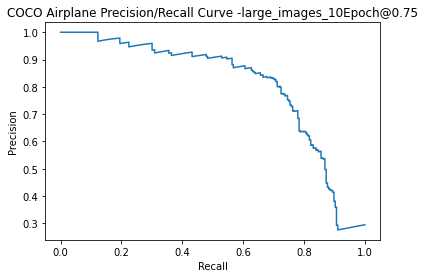

In [85]:
class_name='airplane'
xlabel = 'Recall'
ylabel = 'Precision'
title = 'COCO Airplane Precision/Recall Curve -large_images_10Epoch@' + str(iou_threshold)
save_fig_name = './model_evaluation_results/COCO-COCO/AIRPLANE_CLASS/coco_airplane_evaluation_result-PrecisionVsRecall_iou@' + str(iou_threshold) + 'large_images_10Epoch.png'
show_model_evaluation_result(model_eval_result_1,iou_threshold,class_name,xlabel,ylabel,title,save_fig_name)